In [1]:
#!pip install tqdm

In [2]:
#pip install path
import torch
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, os.path
from path import Path
import shutil
from rasterio.windows import get_data_window
from rasterio.windows import Window
import rasterio.mask
import json
from shapely.geometry import Polygon
import random
import numpy as np
import argparse

In [3]:
import torch
import torch.nn as nn

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )


In [4]:
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=4, out_channels=3).to(device)
model.load_state_dict(torch.load('unet_third_model.pth', map_location=device))
model.eval()

UNET(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

In [5]:
def raster2tiles(input_value_raster, tile_width_in, tile_height_in, outfolder): 
    '''This is function is used to clip the raster data into many smaller 
    fixed size of tiles
    
    Parameter: 
        input_value_raster: the filename of the input raster
        tile_width_in: the specified tile width
        tile_height_in: the specified tile height
        outfolder: the ouput dsm folder
    '''
    
    lu_dataset = rasterio.open(input_value_raster)
    lu_img = lu_dataset.read()
    
    # height and width of the raster
    height, width = lu_dataset.shape

    # split the large raser into number of tiles, tile size is 2000*2000
    tile_width = tile_width_in
    tile_height = tile_height_in

    tile_num_col = int(width/tile_width + 0.5)
    tile_num_row = int(height/tile_height + 0.5)

    # the output folder
    if not os.path.exists(outfolder): os.mkdir(outfolder)
    
    # create each tile
    for i in range(tile_num_row):
        # re-initiate the tile width when reach the right boundary
        tile_width = tile_width_in
        row_start = i*tile_height

        # loop each column
        for j in range(tile_num_col):
            print('The i and j is:', i, j)
            tilename = os.path.join(outfolder, 'row%s-col%s.tif'%(i, j))
            
            col_start = j*tile_width
            row_end = (i + 1)*tile_height
            col_end = (j + 1)*tile_width
            
            # deal with the right boundary
            if row_end > height - 1: tile_height = height - row_start
            if col_end > width - 1: tile_width = width - col_start
            
            # window = get_data_window(lu_dataset.read(1, masked=True))
            window = Window(col_off=col_start, row_off=row_start, width=tile_width, height=tile_height)
            
            kwargs = lu_dataset.meta.copy()
            kwargs.update({
                'height': window.height,
                'width': window.width,
                'transform': rasterio.windows.transform(window, lu_dataset.transform)})
            
            img_window = lu_dataset.read(window=window)
            zero_ratio = np.sum(img_window == 0) / img_window.size
            if zero_ratio > 0.99: continue# filter nodata>40% tiles

            with rasterio.open(tilename, 'w', **kwargs) as dst:
                dst.write(img_window)

In [6]:
# predict 2023

In [7]:
naip_file = 'data/naip2023.tif'

# configure the training data folder
folder1 = 'data/predict/2023/raw'
if not os.path.exists(folder1):
    os.makedirs(folder1)

tile_width = 512
tile_height = 512

raster2tiles(naip_file, tile_width, tile_height, folder1)

The i and j is: 0 0
The i and j is: 0 1
The i and j is: 0 2
The i and j is: 0 3
The i and j is: 0 4
The i and j is: 0 5
The i and j is: 0 6
The i and j is: 0 7
The i and j is: 0 8
The i and j is: 0 9
The i and j is: 0 10
The i and j is: 0 11
The i and j is: 0 12
The i and j is: 0 13
The i and j is: 0 14
The i and j is: 0 15
The i and j is: 0 16
The i and j is: 0 17
The i and j is: 0 18
The i and j is: 0 19
The i and j is: 0 20
The i and j is: 1 0
The i and j is: 1 1
The i and j is: 1 2
The i and j is: 1 3
The i and j is: 1 4
The i and j is: 1 5
The i and j is: 1 6
The i and j is: 1 7
The i and j is: 1 8
The i and j is: 1 9
The i and j is: 1 10
The i and j is: 1 11
The i and j is: 1 12
The i and j is: 1 13
The i and j is: 1 14
The i and j is: 1 15
The i and j is: 1 16
The i and j is: 1 17
The i and j is: 1 18
The i and j is: 1 19
The i and j is: 1 20
The i and j is: 2 0
The i and j is: 2 1
The i and j is: 2 2
The i and j is: 2 3
The i and j is: 2 4
The i and j is: 2 5
The i and j is: 2 

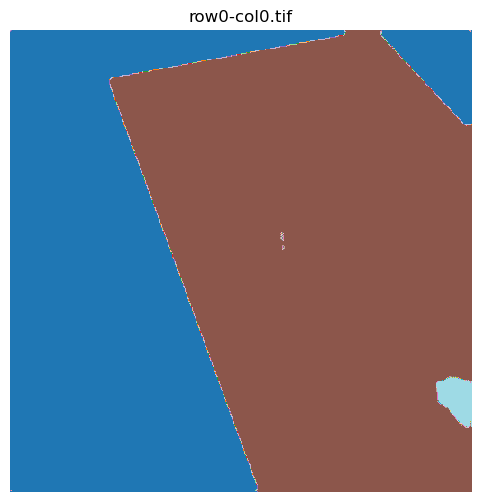

Saved: data\predict\2023\output\row0-col0_pred.tif


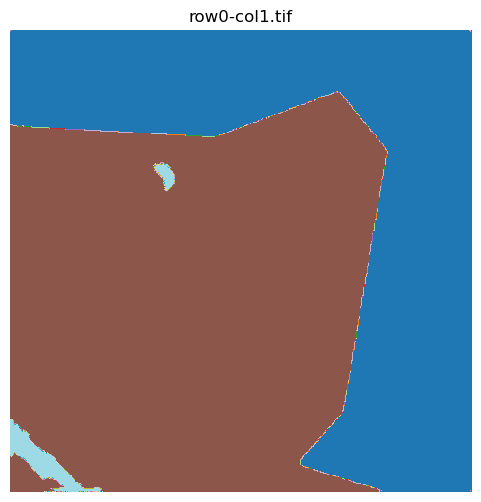

Saved: data\predict\2023\output\row0-col1_pred.tif


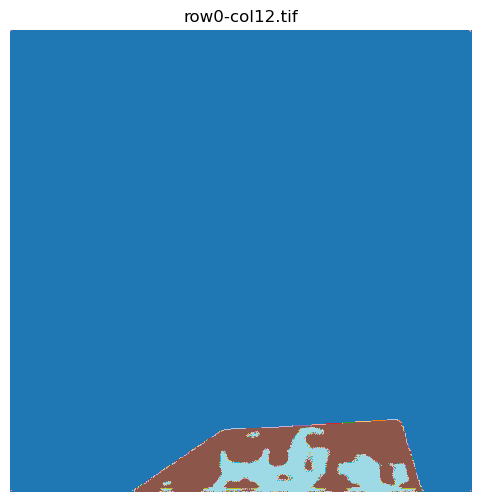

Saved: data\predict\2023\output\row0-col12_pred.tif


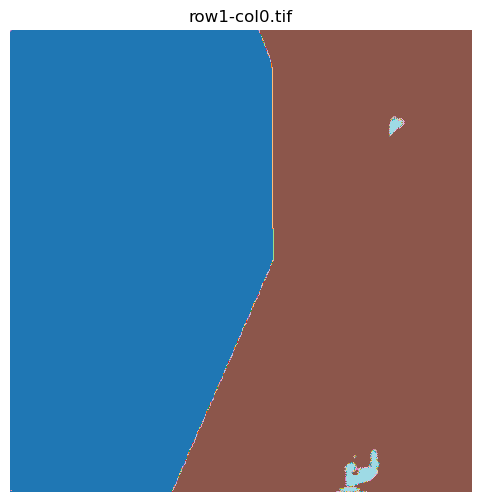

Saved: data\predict\2023\output\row1-col0_pred.tif


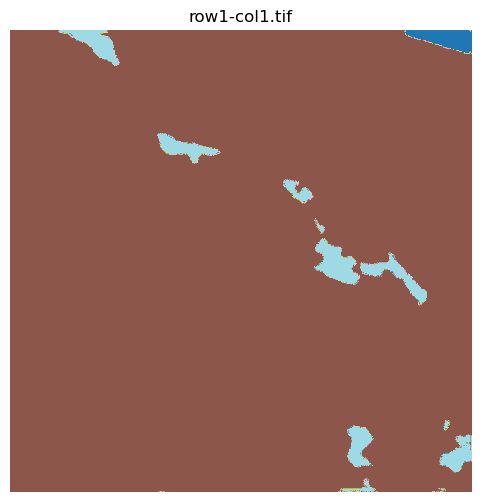

Saved: data\predict\2023\output\row1-col1_pred.tif


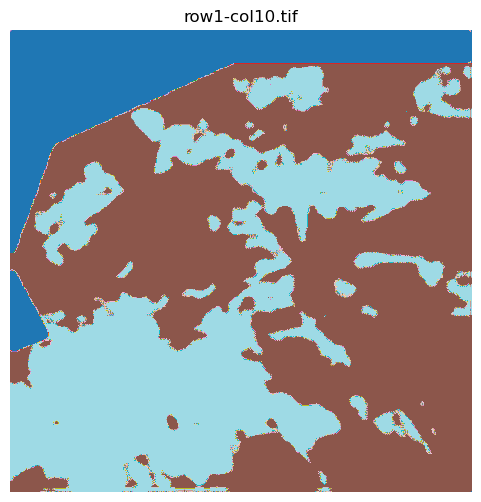

Saved: data\predict\2023\output\row1-col10_pred.tif


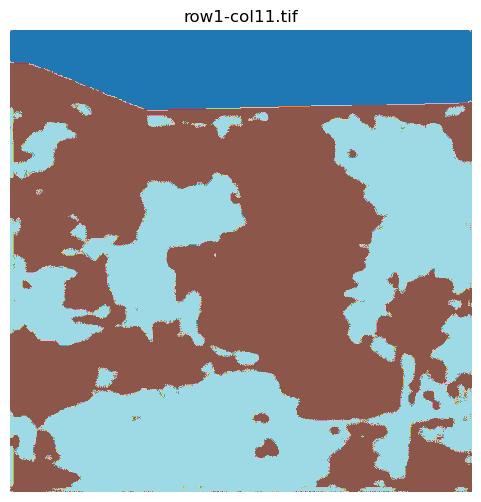

Saved: data\predict\2023\output\row1-col11_pred.tif


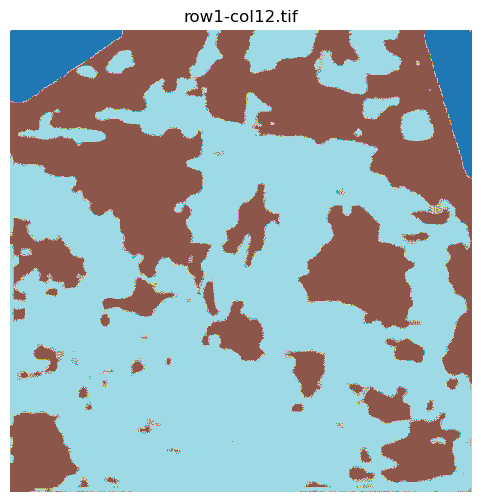

Saved: data\predict\2023\output\row1-col12_pred.tif


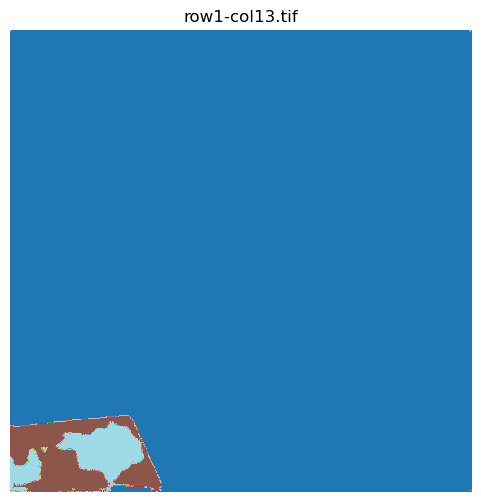

Saved: data\predict\2023\output\row1-col13_pred.tif


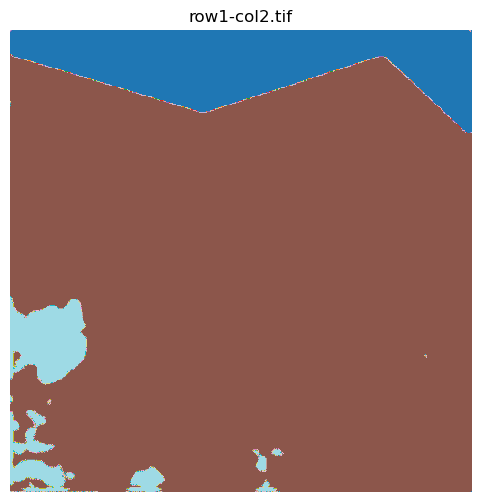

Saved: data\predict\2023\output\row1-col2_pred.tif


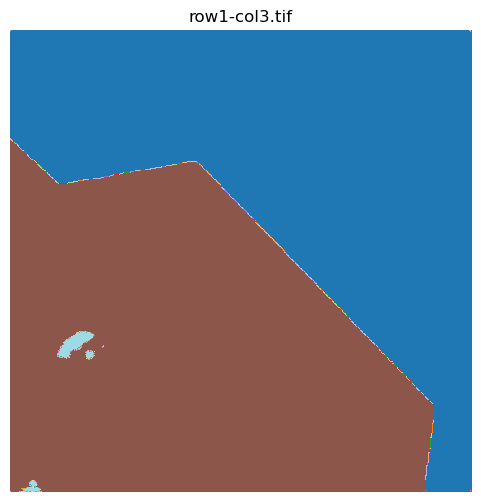

Saved: data\predict\2023\output\row1-col3_pred.tif


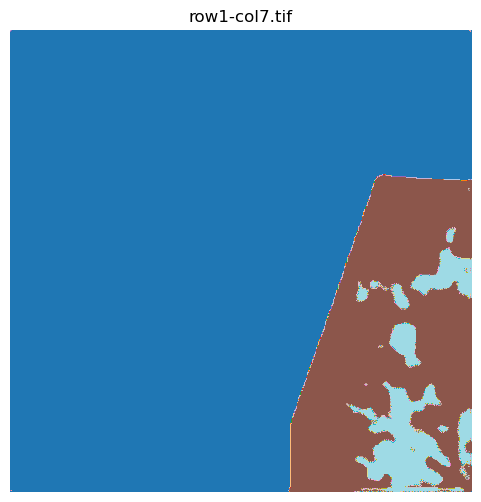

Saved: data\predict\2023\output\row1-col7_pred.tif


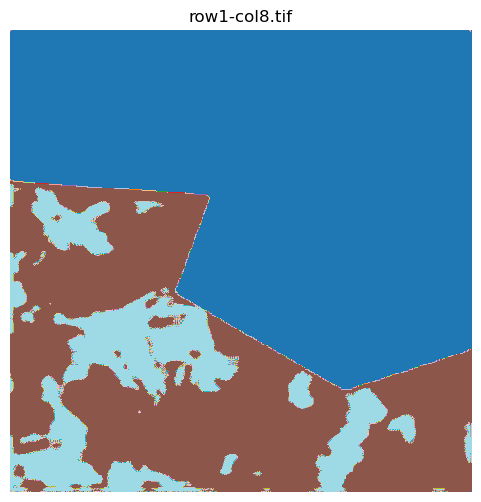

Saved: data\predict\2023\output\row1-col8_pred.tif


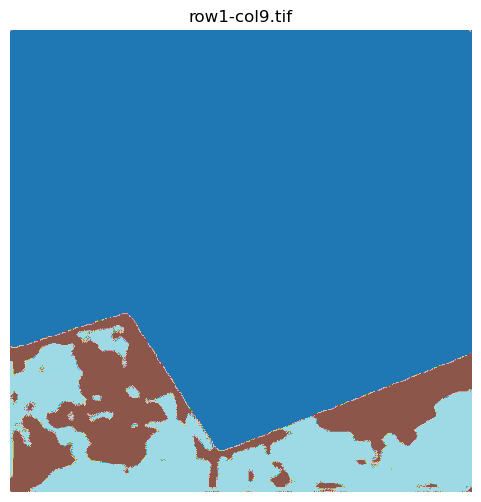

Saved: data\predict\2023\output\row1-col9_pred.tif


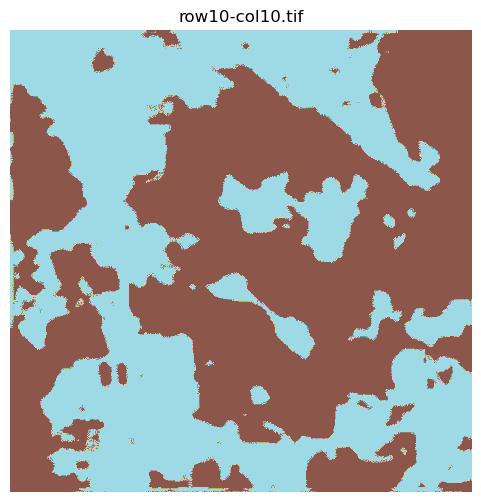

Saved: data\predict\2023\output\row10-col10_pred.tif


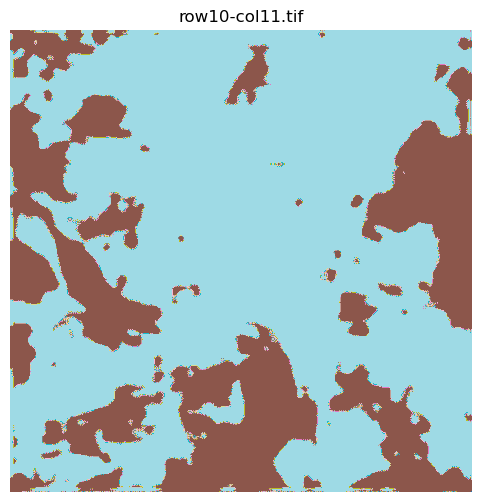

Saved: data\predict\2023\output\row10-col11_pred.tif


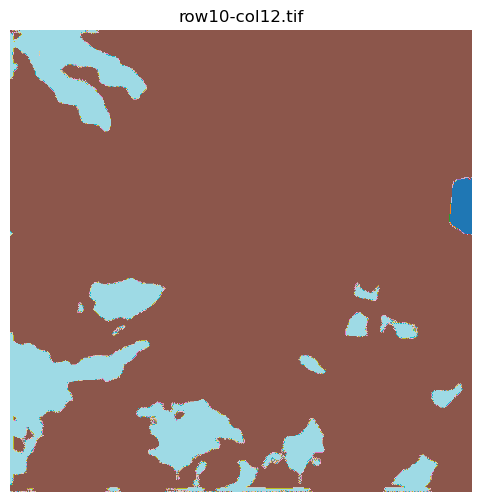

Saved: data\predict\2023\output\row10-col12_pred.tif


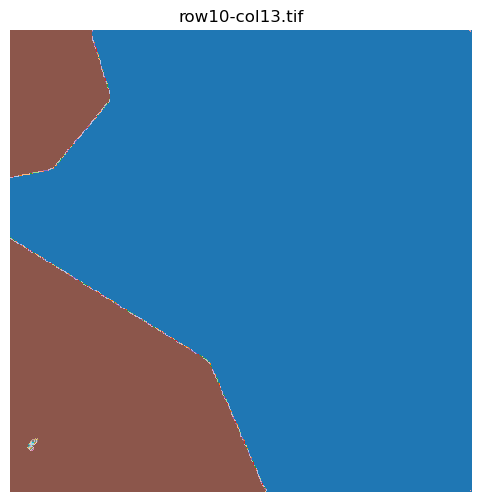

Saved: data\predict\2023\output\row10-col13_pred.tif


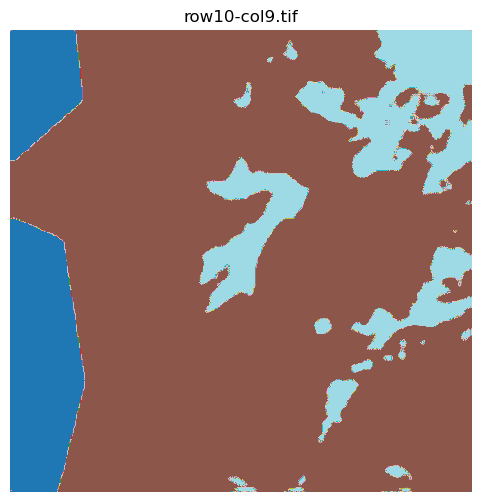

Saved: data\predict\2023\output\row10-col9_pred.tif


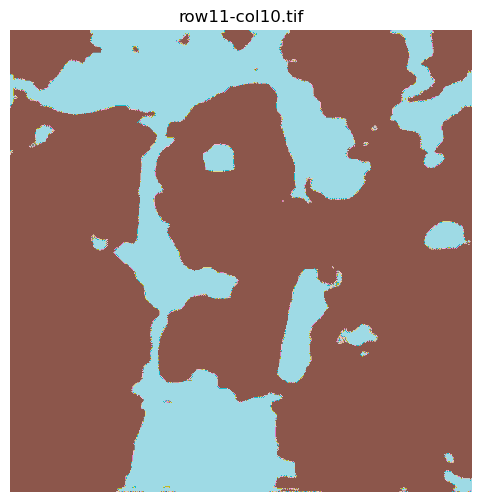

Saved: data\predict\2023\output\row11-col10_pred.tif


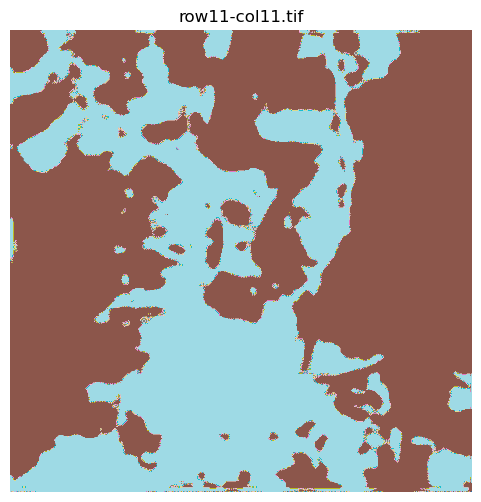

Saved: data\predict\2023\output\row11-col11_pred.tif


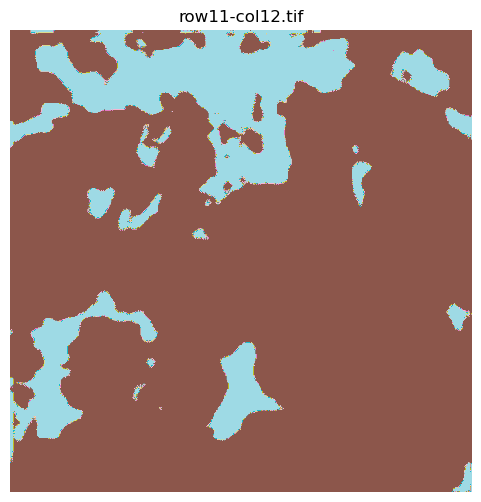

Saved: data\predict\2023\output\row11-col12_pred.tif


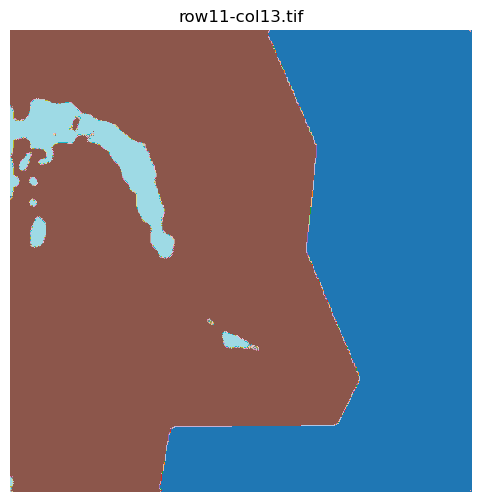

Saved: data\predict\2023\output\row11-col13_pred.tif


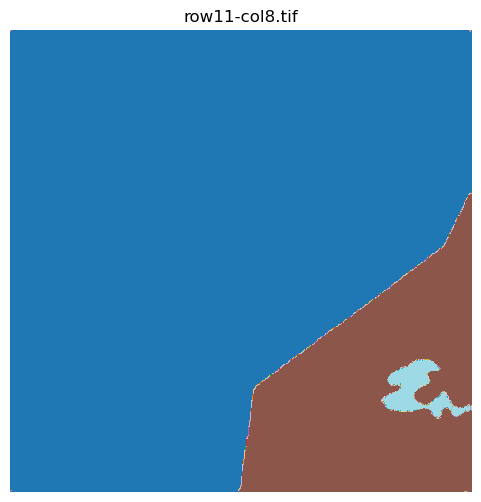

Saved: data\predict\2023\output\row11-col8_pred.tif


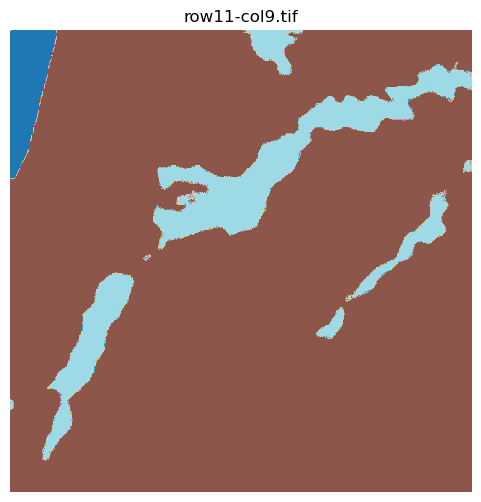

Saved: data\predict\2023\output\row11-col9_pred.tif


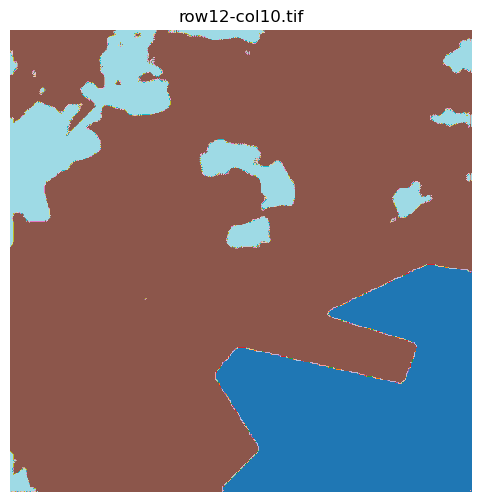

Saved: data\predict\2023\output\row12-col10_pred.tif


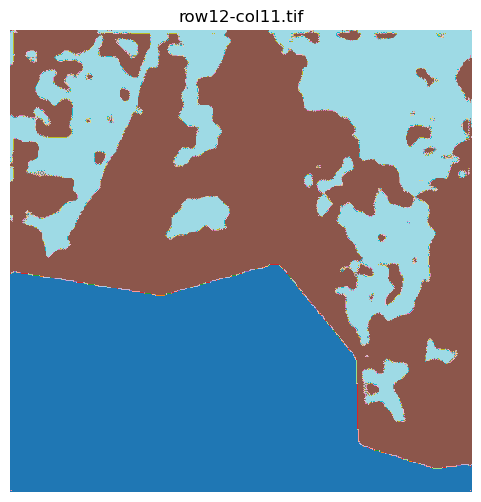

Saved: data\predict\2023\output\row12-col11_pred.tif


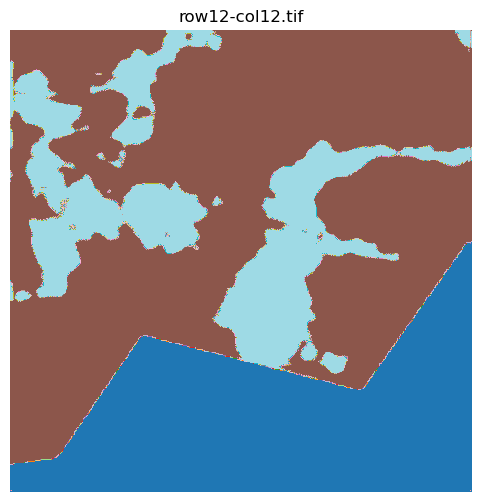

Saved: data\predict\2023\output\row12-col12_pred.tif


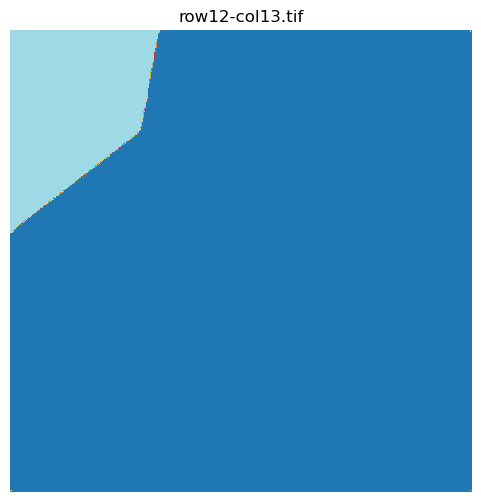

Saved: data\predict\2023\output\row12-col13_pred.tif


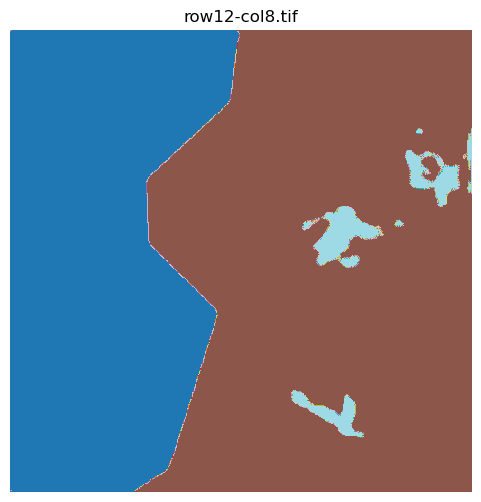

Saved: data\predict\2023\output\row12-col8_pred.tif


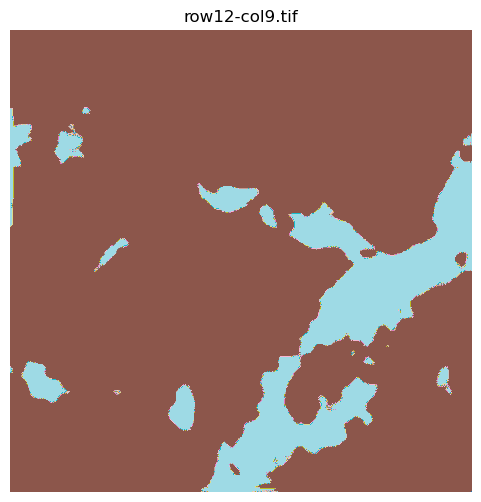

Saved: data\predict\2023\output\row12-col9_pred.tif


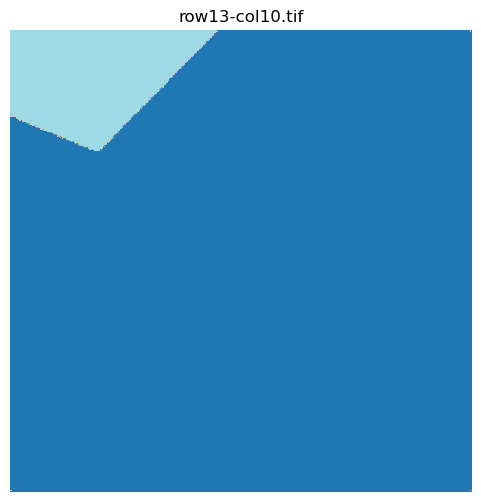

Saved: data\predict\2023\output\row13-col10_pred.tif


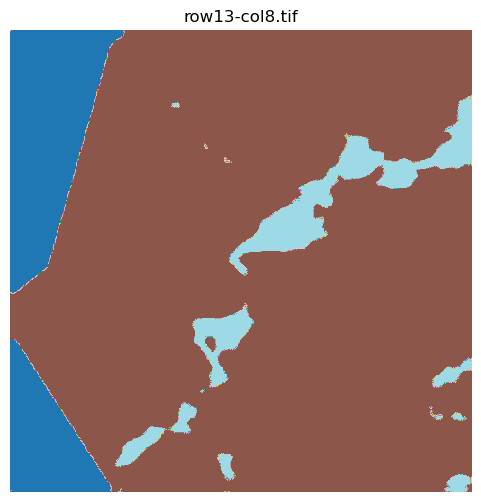

Saved: data\predict\2023\output\row13-col8_pred.tif


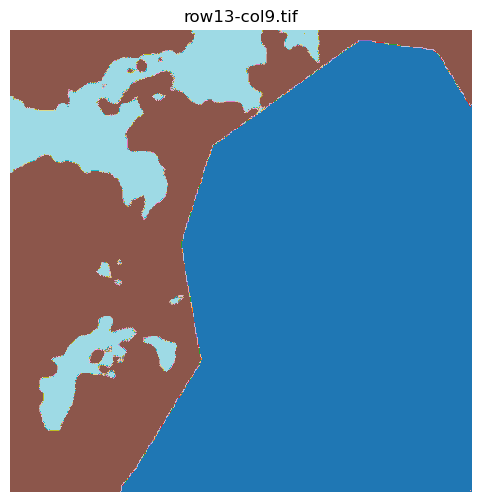

Saved: data\predict\2023\output\row13-col9_pred.tif


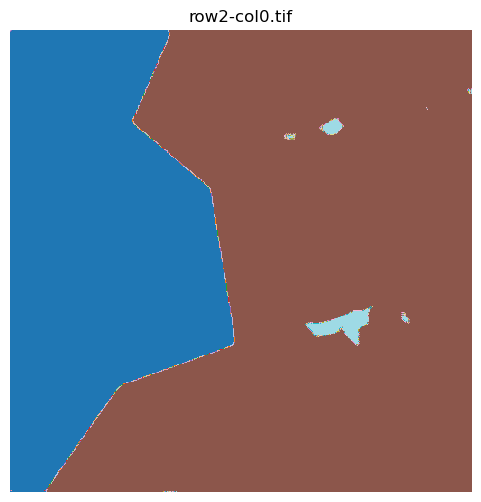

Saved: data\predict\2023\output\row2-col0_pred.tif


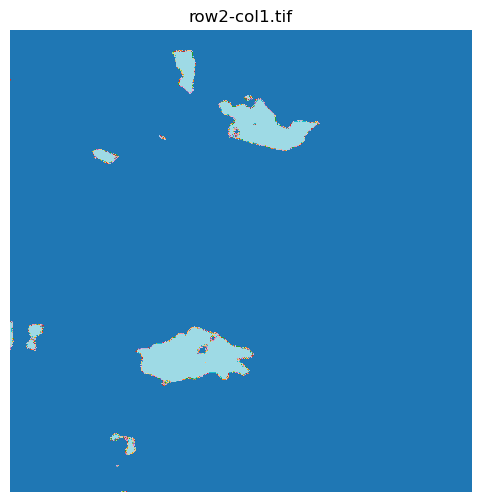

Saved: data\predict\2023\output\row2-col1_pred.tif


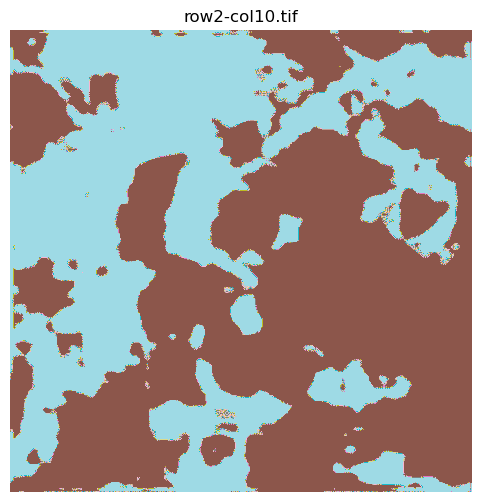

Saved: data\predict\2023\output\row2-col10_pred.tif


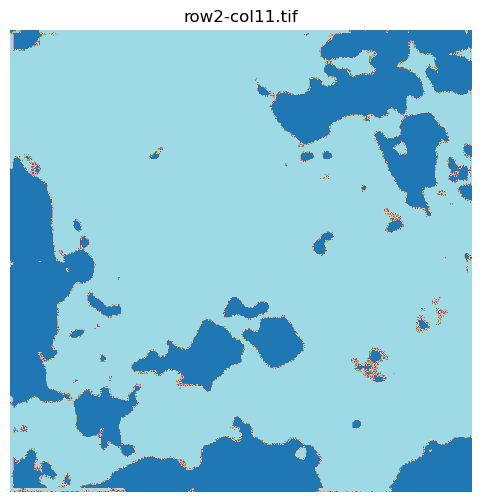

Saved: data\predict\2023\output\row2-col11_pred.tif


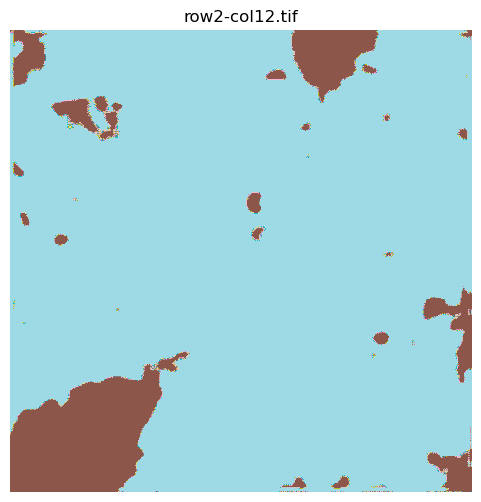

Saved: data\predict\2023\output\row2-col12_pred.tif


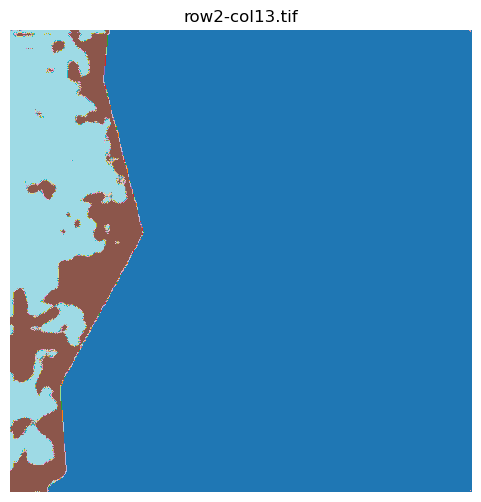

Saved: data\predict\2023\output\row2-col13_pred.tif


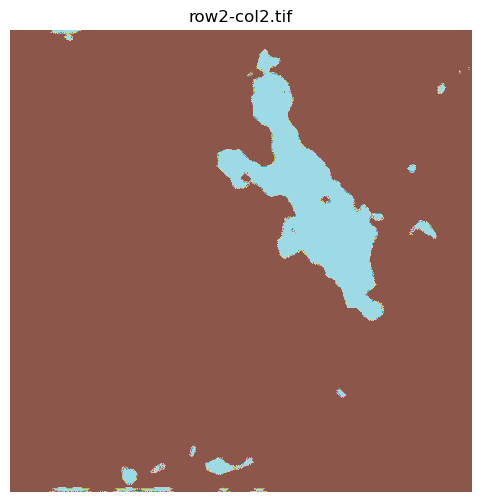

Saved: data\predict\2023\output\row2-col2_pred.tif


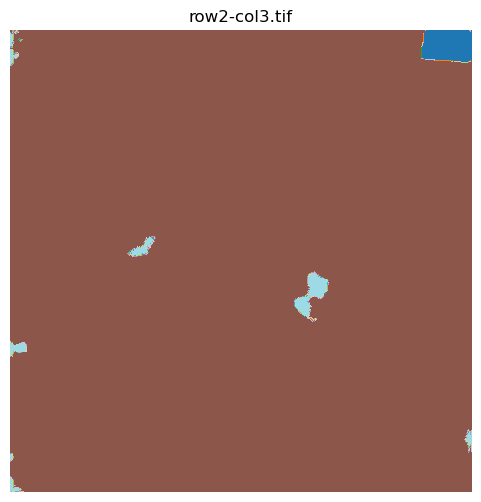

Saved: data\predict\2023\output\row2-col3_pred.tif


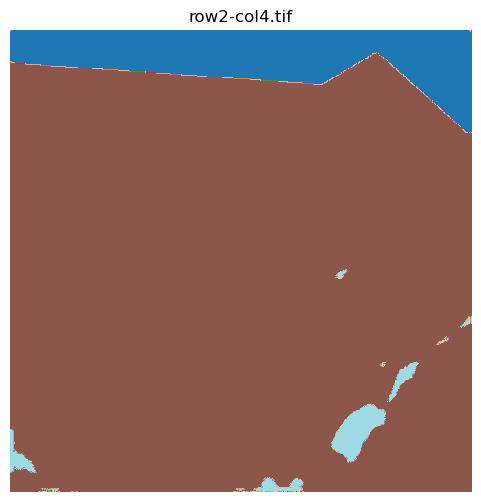

Saved: data\predict\2023\output\row2-col4_pred.tif


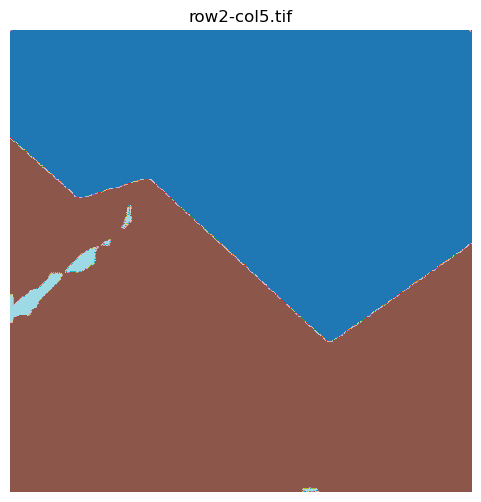

Saved: data\predict\2023\output\row2-col5_pred.tif


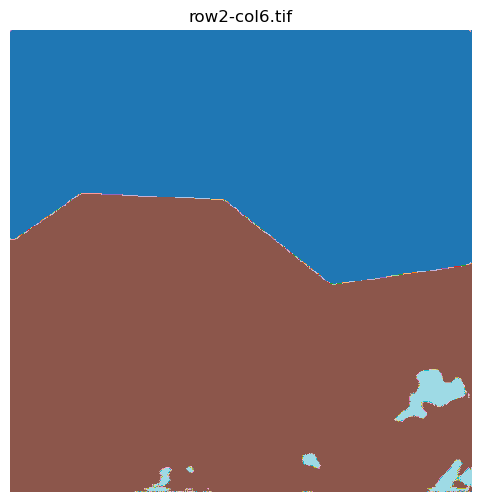

Saved: data\predict\2023\output\row2-col6_pred.tif


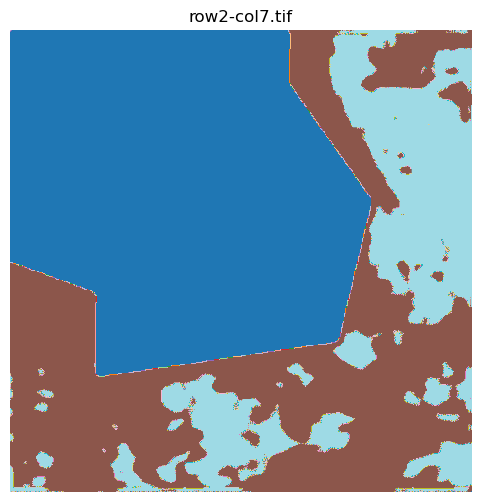

Saved: data\predict\2023\output\row2-col7_pred.tif


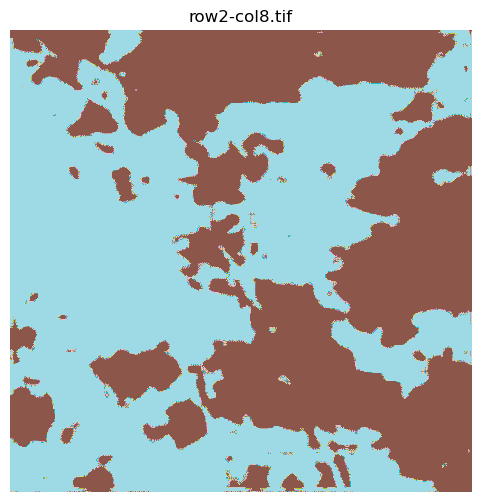

Saved: data\predict\2023\output\row2-col8_pred.tif


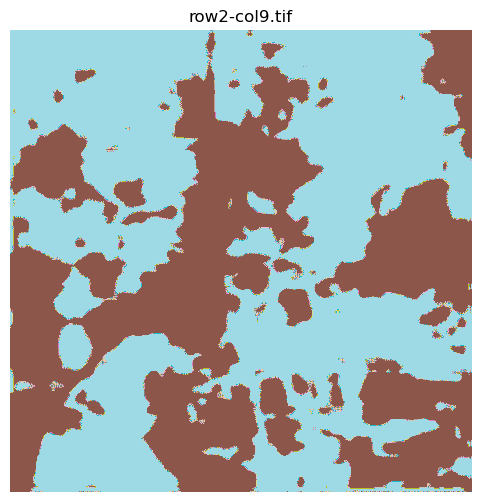

Saved: data\predict\2023\output\row2-col9_pred.tif


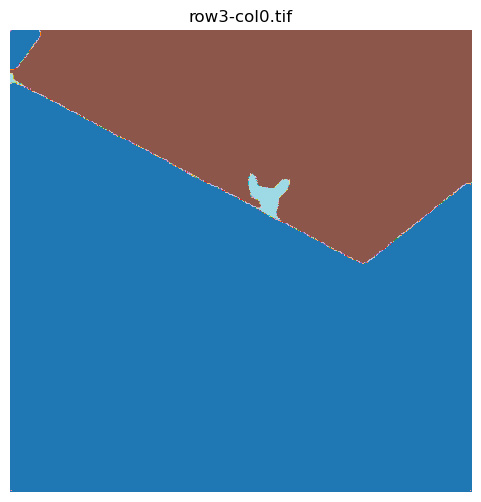

Saved: data\predict\2023\output\row3-col0_pred.tif


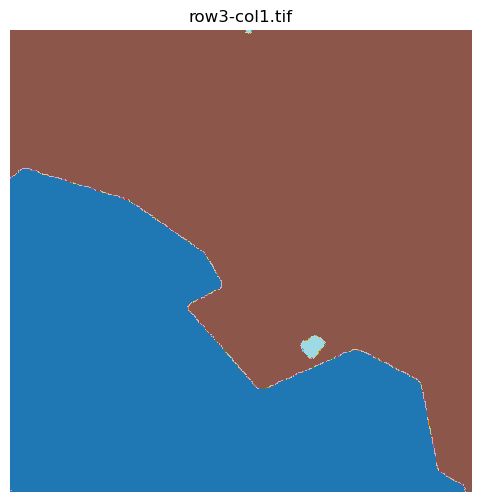

Saved: data\predict\2023\output\row3-col1_pred.tif


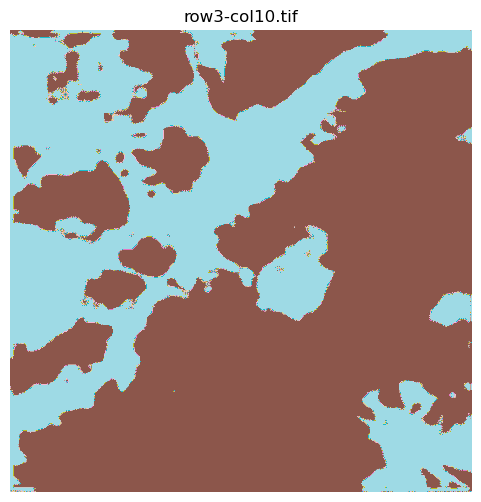

Saved: data\predict\2023\output\row3-col10_pred.tif


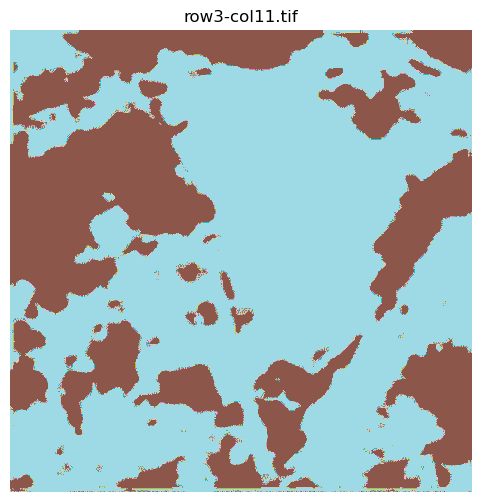

Saved: data\predict\2023\output\row3-col11_pred.tif


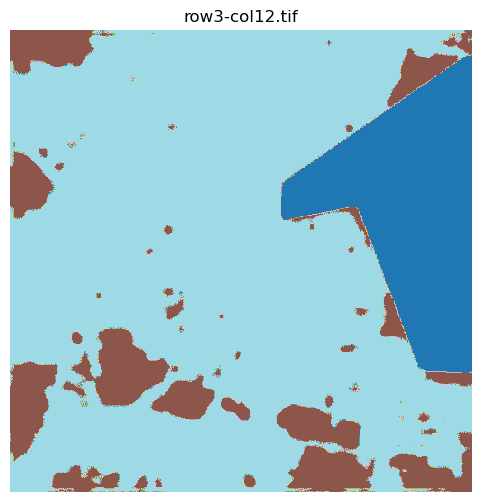

Saved: data\predict\2023\output\row3-col12_pred.tif


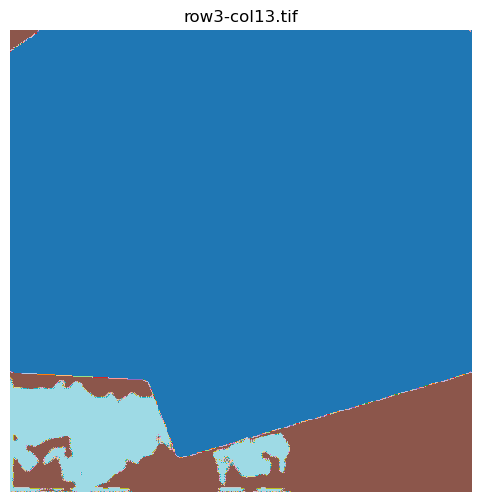

Saved: data\predict\2023\output\row3-col13_pred.tif


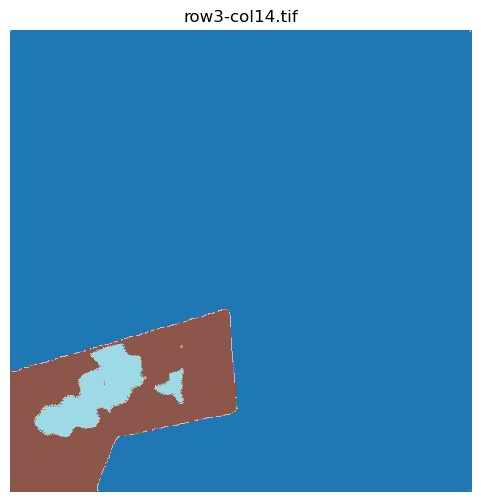

Saved: data\predict\2023\output\row3-col14_pred.tif


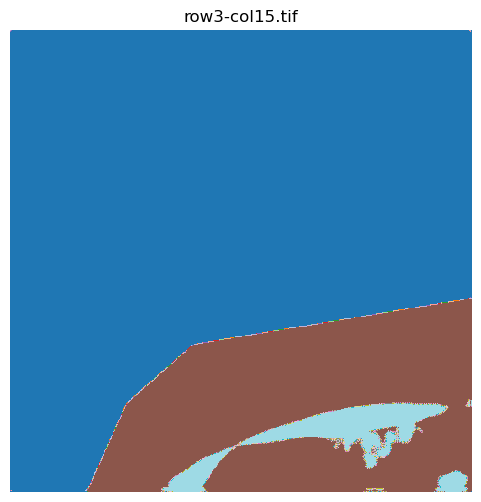

Saved: data\predict\2023\output\row3-col15_pred.tif


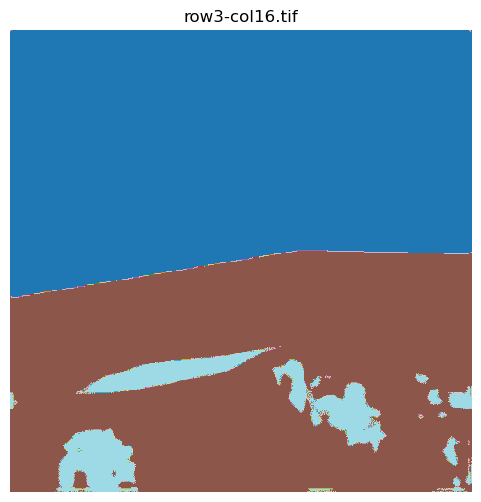

Saved: data\predict\2023\output\row3-col16_pred.tif


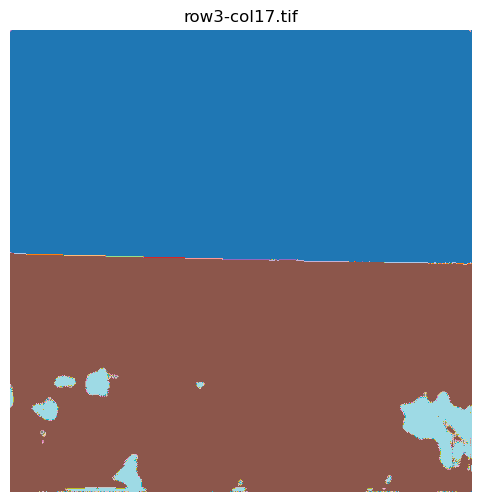

Saved: data\predict\2023\output\row3-col17_pred.tif


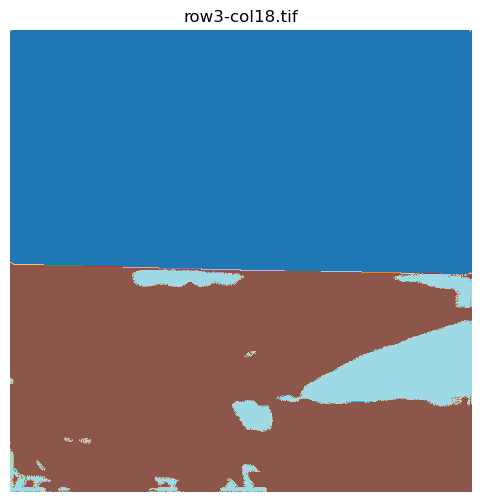

Saved: data\predict\2023\output\row3-col18_pred.tif


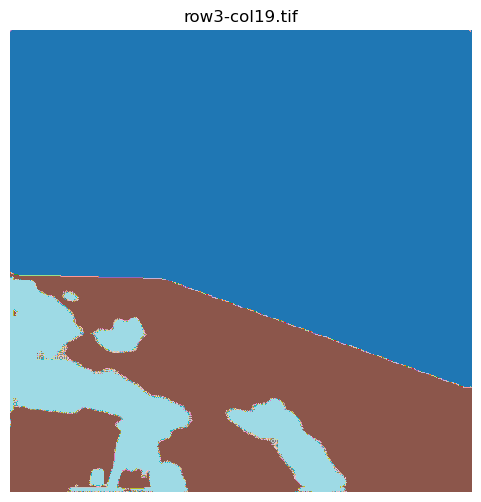

Saved: data\predict\2023\output\row3-col19_pred.tif


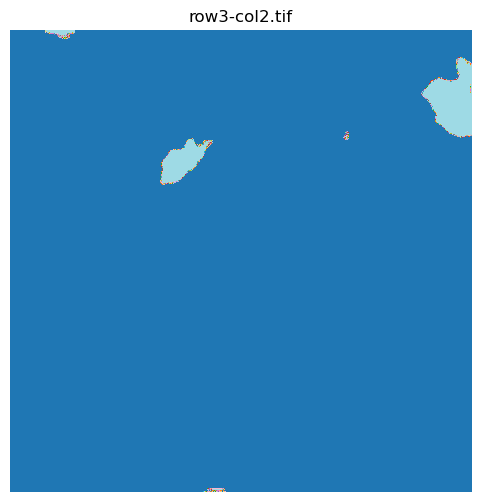

Saved: data\predict\2023\output\row3-col2_pred.tif


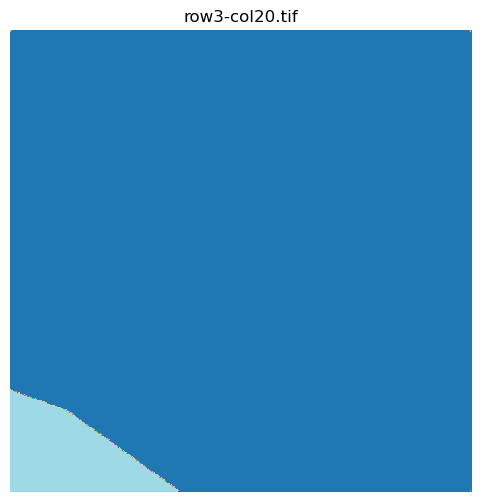

Saved: data\predict\2023\output\row3-col20_pred.tif


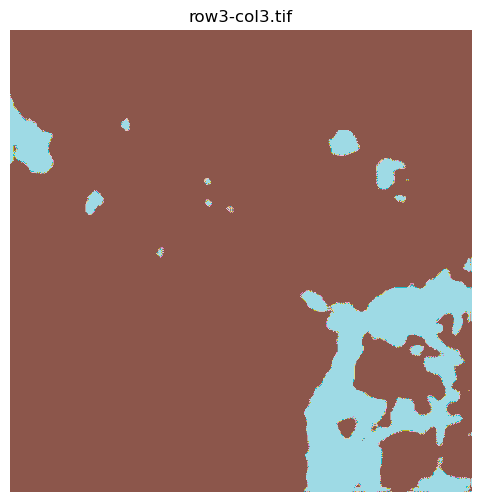

Saved: data\predict\2023\output\row3-col3_pred.tif


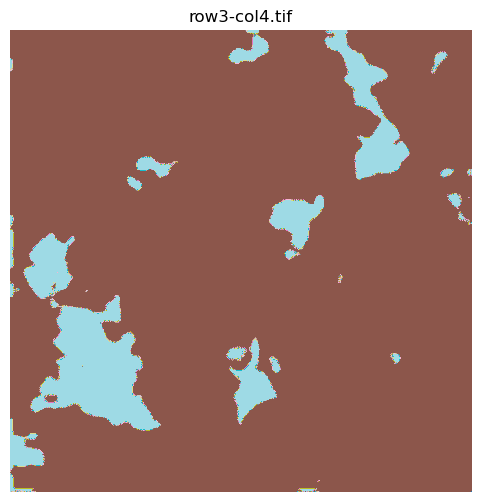

Saved: data\predict\2023\output\row3-col4_pred.tif


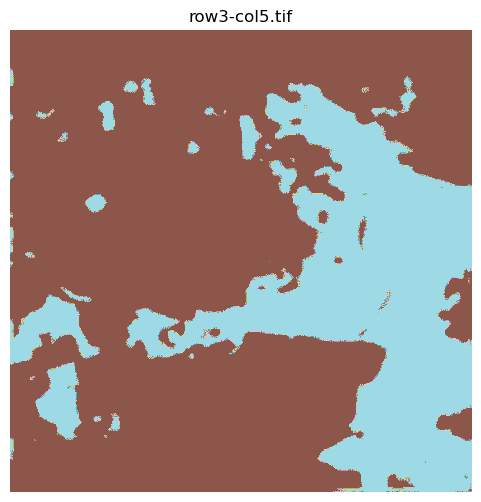

Saved: data\predict\2023\output\row3-col5_pred.tif


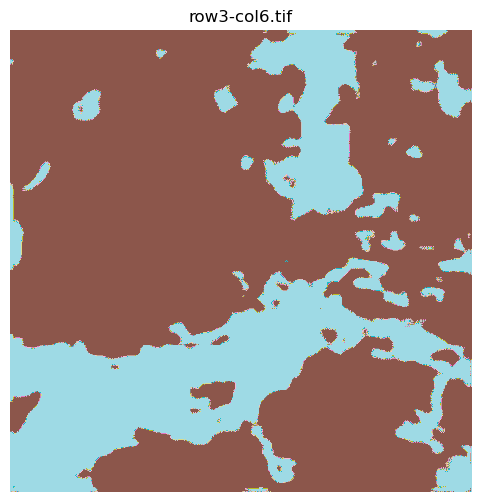

Saved: data\predict\2023\output\row3-col6_pred.tif


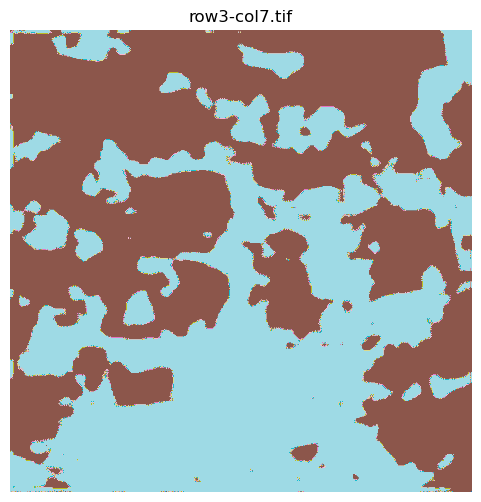

Saved: data\predict\2023\output\row3-col7_pred.tif


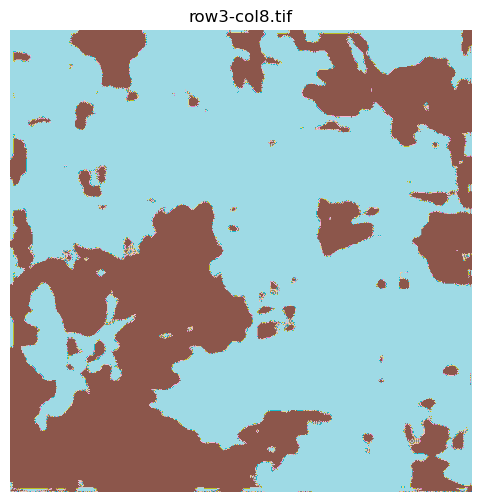

Saved: data\predict\2023\output\row3-col8_pred.tif


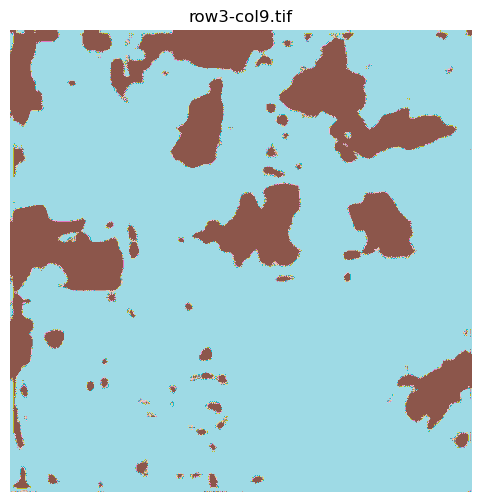

Saved: data\predict\2023\output\row3-col9_pred.tif


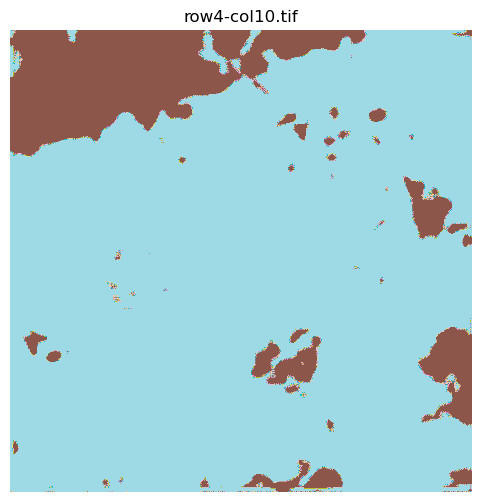

Saved: data\predict\2023\output\row4-col10_pred.tif


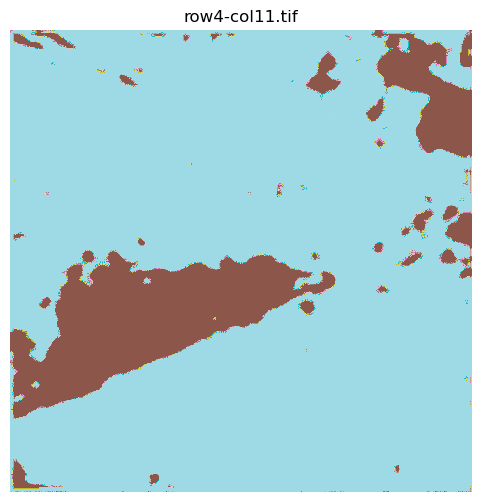

Saved: data\predict\2023\output\row4-col11_pred.tif


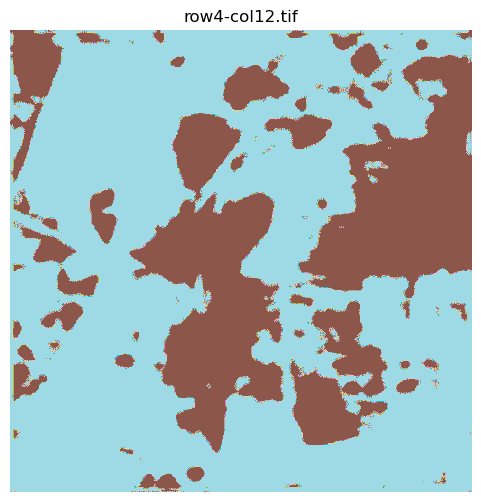

Saved: data\predict\2023\output\row4-col12_pred.tif


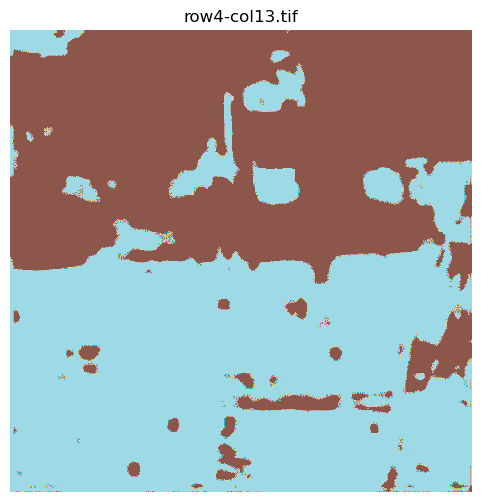

Saved: data\predict\2023\output\row4-col13_pred.tif


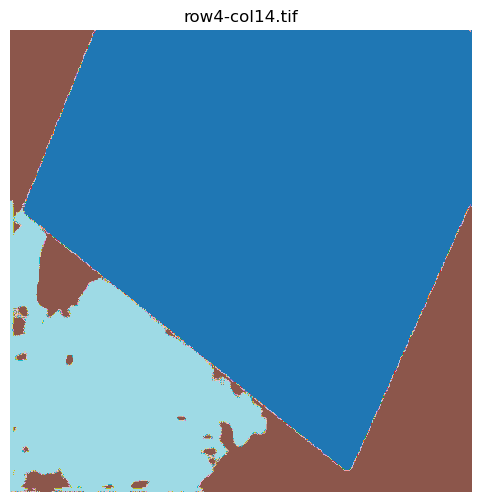

Saved: data\predict\2023\output\row4-col14_pred.tif


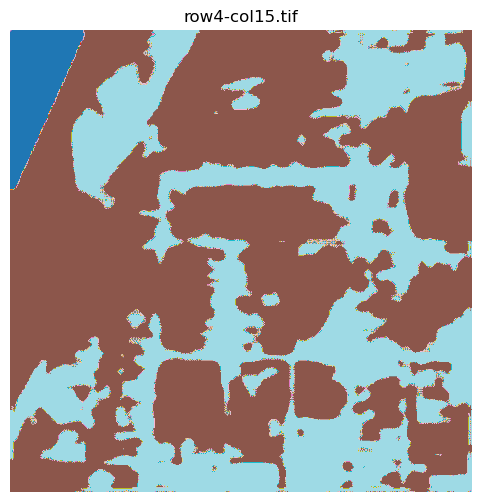

Saved: data\predict\2023\output\row4-col15_pred.tif


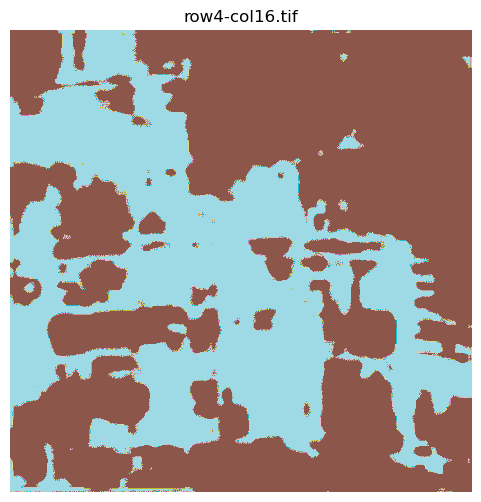

Saved: data\predict\2023\output\row4-col16_pred.tif


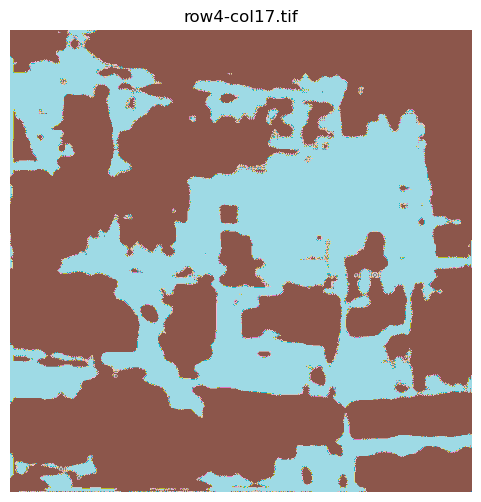

Saved: data\predict\2023\output\row4-col17_pred.tif


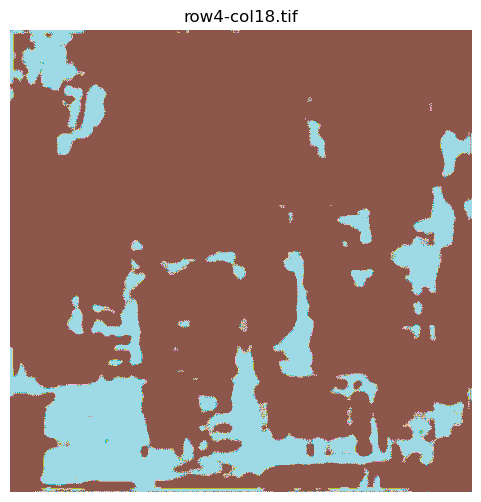

Saved: data\predict\2023\output\row4-col18_pred.tif


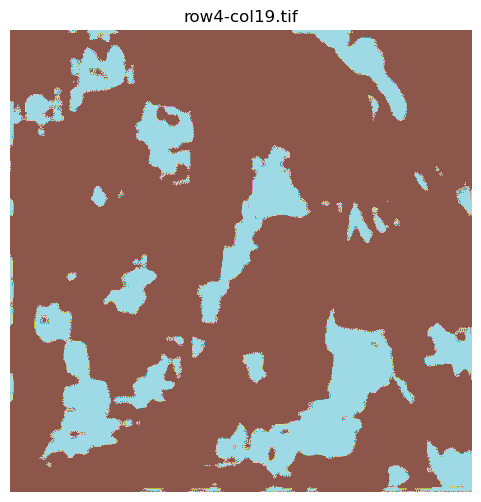

Saved: data\predict\2023\output\row4-col19_pred.tif


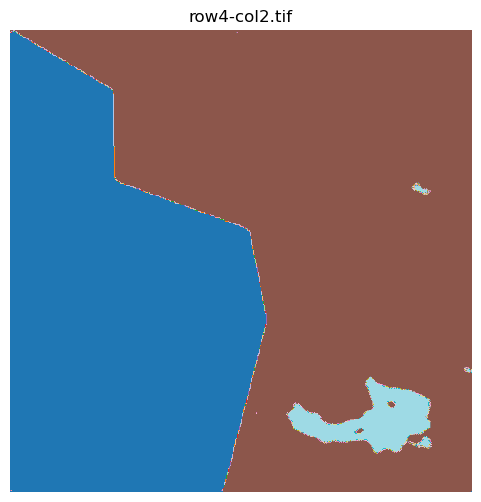

Saved: data\predict\2023\output\row4-col2_pred.tif


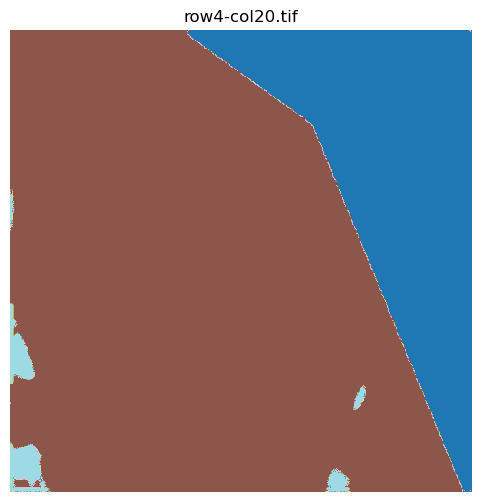

Saved: data\predict\2023\output\row4-col20_pred.tif


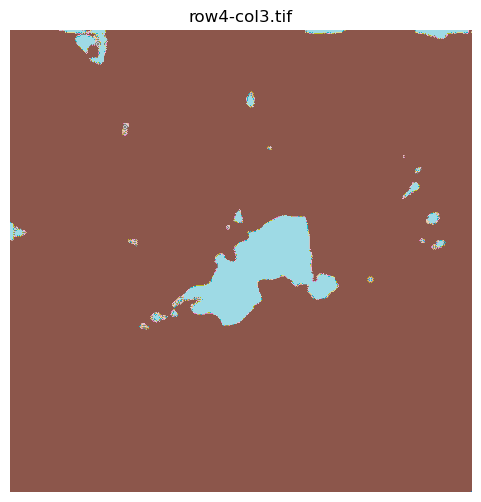

Saved: data\predict\2023\output\row4-col3_pred.tif


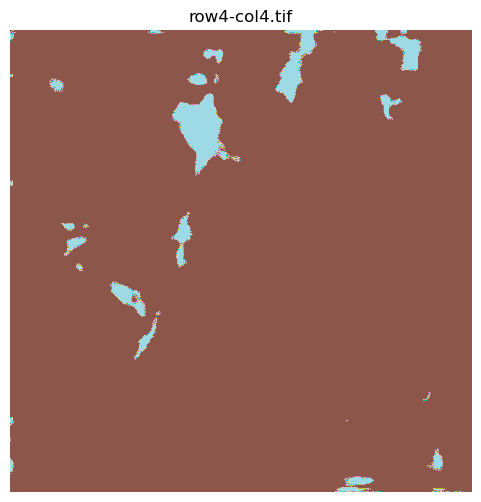

Saved: data\predict\2023\output\row4-col4_pred.tif


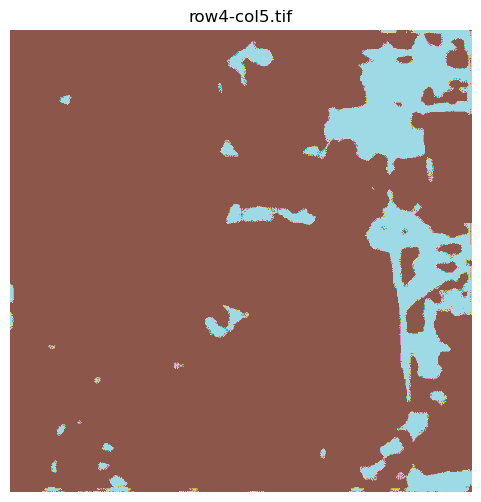

Saved: data\predict\2023\output\row4-col5_pred.tif


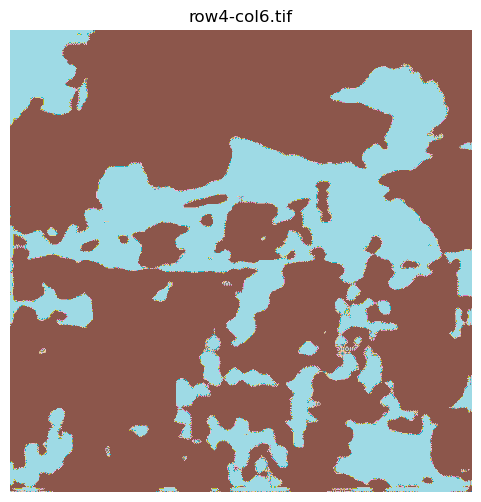

Saved: data\predict\2023\output\row4-col6_pred.tif


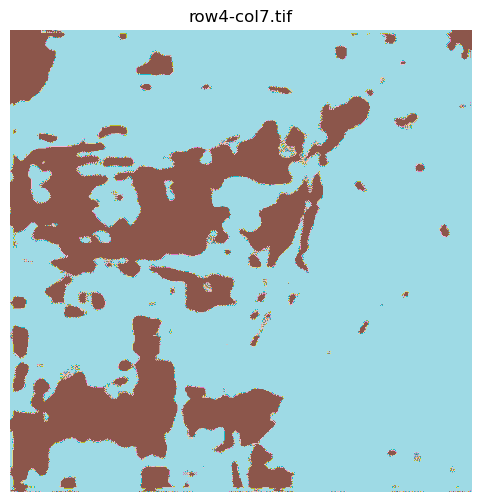

Saved: data\predict\2023\output\row4-col7_pred.tif


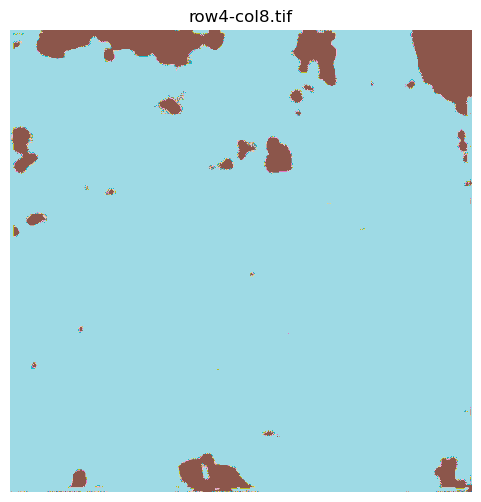

Saved: data\predict\2023\output\row4-col8_pred.tif


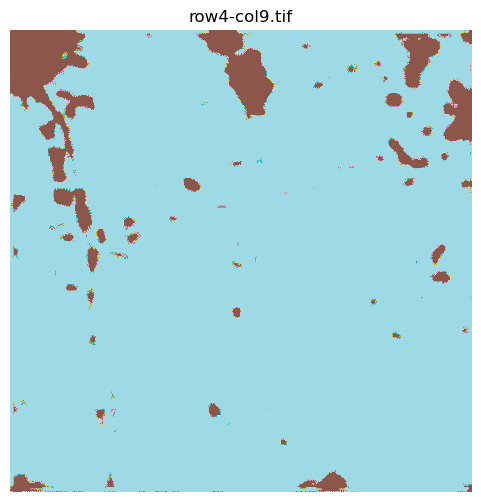

Saved: data\predict\2023\output\row4-col9_pred.tif


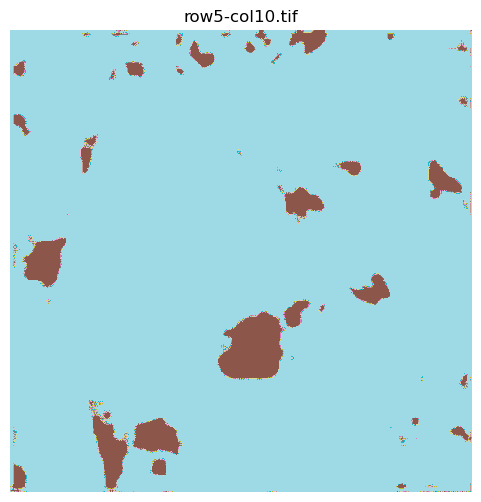

Saved: data\predict\2023\output\row5-col10_pred.tif


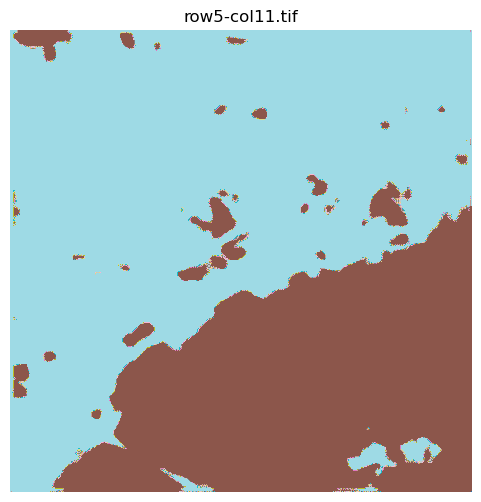

Saved: data\predict\2023\output\row5-col11_pred.tif


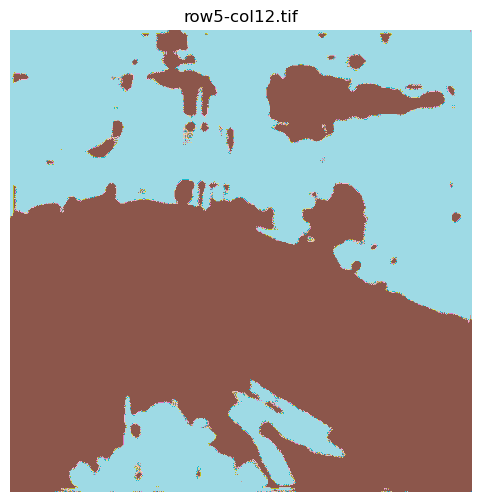

Saved: data\predict\2023\output\row5-col12_pred.tif


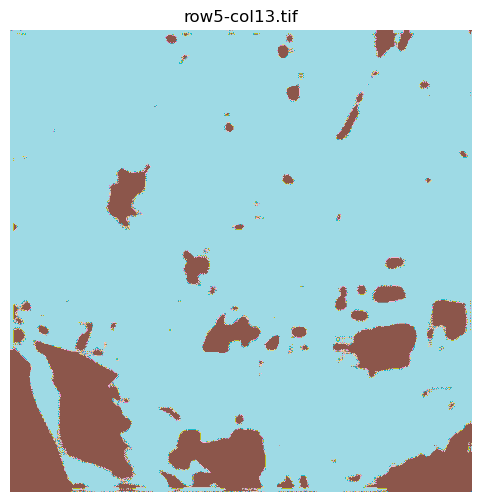

Saved: data\predict\2023\output\row5-col13_pred.tif


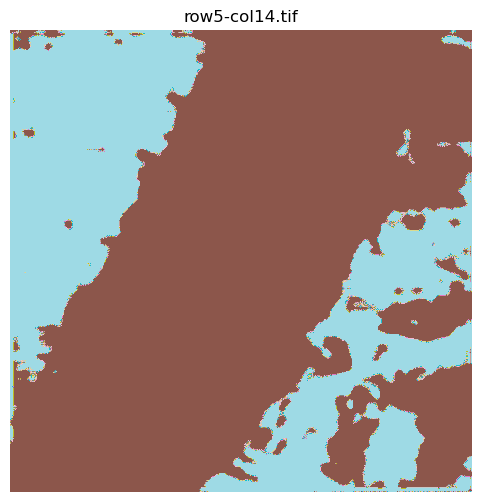

Saved: data\predict\2023\output\row5-col14_pred.tif


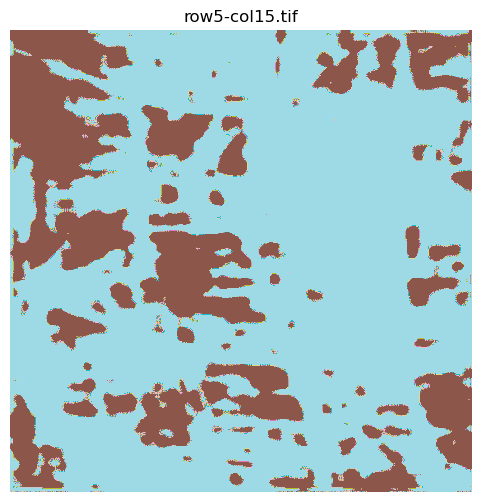

Saved: data\predict\2023\output\row5-col15_pred.tif


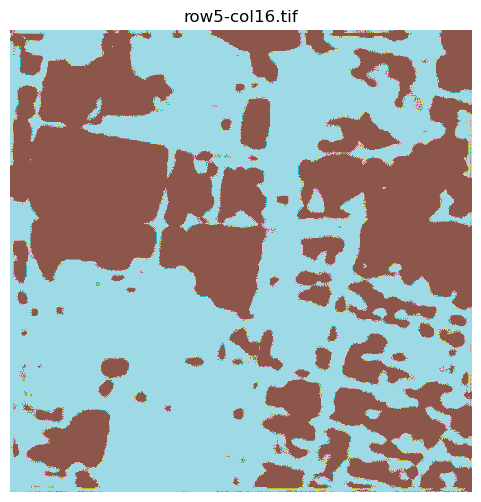

Saved: data\predict\2023\output\row5-col16_pred.tif


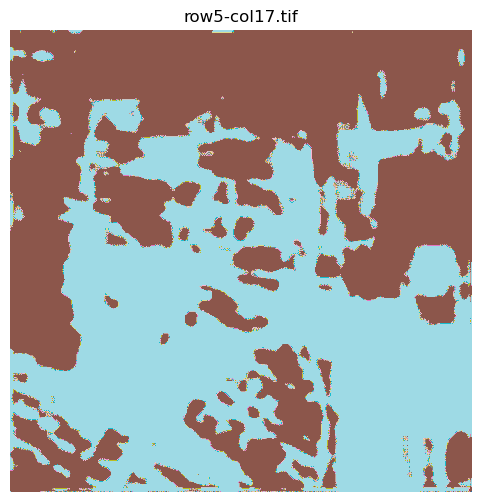

Saved: data\predict\2023\output\row5-col17_pred.tif


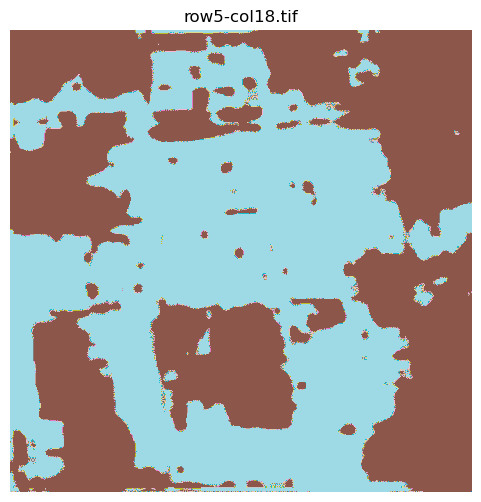

Saved: data\predict\2023\output\row5-col18_pred.tif


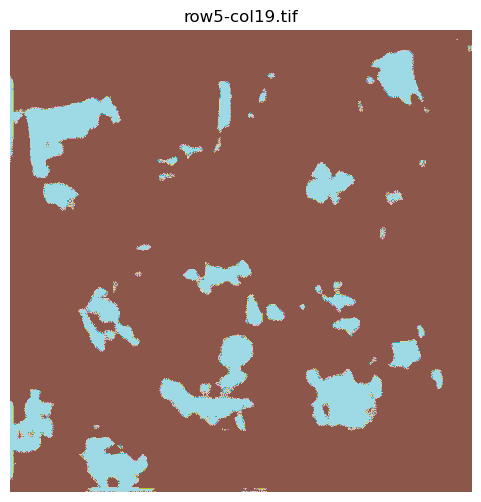

Saved: data\predict\2023\output\row5-col19_pred.tif


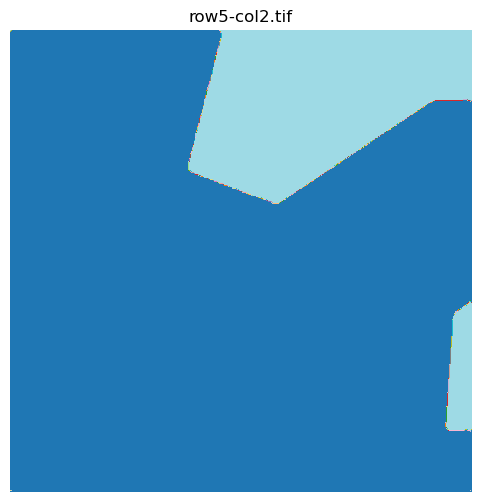

Saved: data\predict\2023\output\row5-col2_pred.tif


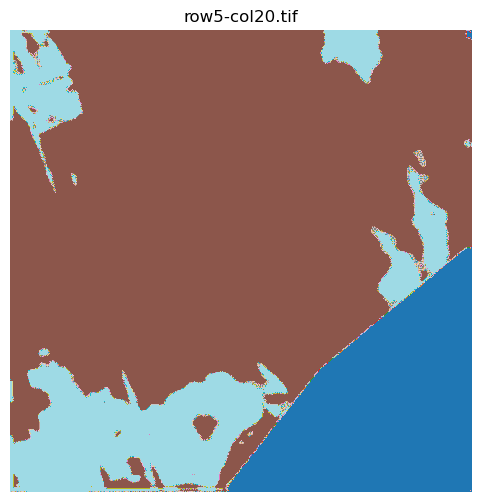

Saved: data\predict\2023\output\row5-col20_pred.tif


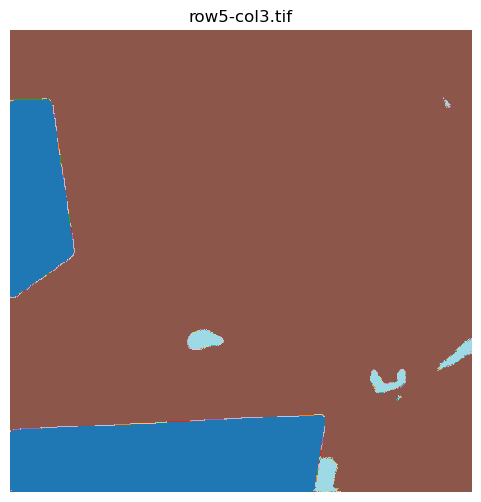

Saved: data\predict\2023\output\row5-col3_pred.tif


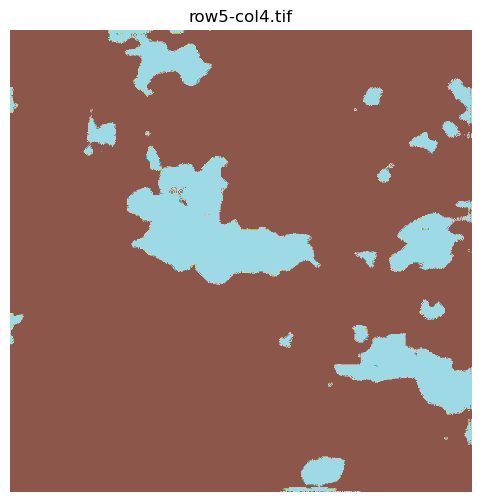

Saved: data\predict\2023\output\row5-col4_pred.tif


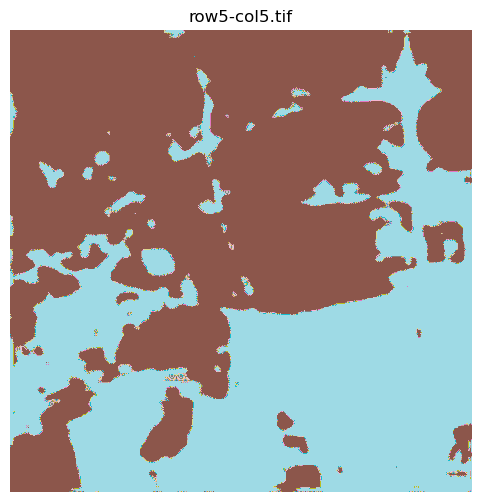

Saved: data\predict\2023\output\row5-col5_pred.tif


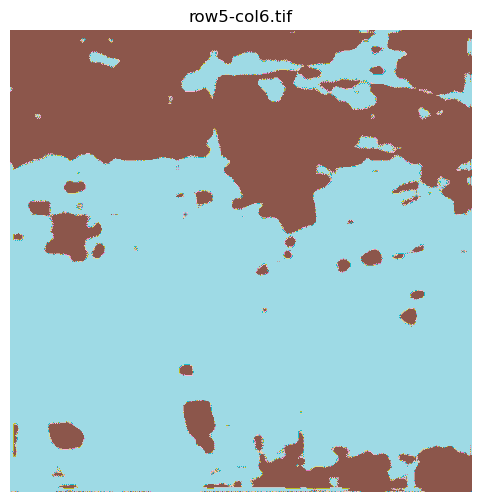

Saved: data\predict\2023\output\row5-col6_pred.tif


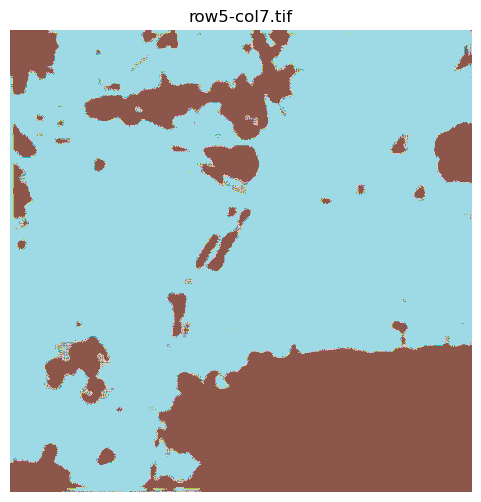

Saved: data\predict\2023\output\row5-col7_pred.tif


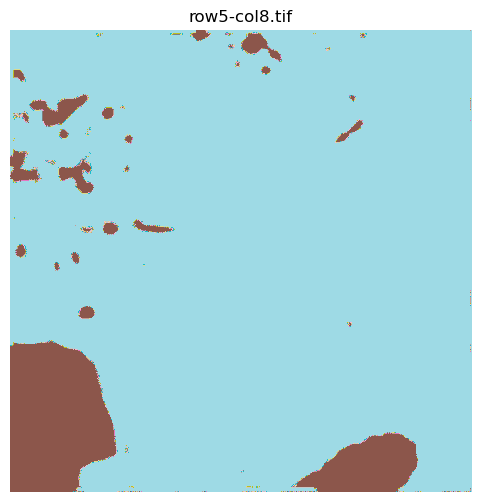

Saved: data\predict\2023\output\row5-col8_pred.tif


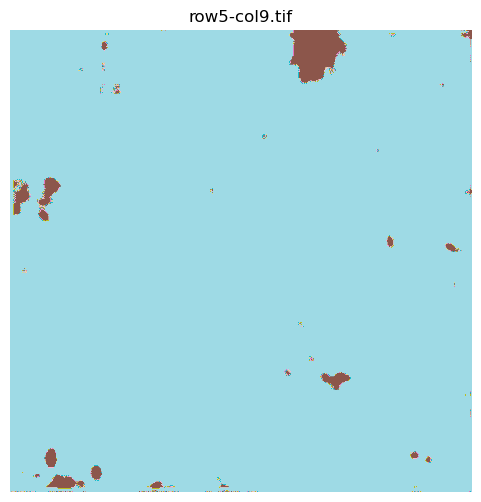

Saved: data\predict\2023\output\row5-col9_pred.tif


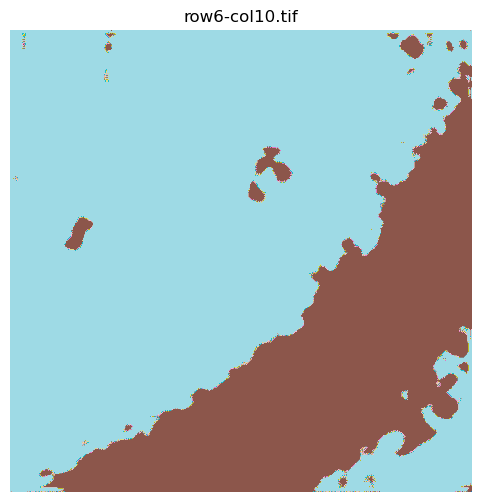

Saved: data\predict\2023\output\row6-col10_pred.tif


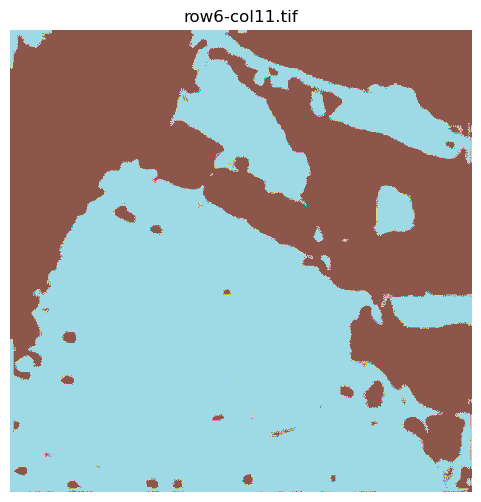

Saved: data\predict\2023\output\row6-col11_pred.tif


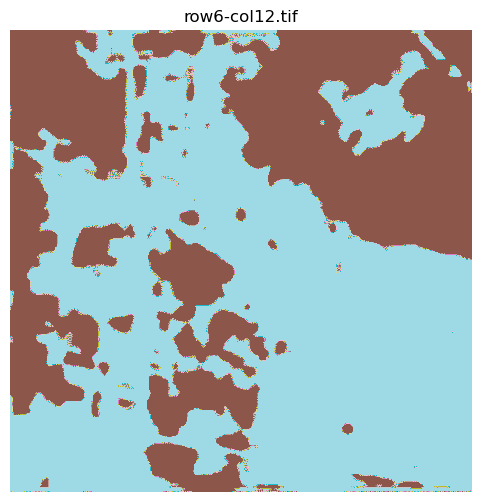

Saved: data\predict\2023\output\row6-col12_pred.tif


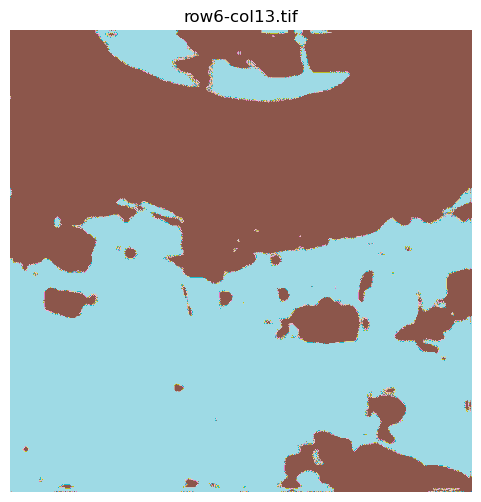

Saved: data\predict\2023\output\row6-col13_pred.tif


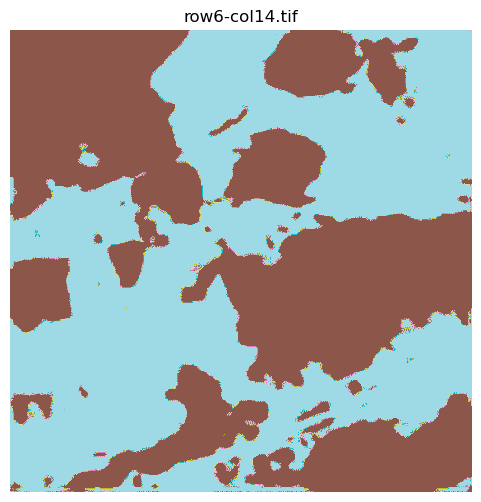

Saved: data\predict\2023\output\row6-col14_pred.tif


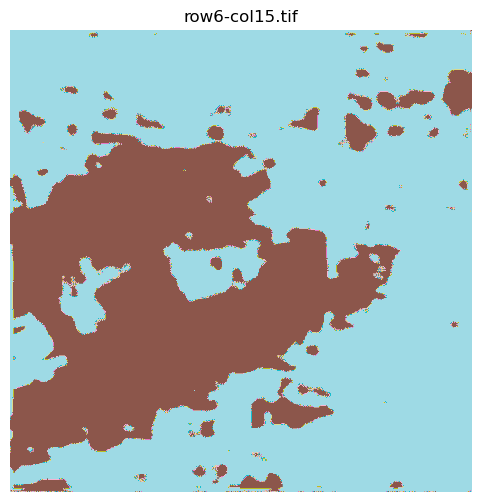

Saved: data\predict\2023\output\row6-col15_pred.tif


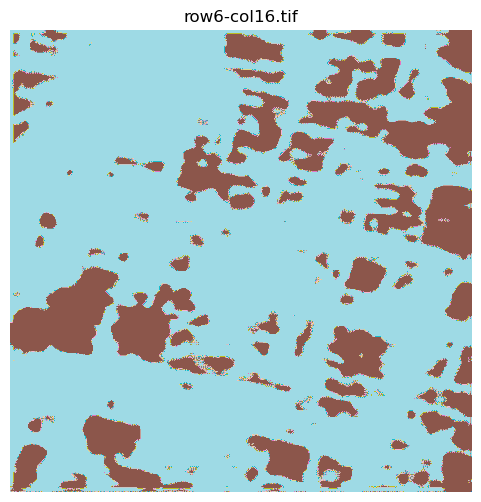

Saved: data\predict\2023\output\row6-col16_pred.tif


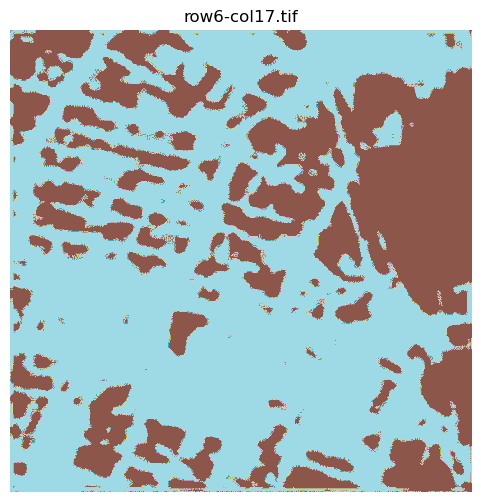

Saved: data\predict\2023\output\row6-col17_pred.tif


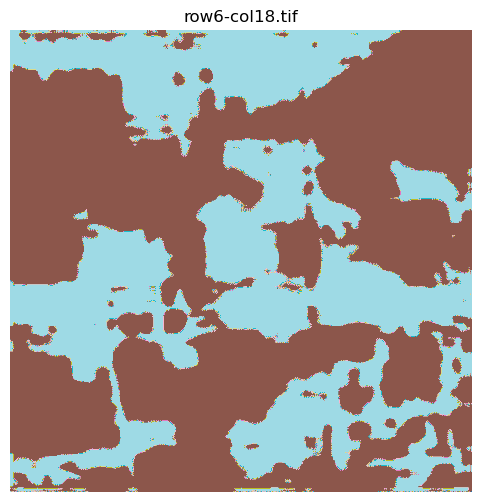

Saved: data\predict\2023\output\row6-col18_pred.tif


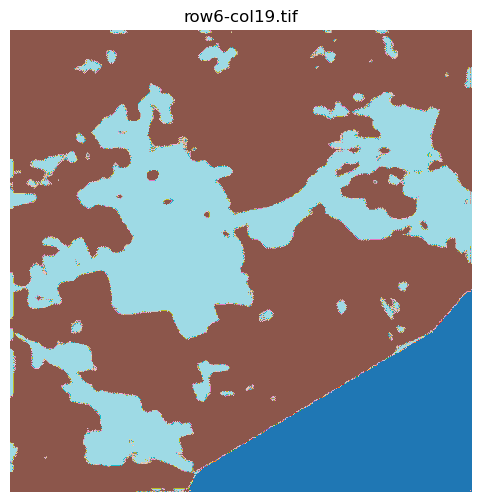

Saved: data\predict\2023\output\row6-col19_pred.tif


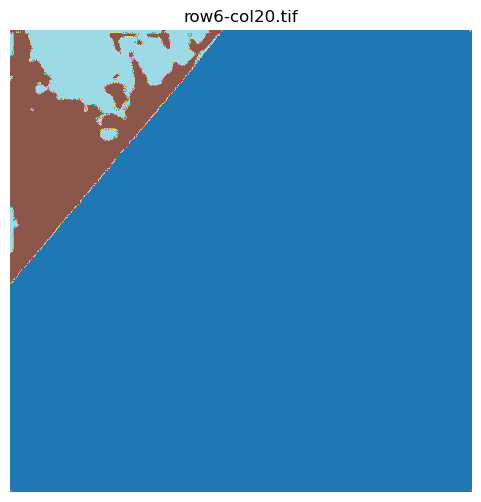

Saved: data\predict\2023\output\row6-col20_pred.tif


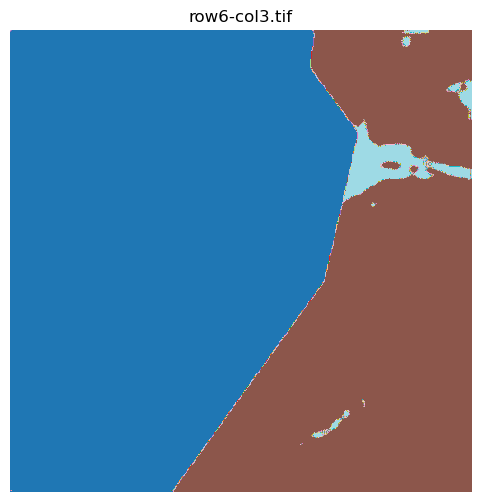

Saved: data\predict\2023\output\row6-col3_pred.tif


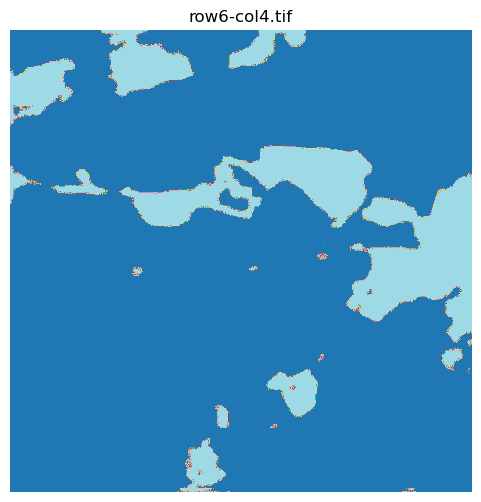

Saved: data\predict\2023\output\row6-col4_pred.tif


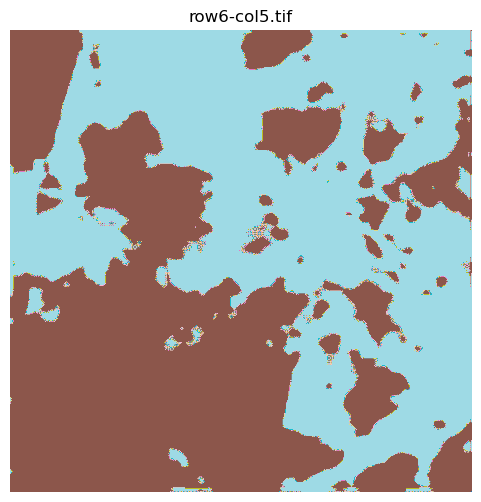

Saved: data\predict\2023\output\row6-col5_pred.tif


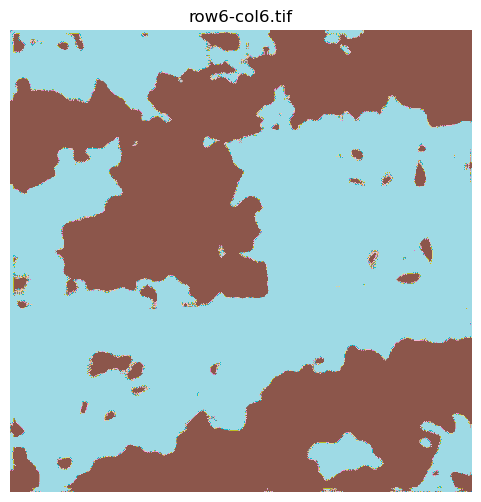

Saved: data\predict\2023\output\row6-col6_pred.tif


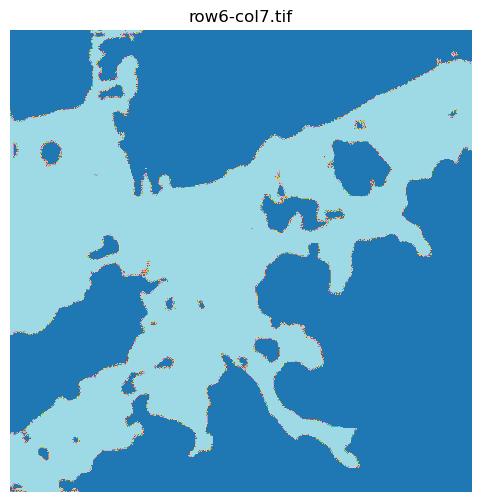

Saved: data\predict\2023\output\row6-col7_pred.tif


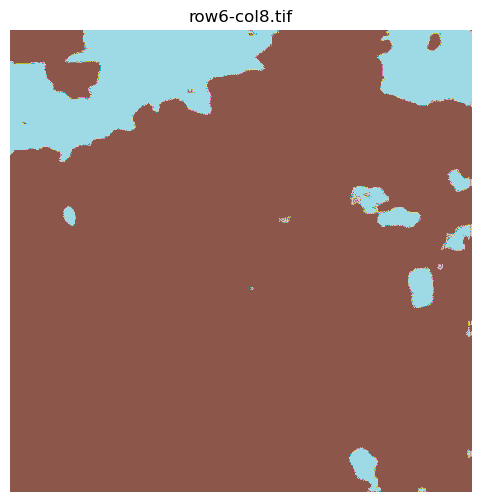

Saved: data\predict\2023\output\row6-col8_pred.tif


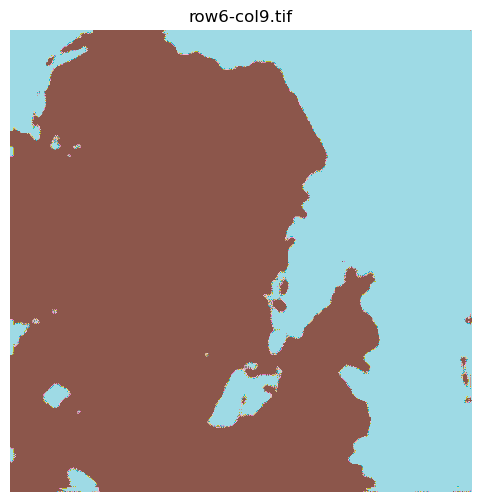

Saved: data\predict\2023\output\row6-col9_pred.tif


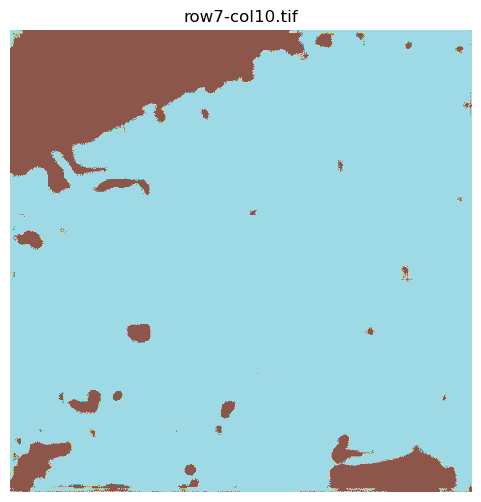

Saved: data\predict\2023\output\row7-col10_pred.tif


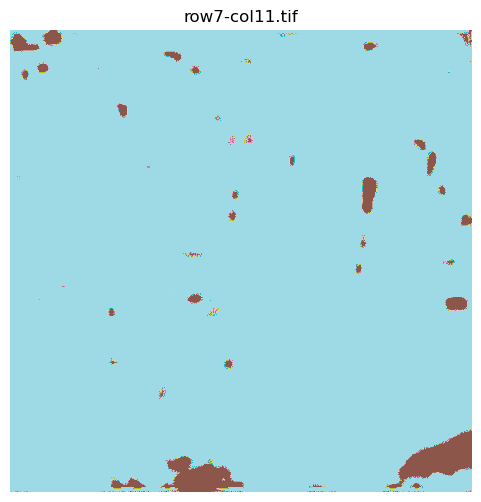

Saved: data\predict\2023\output\row7-col11_pred.tif


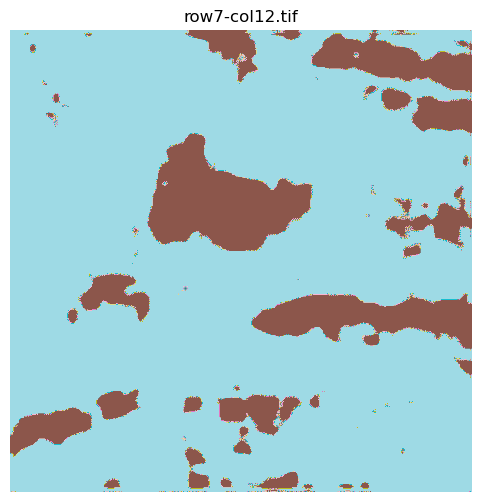

Saved: data\predict\2023\output\row7-col12_pred.tif


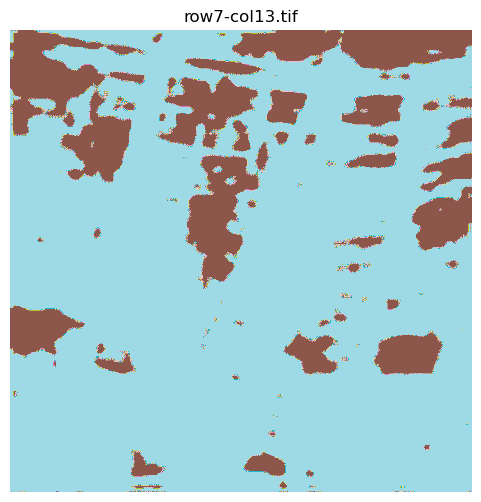

Saved: data\predict\2023\output\row7-col13_pred.tif


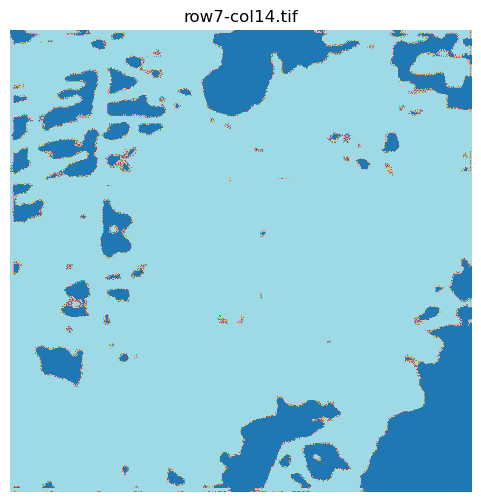

Saved: data\predict\2023\output\row7-col14_pred.tif


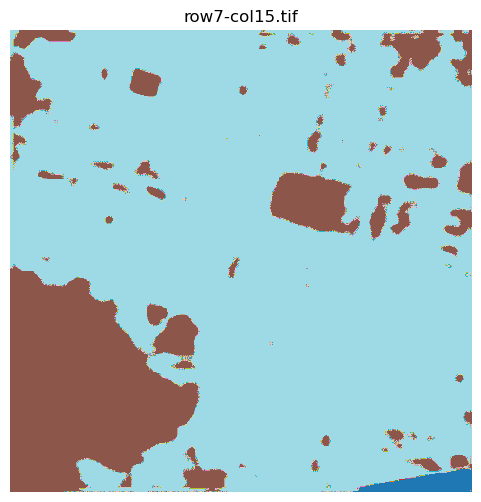

Saved: data\predict\2023\output\row7-col15_pred.tif


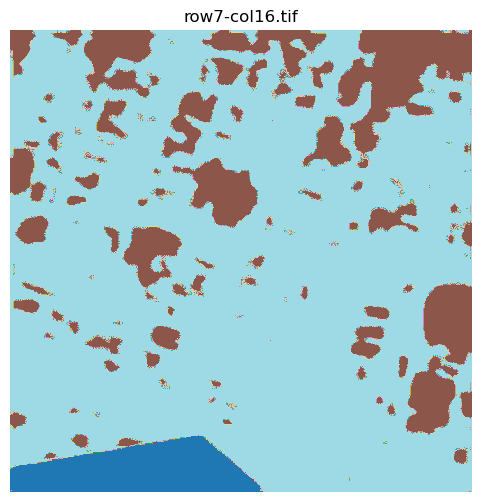

Saved: data\predict\2023\output\row7-col16_pred.tif


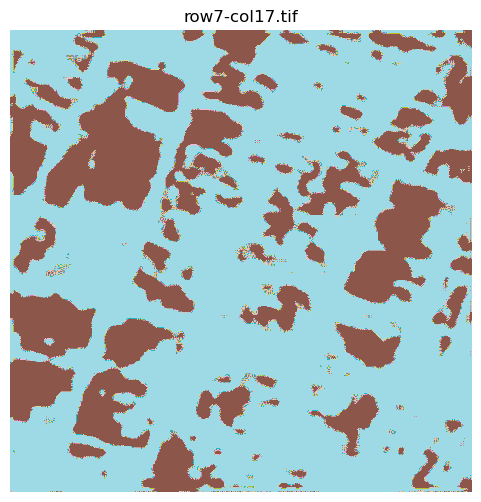

Saved: data\predict\2023\output\row7-col17_pred.tif


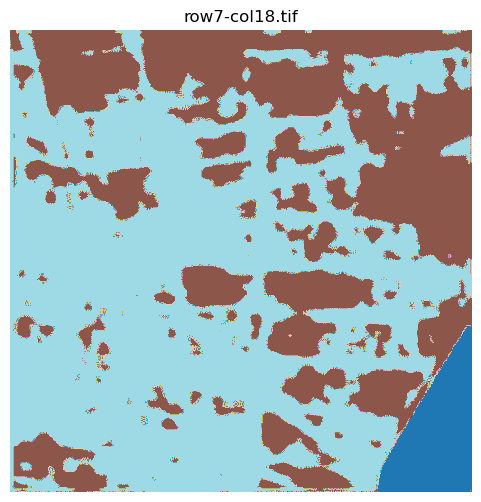

Saved: data\predict\2023\output\row7-col18_pred.tif


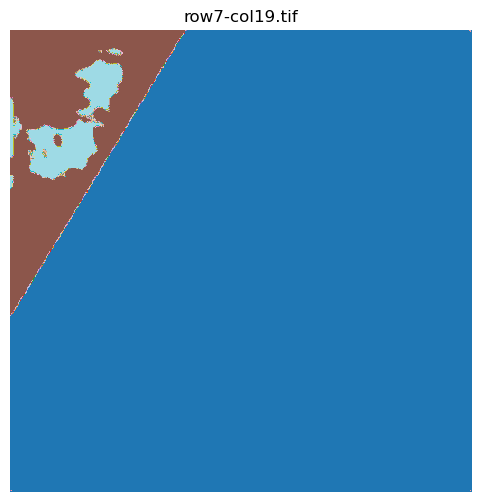

Saved: data\predict\2023\output\row7-col19_pred.tif


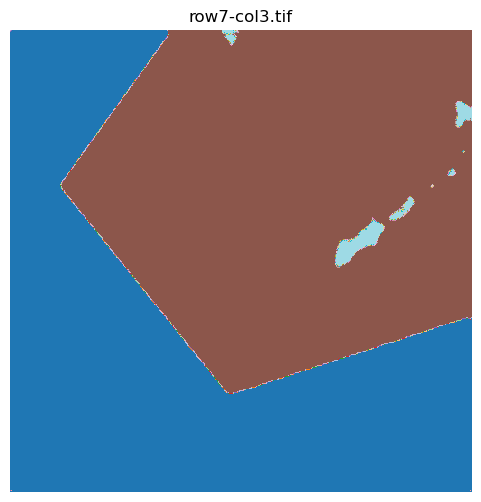

Saved: data\predict\2023\output\row7-col3_pred.tif


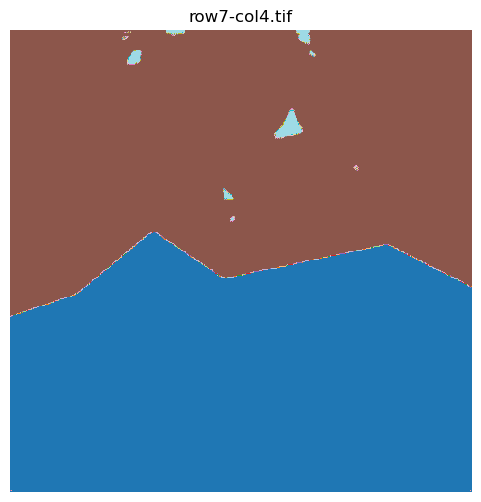

Saved: data\predict\2023\output\row7-col4_pred.tif


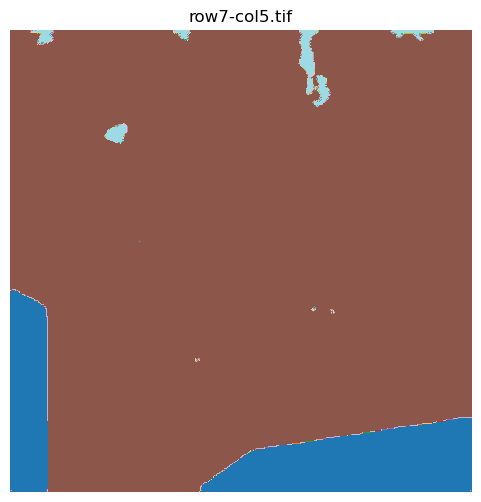

Saved: data\predict\2023\output\row7-col5_pred.tif


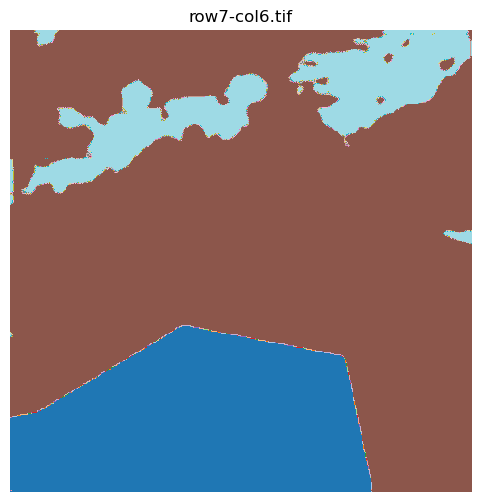

Saved: data\predict\2023\output\row7-col6_pred.tif


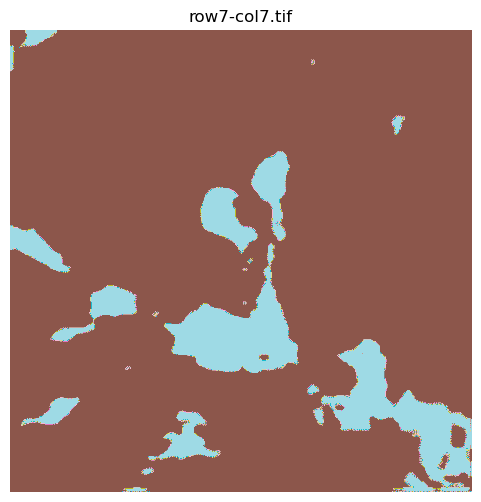

Saved: data\predict\2023\output\row7-col7_pred.tif


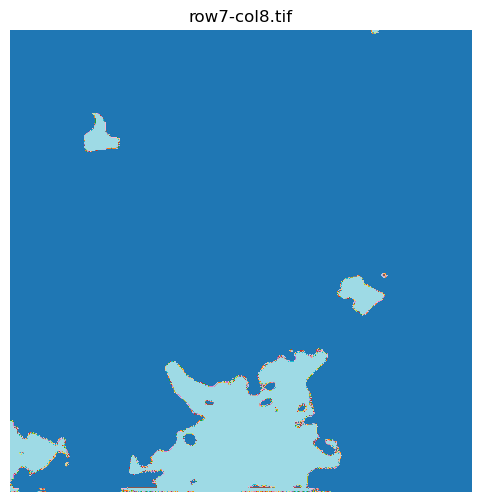

Saved: data\predict\2023\output\row7-col8_pred.tif


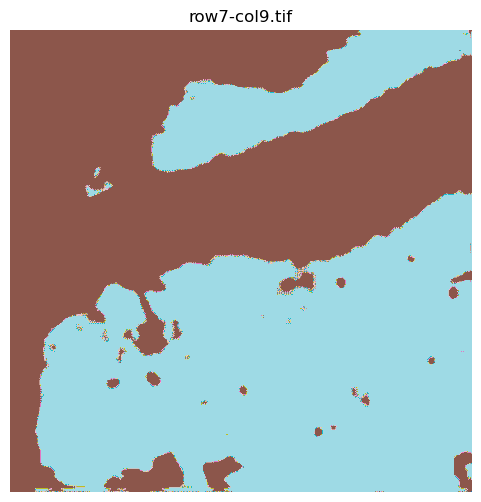

Saved: data\predict\2023\output\row7-col9_pred.tif


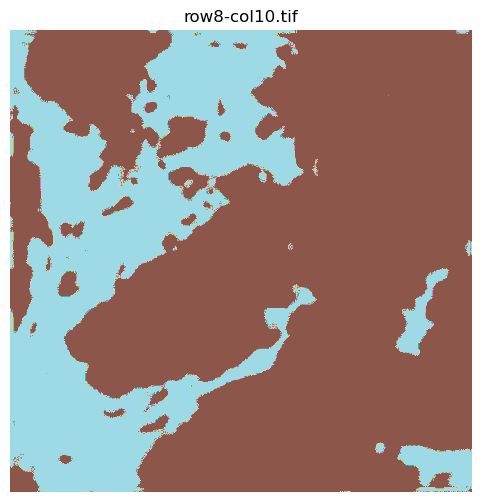

Saved: data\predict\2023\output\row8-col10_pred.tif


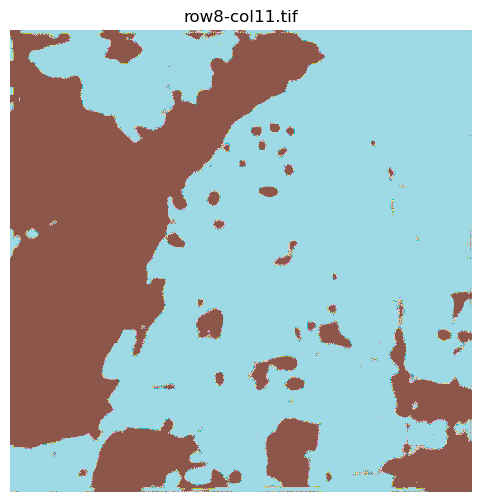

Saved: data\predict\2023\output\row8-col11_pred.tif


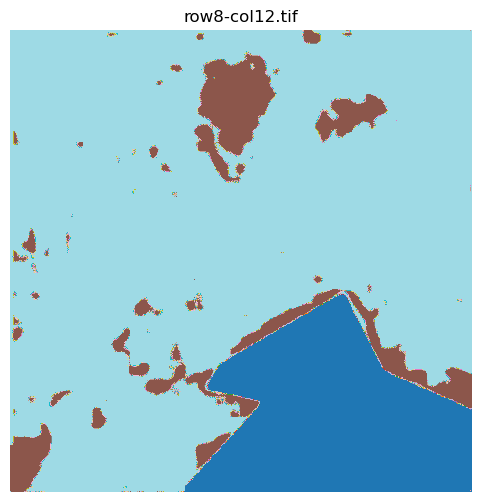

Saved: data\predict\2023\output\row8-col12_pred.tif


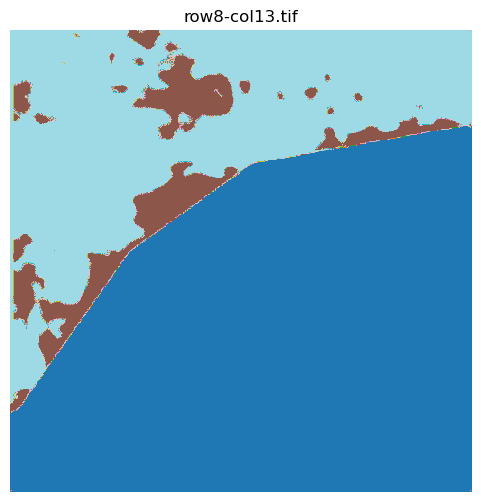

Saved: data\predict\2023\output\row8-col13_pred.tif


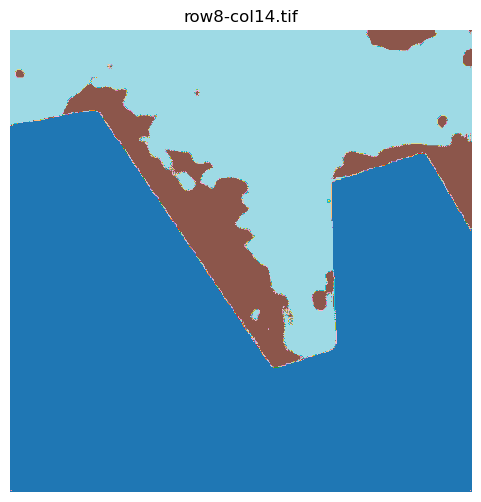

Saved: data\predict\2023\output\row8-col14_pred.tif


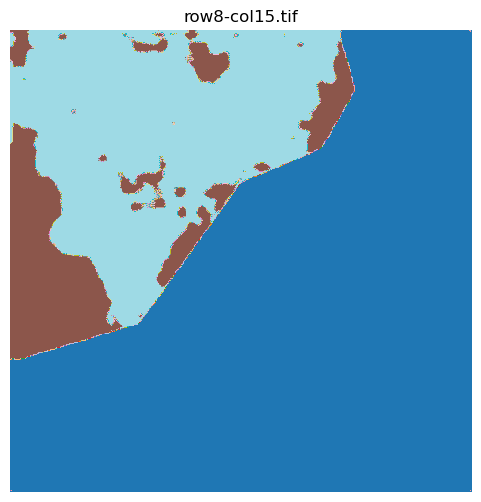

Saved: data\predict\2023\output\row8-col15_pred.tif


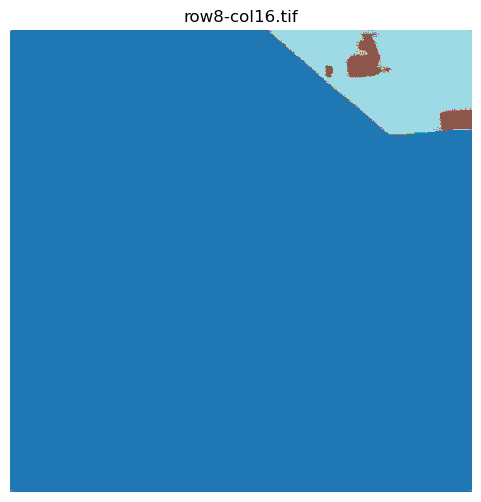

Saved: data\predict\2023\output\row8-col16_pred.tif


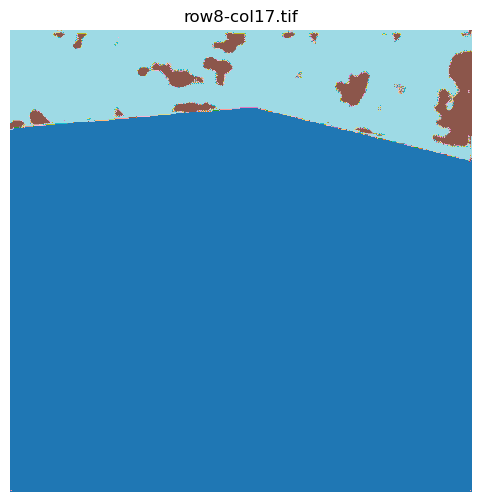

Saved: data\predict\2023\output\row8-col17_pred.tif


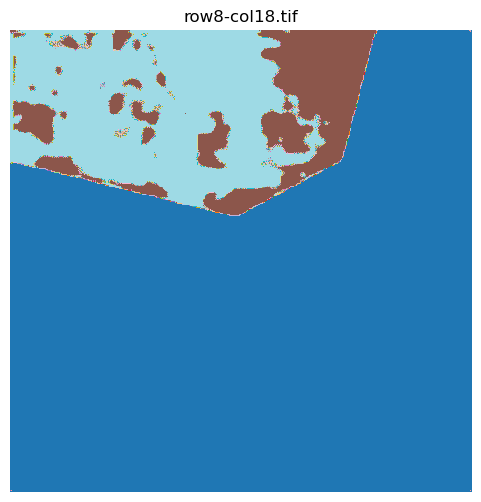

Saved: data\predict\2023\output\row8-col18_pred.tif


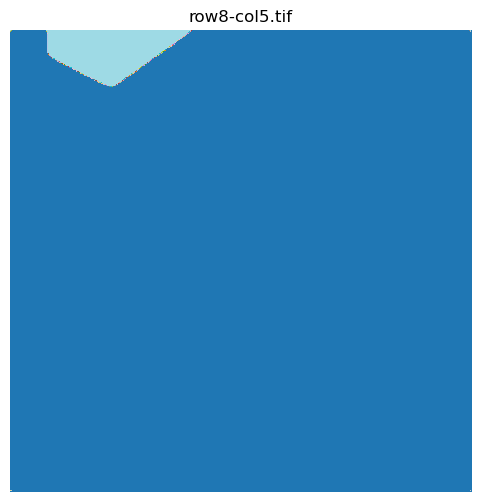

Saved: data\predict\2023\output\row8-col5_pred.tif


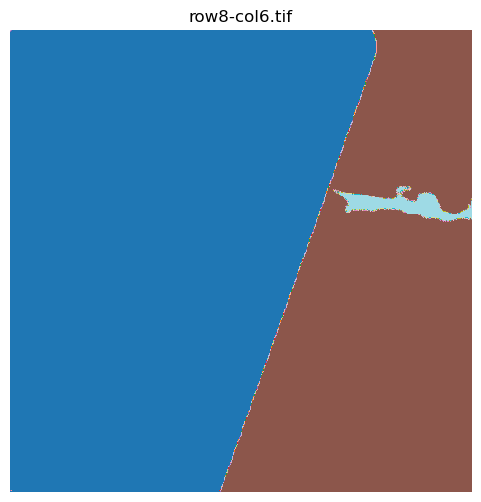

Saved: data\predict\2023\output\row8-col6_pred.tif


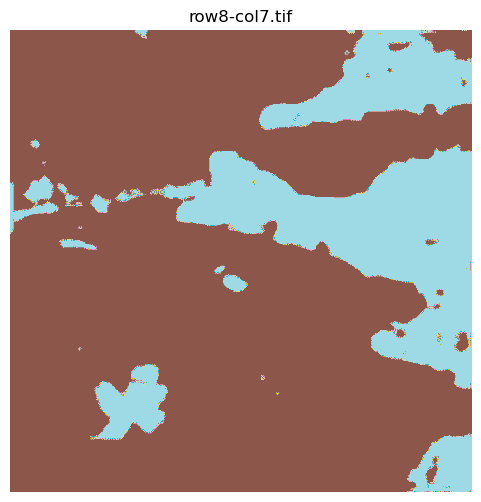

Saved: data\predict\2023\output\row8-col7_pred.tif


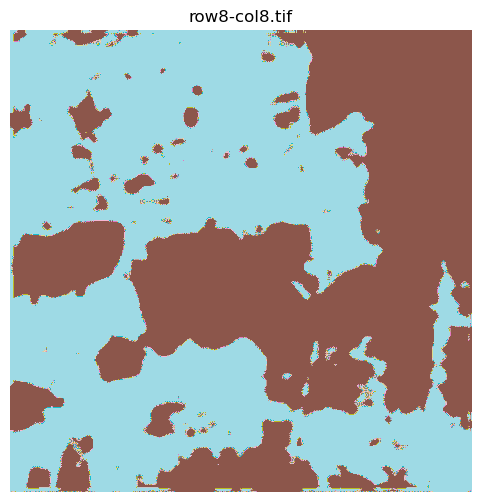

Saved: data\predict\2023\output\row8-col8_pred.tif


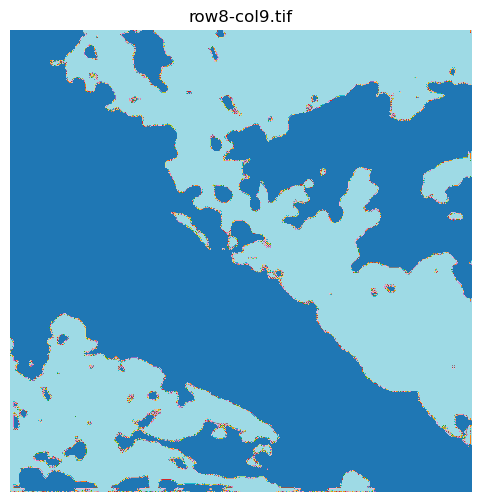

Saved: data\predict\2023\output\row8-col9_pred.tif


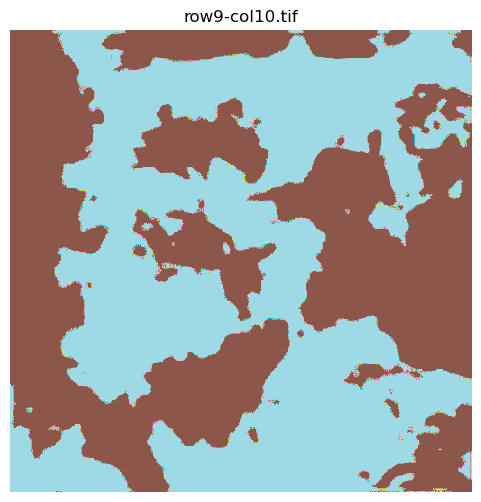

Saved: data\predict\2023\output\row9-col10_pred.tif


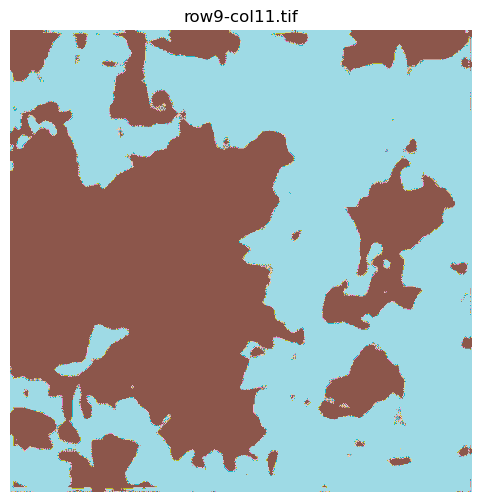

Saved: data\predict\2023\output\row9-col11_pred.tif


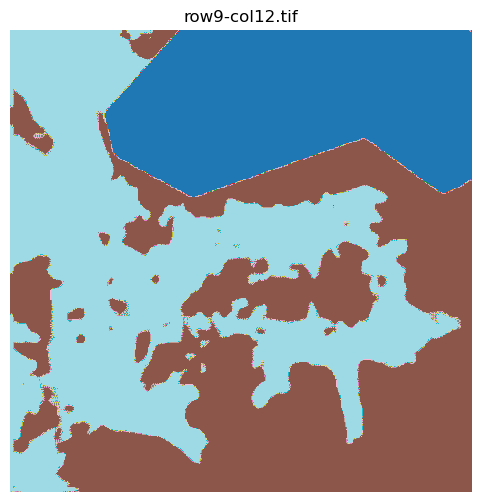

Saved: data\predict\2023\output\row9-col12_pred.tif


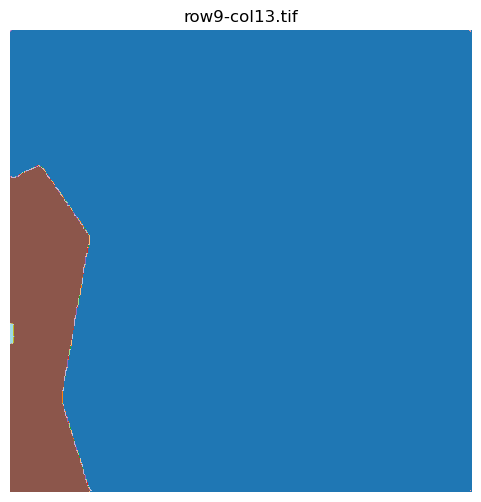

Saved: data\predict\2023\output\row9-col13_pred.tif


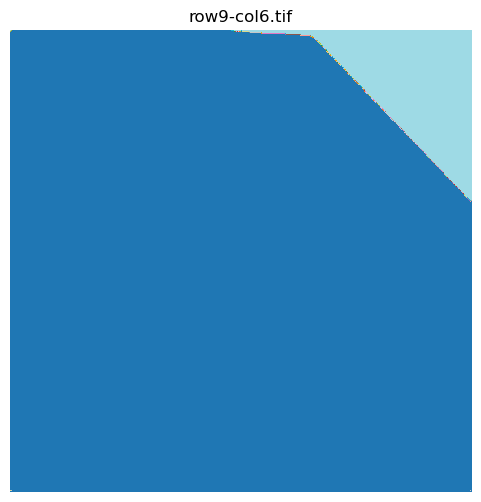

Saved: data\predict\2023\output\row9-col6_pred.tif


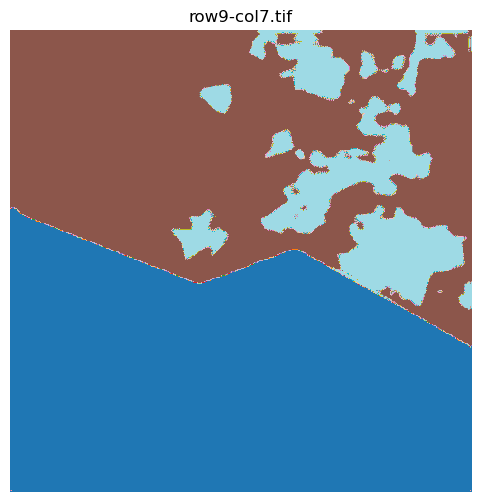

Saved: data\predict\2023\output\row9-col7_pred.tif


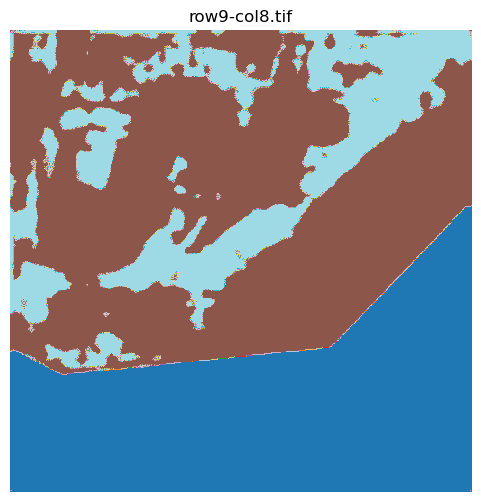

Saved: data\predict\2023\output\row9-col8_pred.tif


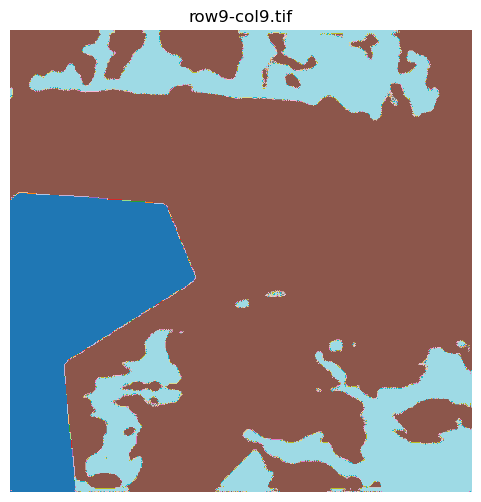

Saved: data\predict\2023\output\row9-col9_pred.tif


In [8]:
import os
from pathlib import Path
import torch
import numpy as np
import rasterio
from rasterio.transform import from_origin
from skimage import transform
import matplotlib.pyplot as plt
import torch.nn.functional as F  # 用于 softmax

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNET(4, 3).to(device)  # 输入4通道，输出3类（根据你的实际类别数修改）
model.load_state_dict(torch.load('unet_third_model.pth', map_location=device))
model.eval()

def preprocess(img):
    img = transform.resize(img, (4, 512, 512), preserve_range=True).astype(np.float32)
    img = img / 10000.0
    return torch.tensor(img, dtype=torch.float32).unsqueeze(0)

def visualize_prediction(pred_class, title="Prediction"):
    plt.figure(figsize=(6, 6))
    plt.imshow(pred_class, cmap='tab20')
    plt.title(title)
    plt.axis('off')
    plt.show()

def predict_folder(input_folder, output_folder, visualize=False):
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    for tif_path in input_folder.glob('*.tif'):
        with rasterio.open(tif_path) as src:
            img = src.read()  # (5, H, W)
            img = img[[1, 2, 3, 4], :, :]  # B3, B4, B8, B11
            transform_meta = src.transform
            crs_meta = src.crs

        img_tensor = preprocess(img).to(device)

        with torch.no_grad():
            pred = model(img_tensor)              # 输出形状: [1, C, H, W]
            pred_soft = F.softmax(pred[0], dim=0) # 取 batch[0]，然后对类别维做 softmax
            pred_class = torch.argmax(pred_soft, dim=0).cpu().numpy().astype(np.uint8)  # [H, W]

        if visualize:
            visualize_prediction(pred_class, title=tif_path.name)

        out_path = output_folder / tif_path.name.replace('.tif', '_pred.tif')
        with rasterio.open(
            out_path,
            'w',
            driver='GTiff',
            height=pred_class.shape[0],
            width=pred_class.shape[1],
            count=1,
            dtype=np.uint8,
            crs=crs_meta,
            transform=transform_meta
        ) as dst:
            dst.write(pred_class, 1)

        print(f"Saved: {out_path}")

# 用法示例（运行前请确认路径）
predict_folder('data/predict/2023/raw', 'data/predict/2023/output', visualize=True)

In [9]:
import os
import rasterio
from rasterio.merge import merge
from tqdm import tqdm

input_folder = 'data/predict/2023/output'
output_file = 'data/lu2023_pred3.tif'
target_crs = 'EPSG:4326'

tif_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.tif')]

src_files_to_mosaic = []
for tif_path in tqdm(tif_files, desc="Opening tiles"):
    with rasterio.open(tif_path) as src:
        if src.crs is None or src.transform is None:
            raise ValueError(f"❌ {tif_path} is missing CRS or transform!")
    src_files_to_mosaic.append(rasterio.open(tif_path))

mosaic, out_trans = merge(src_files_to_mosaic)

out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": target_crs,
    "compress": "lzw",
    "BIGTIFF": "YES"
})

with rasterio.open(output_file, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"\n✅ Mosaic complete! Output saved to: {output_file}")

Opening tiles: 100%|█████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 36.10it/s]



✅ Mosaic complete! Output saved to: data/lu2023_pred3.tif


In [10]:
# predict 2018

In [11]:
naip_file = 'data/naip2018.tif'

# configure the training data folder
folder1 = 'data/predict/2018/raw'
if not os.path.exists(folder1):
    os.makedirs(folder1)

tile_width = 512
tile_height = 512

raster2tiles(naip_file, tile_width, tile_height, folder1)

The i and j is: 0 0
The i and j is: 0 1
The i and j is: 0 2
The i and j is: 0 3
The i and j is: 0 4
The i and j is: 0 5
The i and j is: 0 6
The i and j is: 0 7
The i and j is: 0 8
The i and j is: 0 9
The i and j is: 0 10
The i and j is: 0 11
The i and j is: 0 12
The i and j is: 0 13
The i and j is: 0 14
The i and j is: 0 15
The i and j is: 0 16
The i and j is: 0 17
The i and j is: 0 18
The i and j is: 0 19
The i and j is: 0 20
The i and j is: 1 0
The i and j is: 1 1
The i and j is: 1 2
The i and j is: 1 3
The i and j is: 1 4
The i and j is: 1 5
The i and j is: 1 6
The i and j is: 1 7
The i and j is: 1 8
The i and j is: 1 9
The i and j is: 1 10
The i and j is: 1 11
The i and j is: 1 12
The i and j is: 1 13
The i and j is: 1 14
The i and j is: 1 15
The i and j is: 1 16
The i and j is: 1 17
The i and j is: 1 18
The i and j is: 1 19
The i and j is: 1 20
The i and j is: 2 0
The i and j is: 2 1
The i and j is: 2 2
The i and j is: 2 3
The i and j is: 2 4
The i and j is: 2 5
The i and j is: 2 

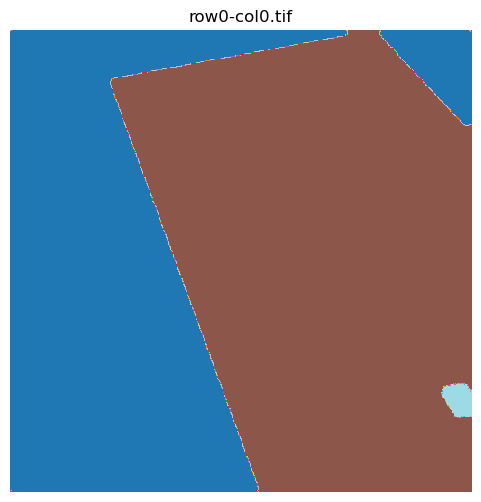

Saved: data\predict\2018\output\row0-col0_pred.tif


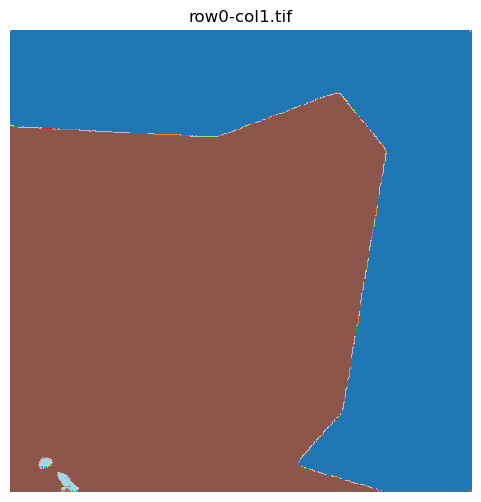

Saved: data\predict\2018\output\row0-col1_pred.tif


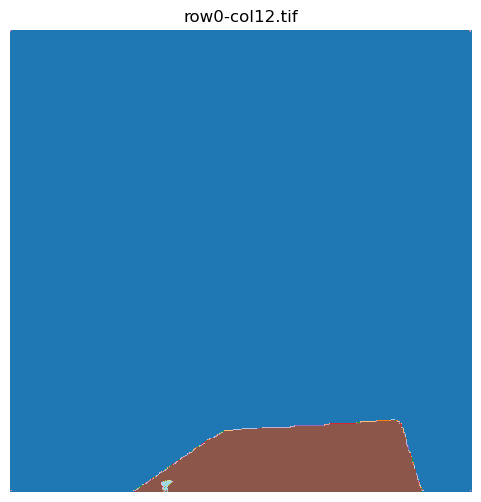

Saved: data\predict\2018\output\row0-col12_pred.tif


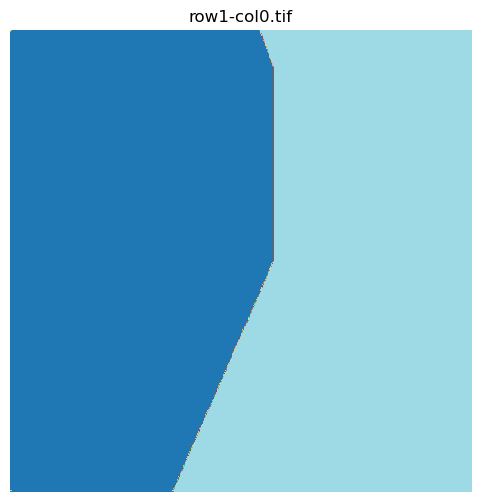

Saved: data\predict\2018\output\row1-col0_pred.tif


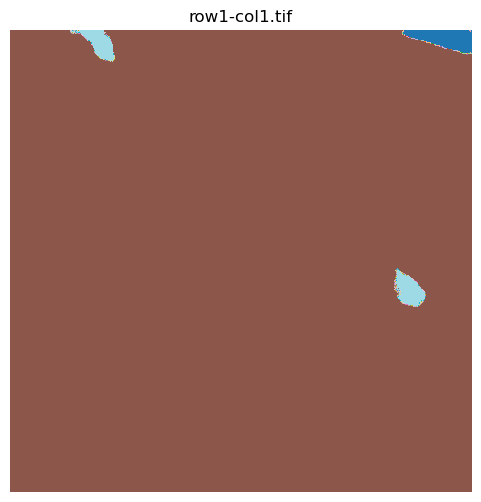

Saved: data\predict\2018\output\row1-col1_pred.tif


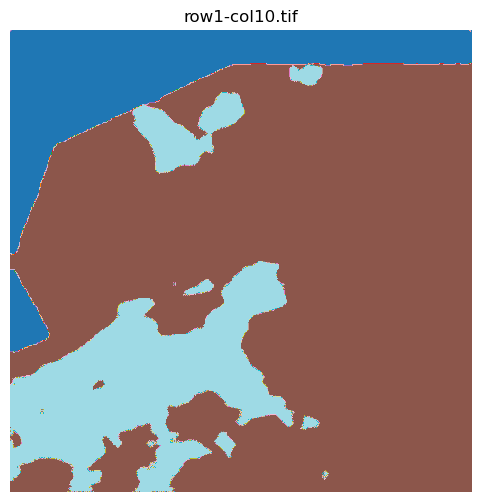

Saved: data\predict\2018\output\row1-col10_pred.tif


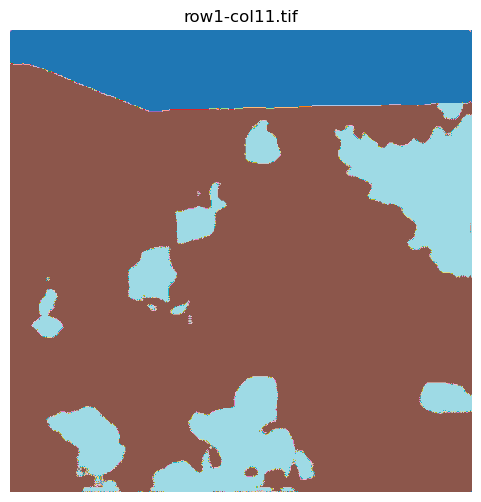

Saved: data\predict\2018\output\row1-col11_pred.tif


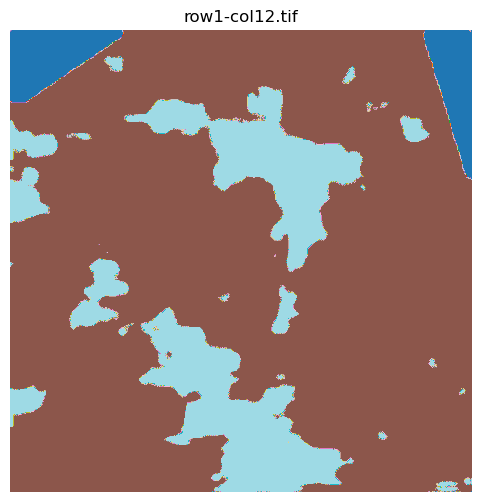

Saved: data\predict\2018\output\row1-col12_pred.tif


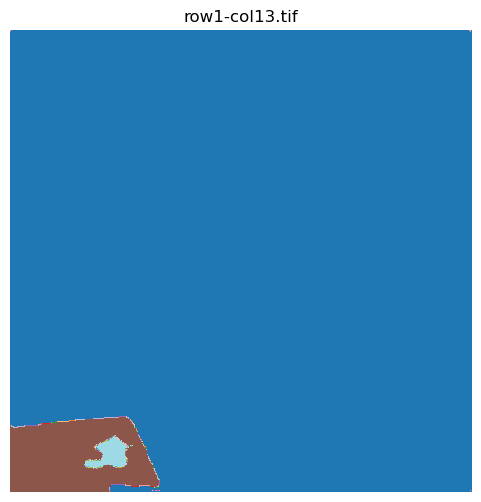

Saved: data\predict\2018\output\row1-col13_pred.tif


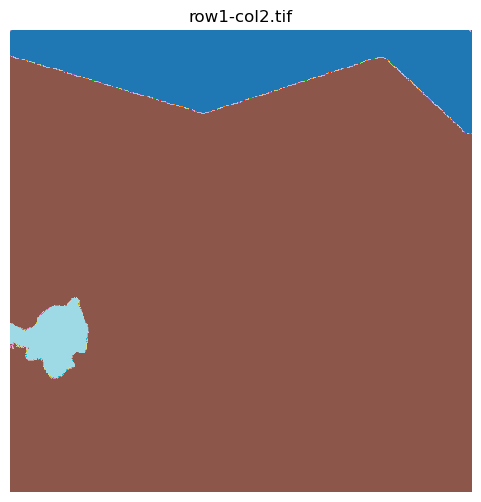

Saved: data\predict\2018\output\row1-col2_pred.tif


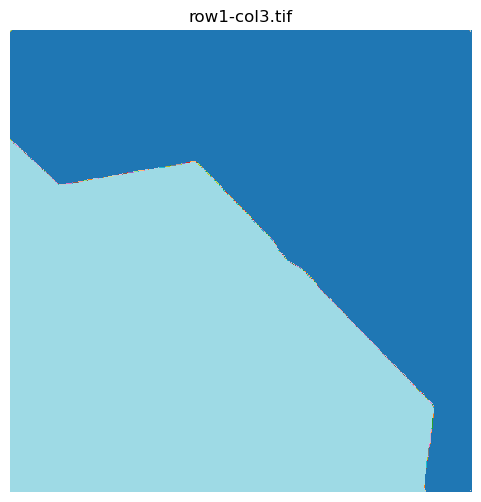

Saved: data\predict\2018\output\row1-col3_pred.tif


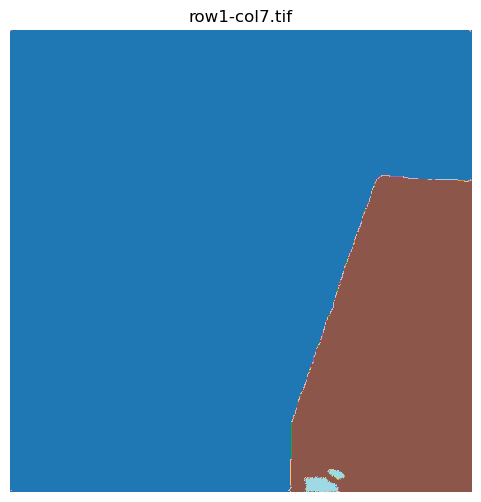

Saved: data\predict\2018\output\row1-col7_pred.tif


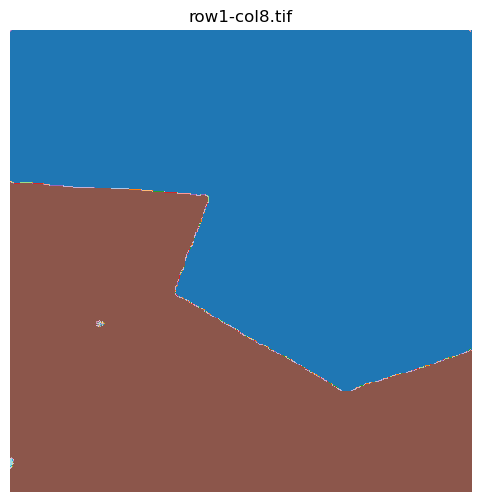

Saved: data\predict\2018\output\row1-col8_pred.tif


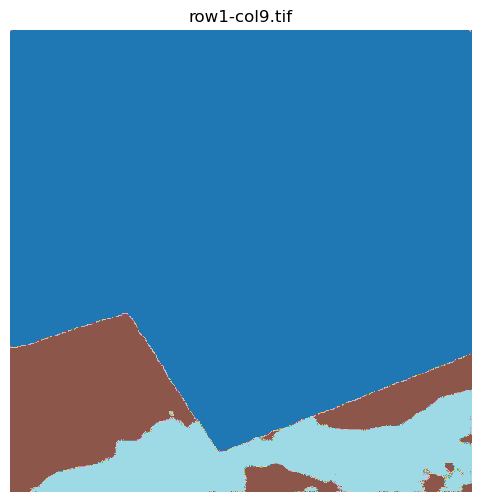

Saved: data\predict\2018\output\row1-col9_pred.tif


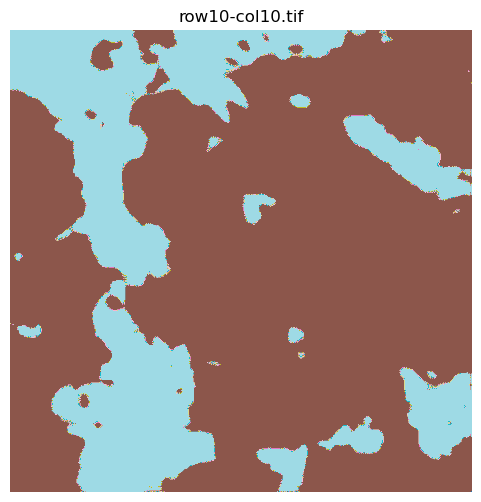

Saved: data\predict\2018\output\row10-col10_pred.tif


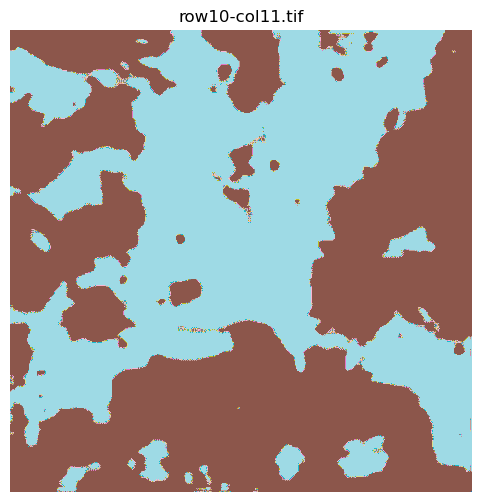

Saved: data\predict\2018\output\row10-col11_pred.tif


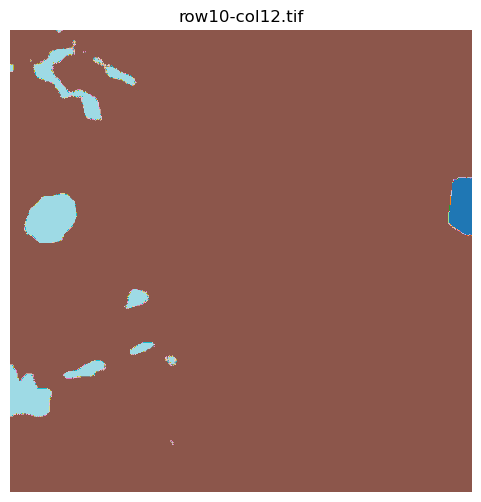

Saved: data\predict\2018\output\row10-col12_pred.tif


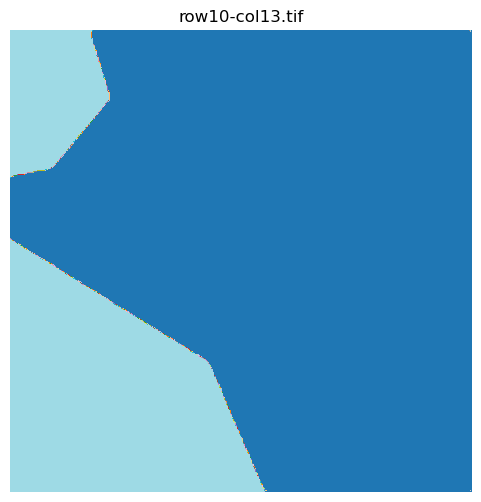

Saved: data\predict\2018\output\row10-col13_pred.tif


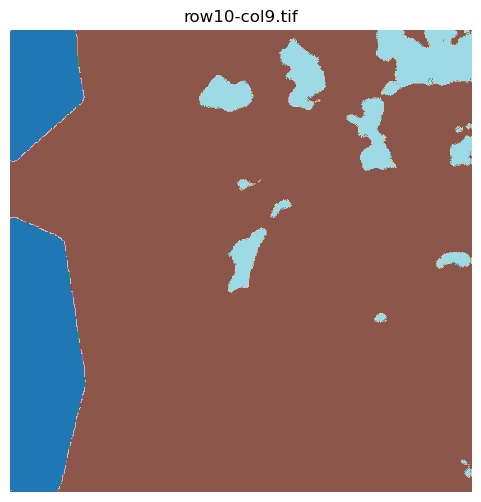

Saved: data\predict\2018\output\row10-col9_pred.tif


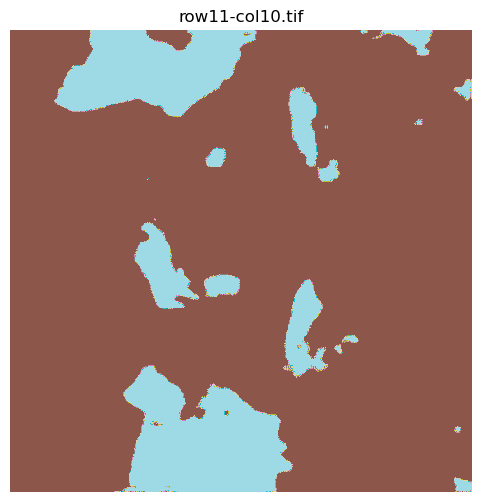

Saved: data\predict\2018\output\row11-col10_pred.tif


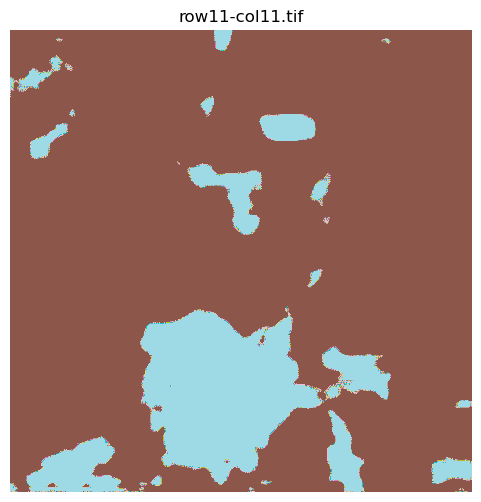

Saved: data\predict\2018\output\row11-col11_pred.tif


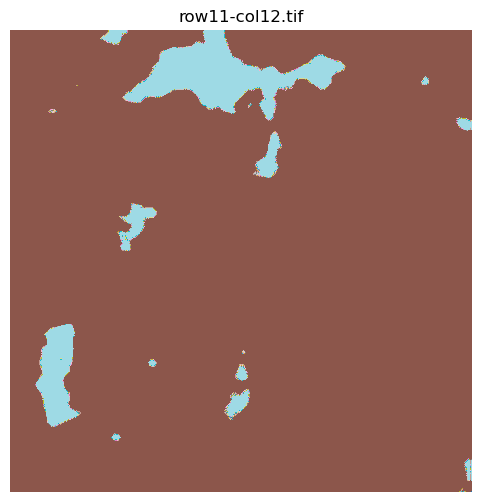

Saved: data\predict\2018\output\row11-col12_pred.tif


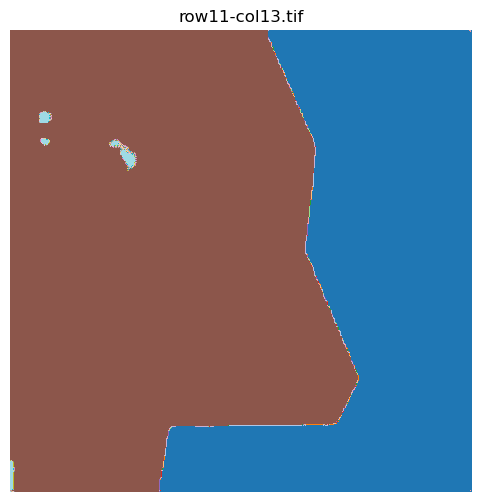

Saved: data\predict\2018\output\row11-col13_pred.tif


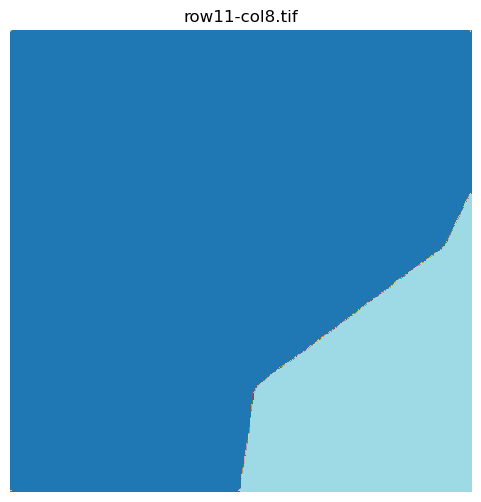

Saved: data\predict\2018\output\row11-col8_pred.tif


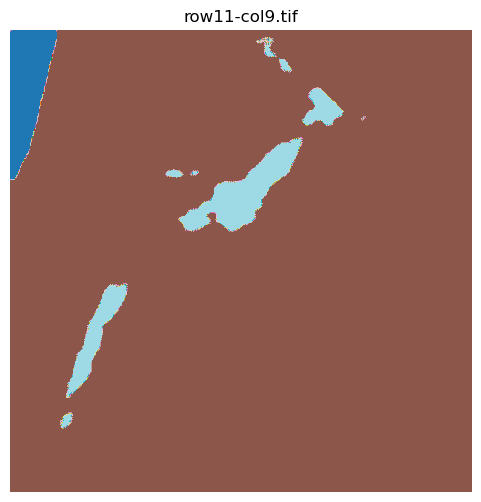

Saved: data\predict\2018\output\row11-col9_pred.tif


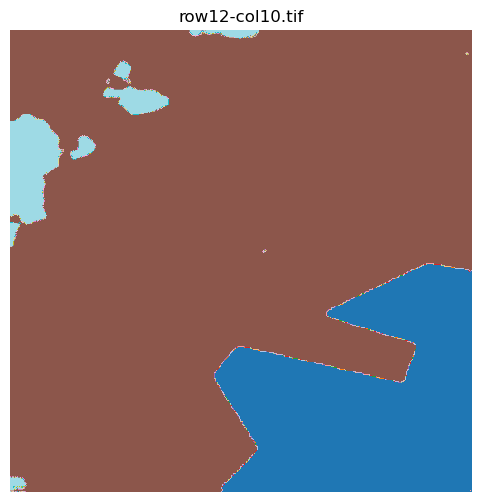

Saved: data\predict\2018\output\row12-col10_pred.tif


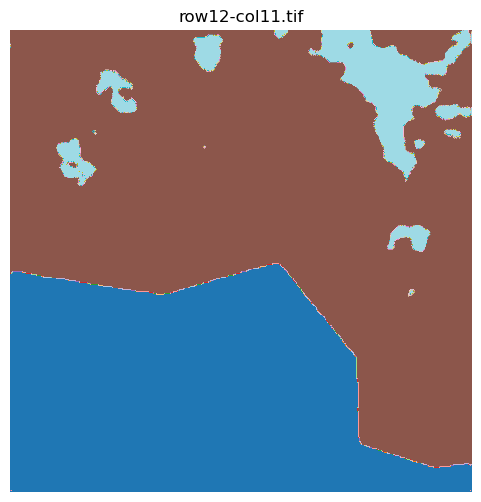

Saved: data\predict\2018\output\row12-col11_pred.tif


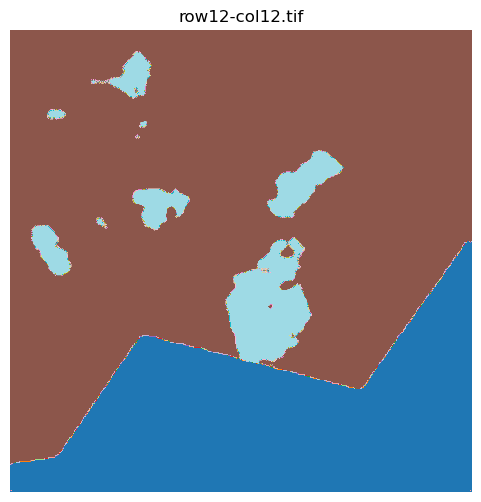

Saved: data\predict\2018\output\row12-col12_pred.tif


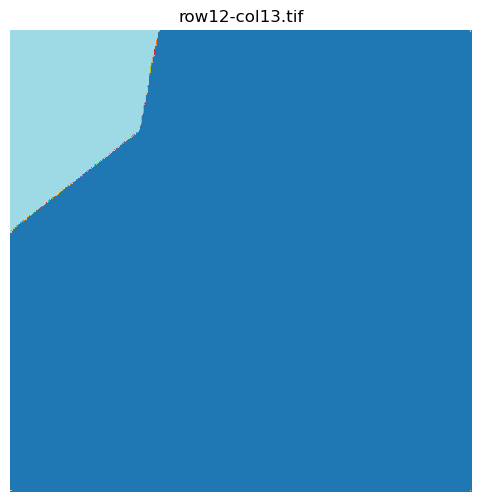

Saved: data\predict\2018\output\row12-col13_pred.tif


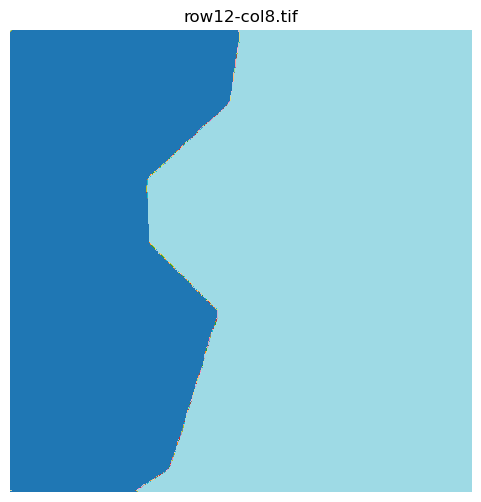

Saved: data\predict\2018\output\row12-col8_pred.tif


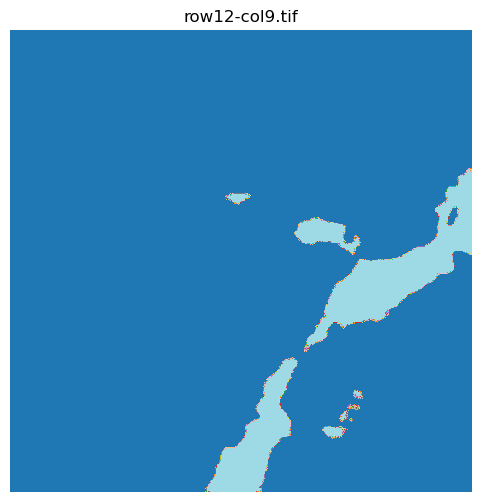

Saved: data\predict\2018\output\row12-col9_pred.tif


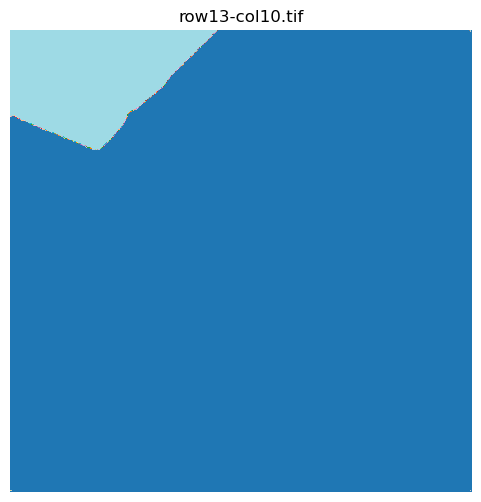

Saved: data\predict\2018\output\row13-col10_pred.tif


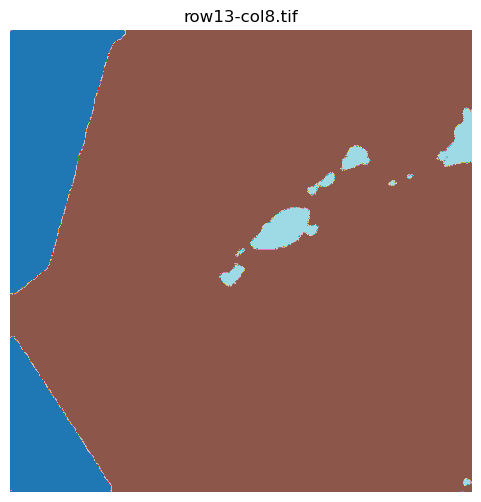

Saved: data\predict\2018\output\row13-col8_pred.tif


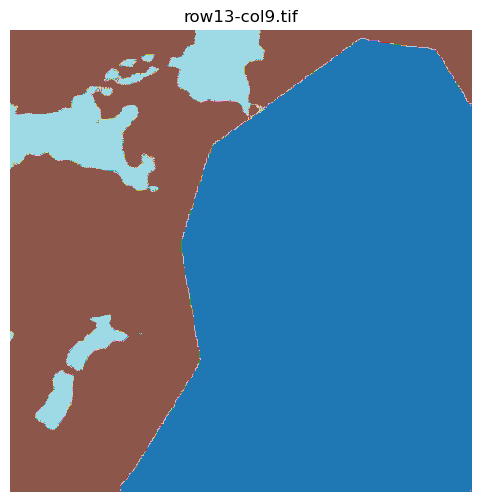

Saved: data\predict\2018\output\row13-col9_pred.tif


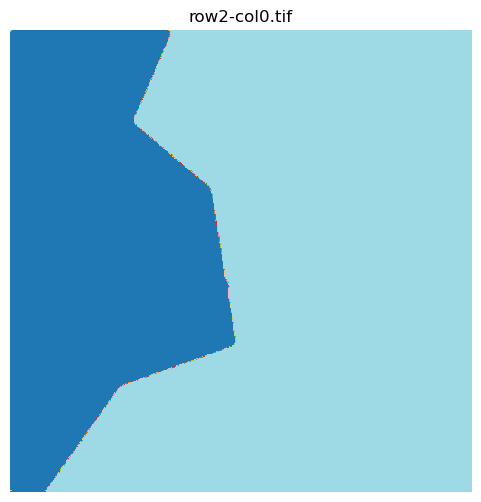

Saved: data\predict\2018\output\row2-col0_pred.tif


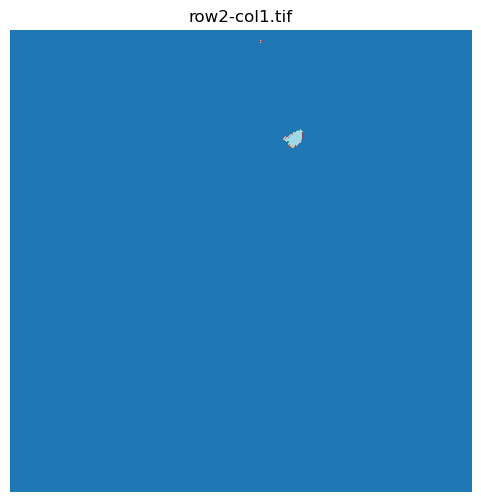

Saved: data\predict\2018\output\row2-col1_pred.tif


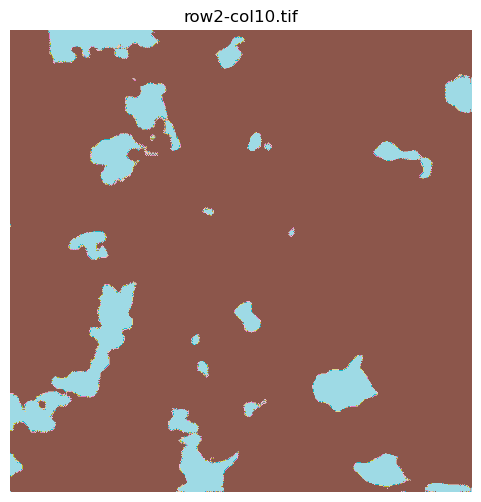

Saved: data\predict\2018\output\row2-col10_pred.tif


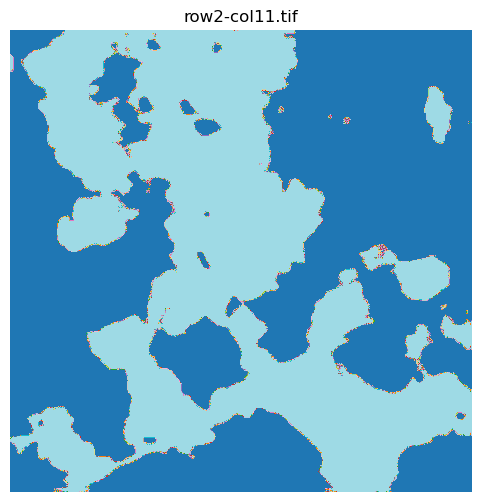

Saved: data\predict\2018\output\row2-col11_pred.tif


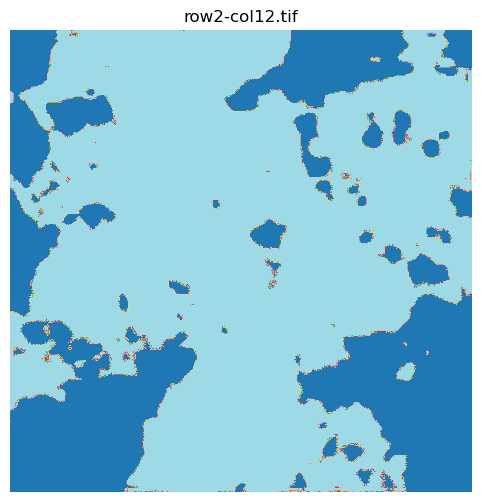

Saved: data\predict\2018\output\row2-col12_pred.tif


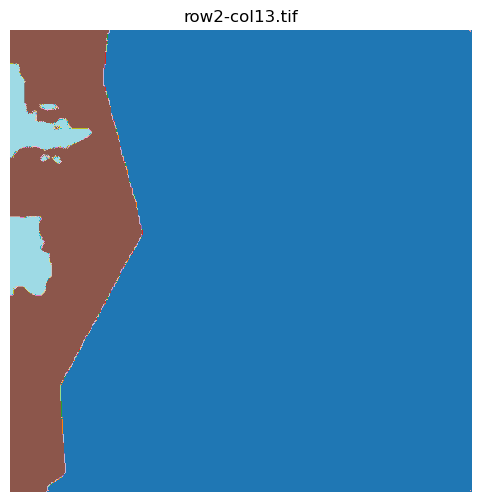

Saved: data\predict\2018\output\row2-col13_pred.tif


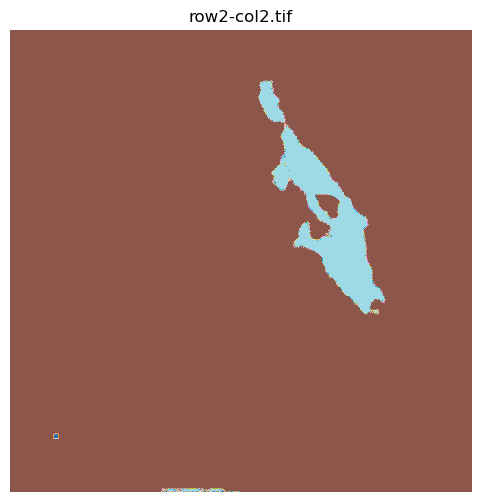

Saved: data\predict\2018\output\row2-col2_pred.tif


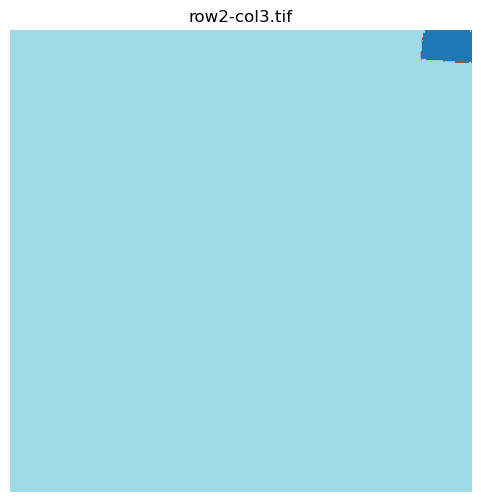

Saved: data\predict\2018\output\row2-col3_pred.tif


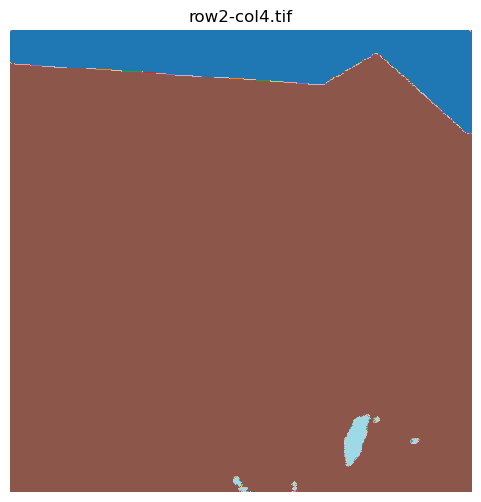

Saved: data\predict\2018\output\row2-col4_pred.tif


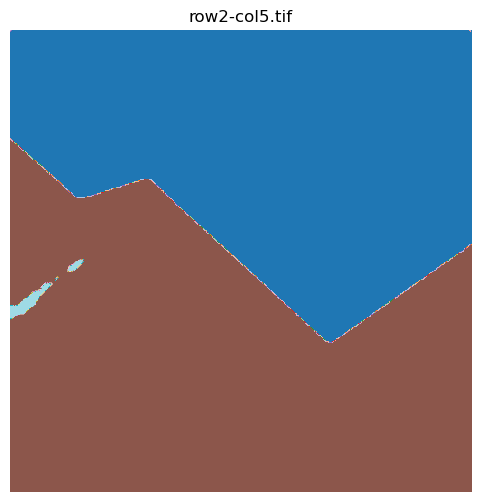

Saved: data\predict\2018\output\row2-col5_pred.tif


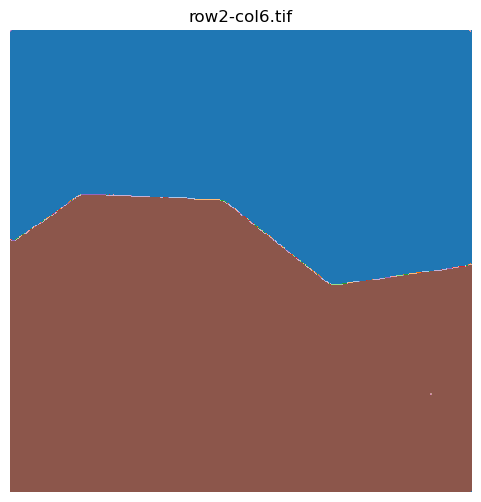

Saved: data\predict\2018\output\row2-col6_pred.tif


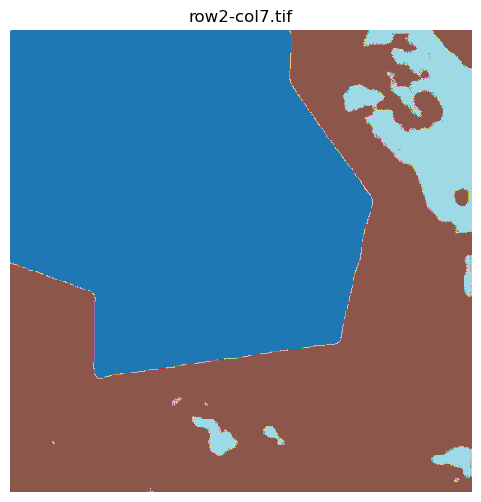

Saved: data\predict\2018\output\row2-col7_pred.tif


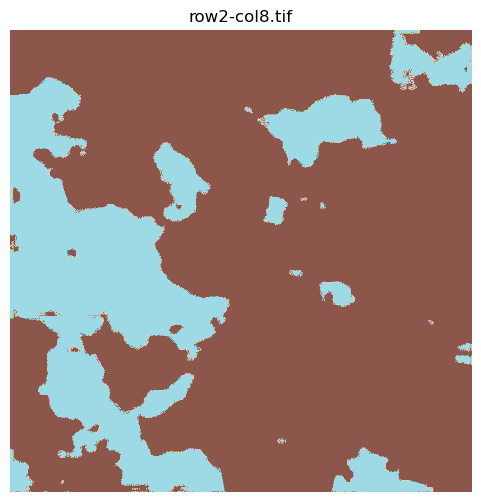

Saved: data\predict\2018\output\row2-col8_pred.tif


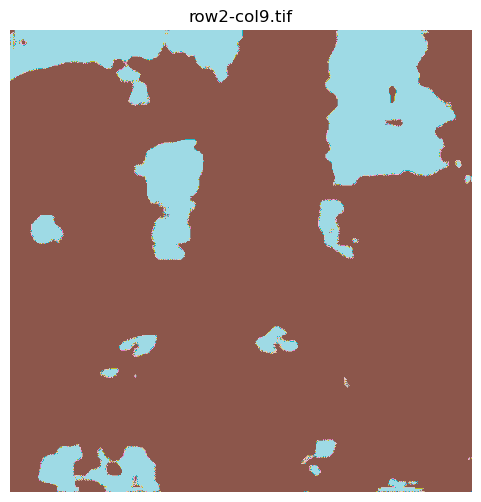

Saved: data\predict\2018\output\row2-col9_pred.tif


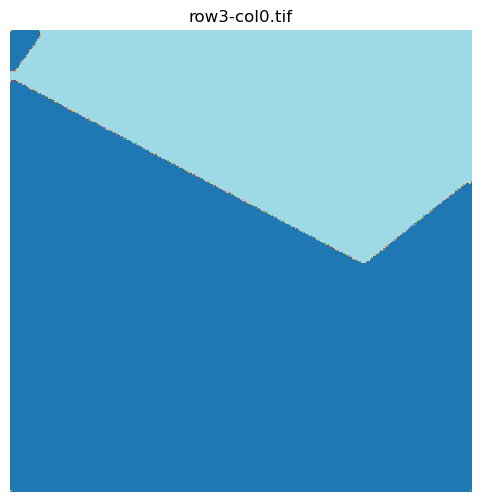

Saved: data\predict\2018\output\row3-col0_pred.tif


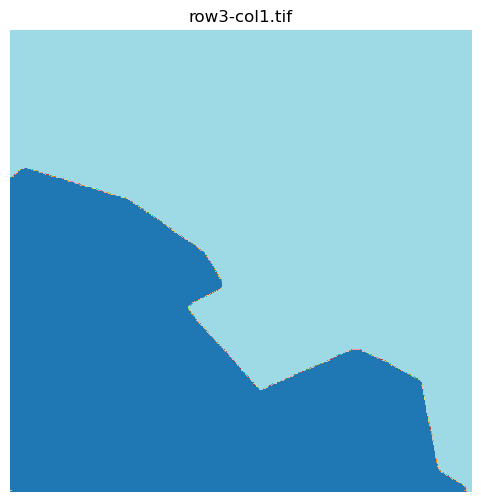

Saved: data\predict\2018\output\row3-col1_pred.tif


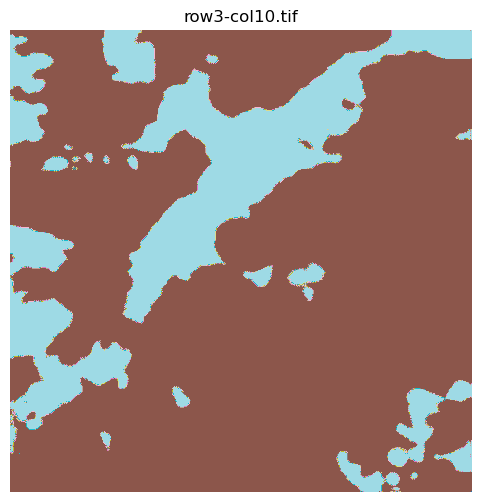

Saved: data\predict\2018\output\row3-col10_pred.tif


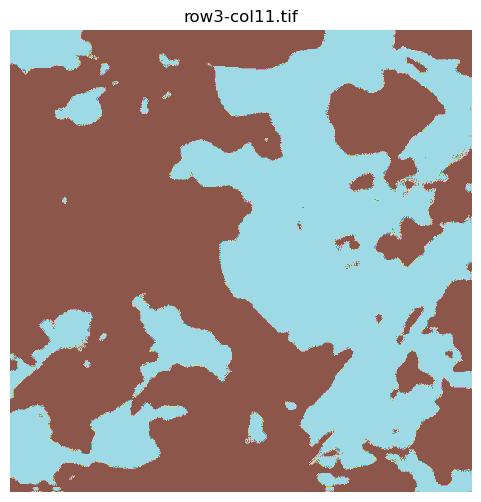

Saved: data\predict\2018\output\row3-col11_pred.tif


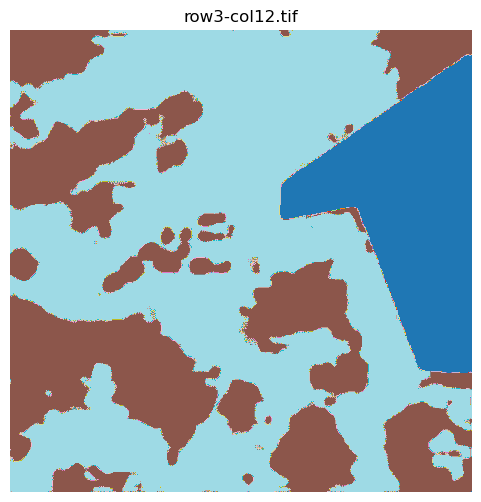

Saved: data\predict\2018\output\row3-col12_pred.tif


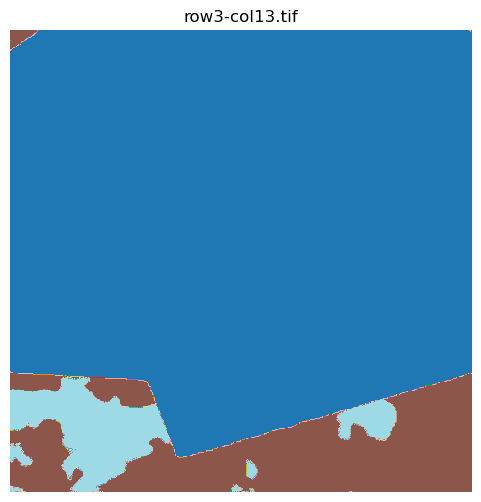

Saved: data\predict\2018\output\row3-col13_pred.tif


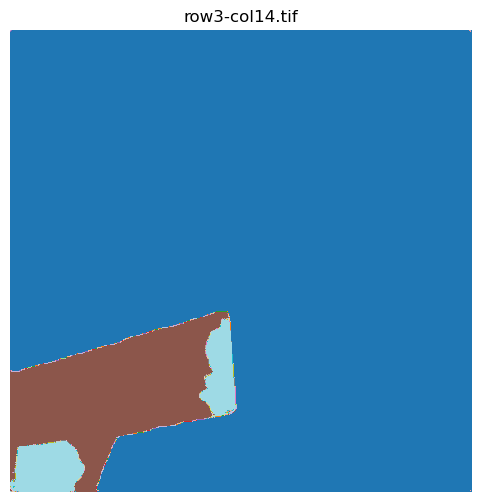

Saved: data\predict\2018\output\row3-col14_pred.tif


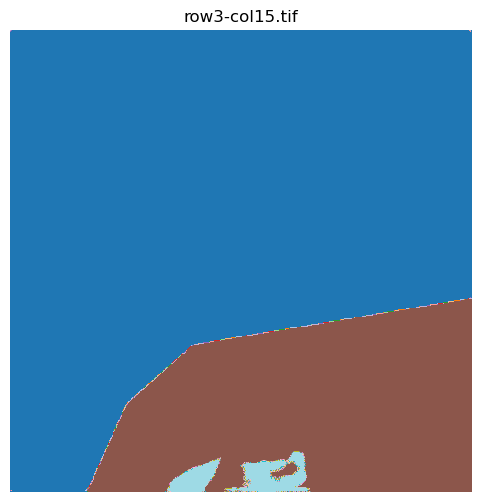

Saved: data\predict\2018\output\row3-col15_pred.tif


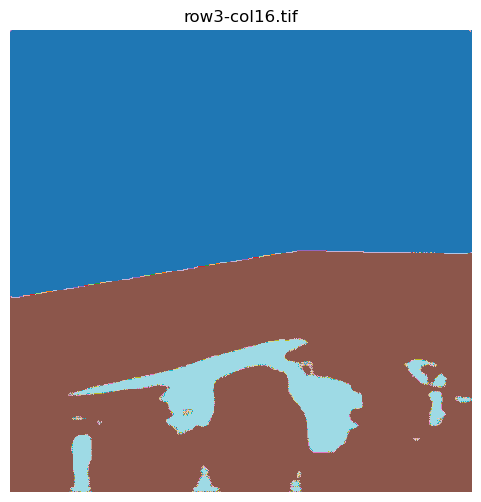

Saved: data\predict\2018\output\row3-col16_pred.tif


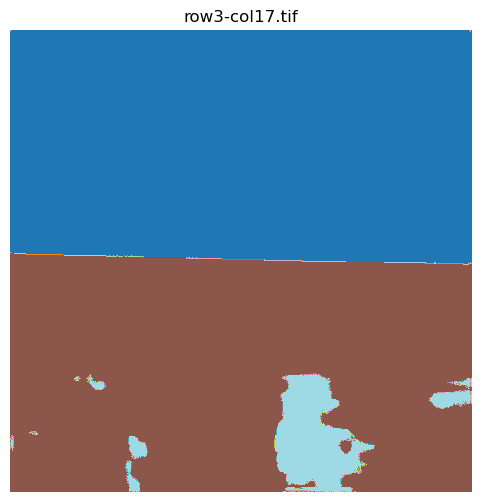

Saved: data\predict\2018\output\row3-col17_pred.tif


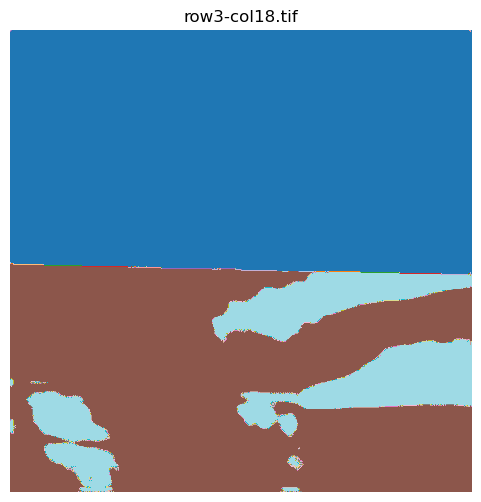

Saved: data\predict\2018\output\row3-col18_pred.tif


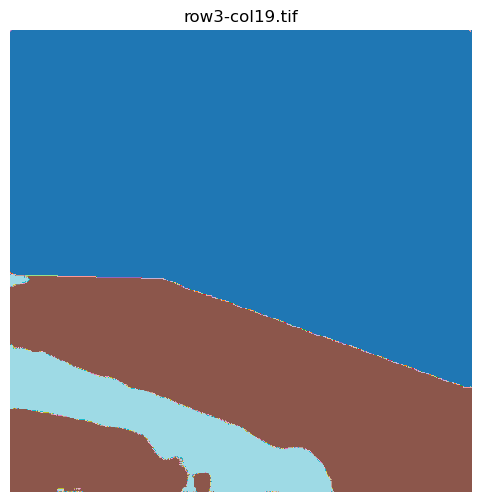

Saved: data\predict\2018\output\row3-col19_pred.tif


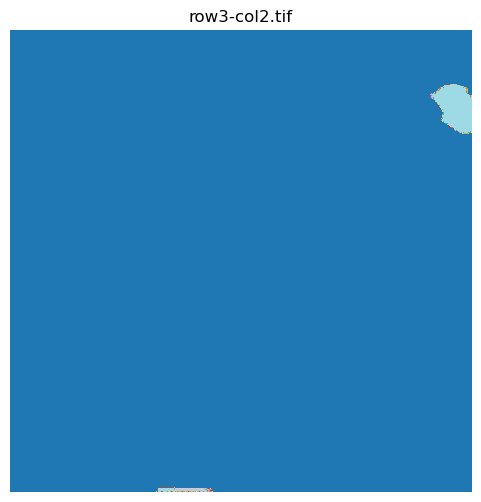

Saved: data\predict\2018\output\row3-col2_pred.tif


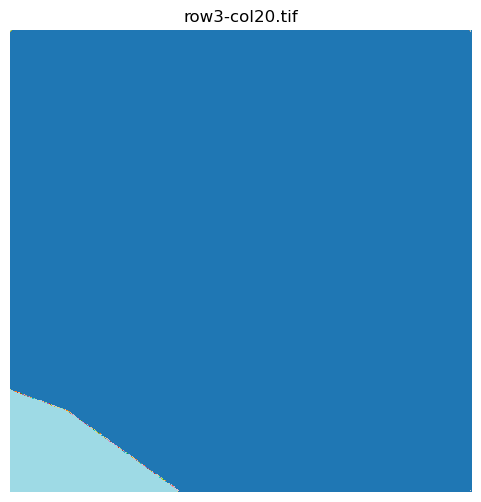

Saved: data\predict\2018\output\row3-col20_pred.tif


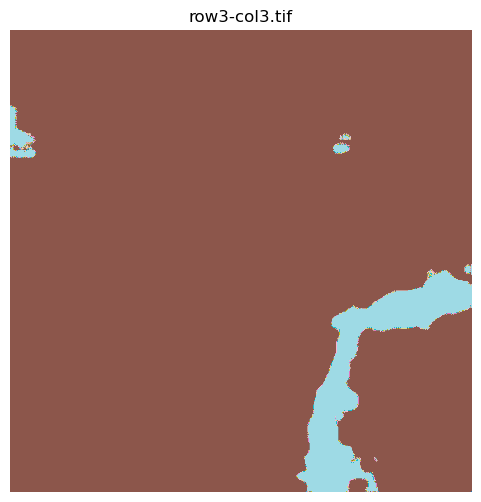

Saved: data\predict\2018\output\row3-col3_pred.tif


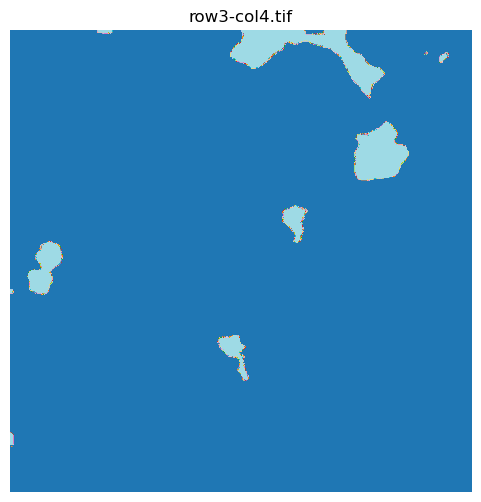

Saved: data\predict\2018\output\row3-col4_pred.tif


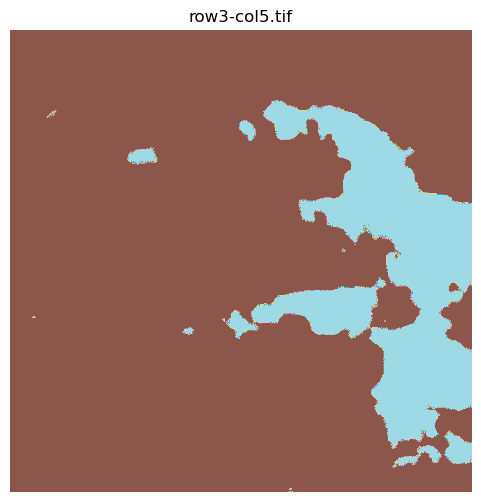

Saved: data\predict\2018\output\row3-col5_pred.tif


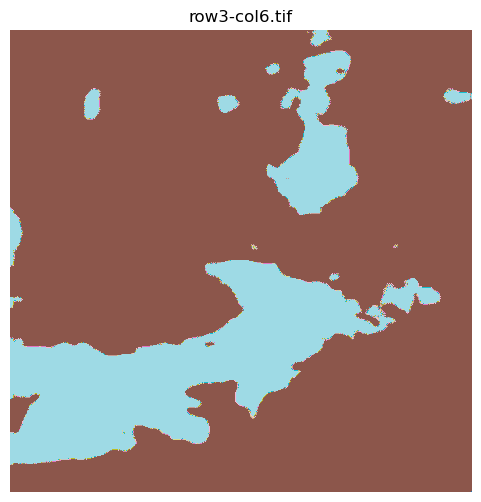

Saved: data\predict\2018\output\row3-col6_pred.tif


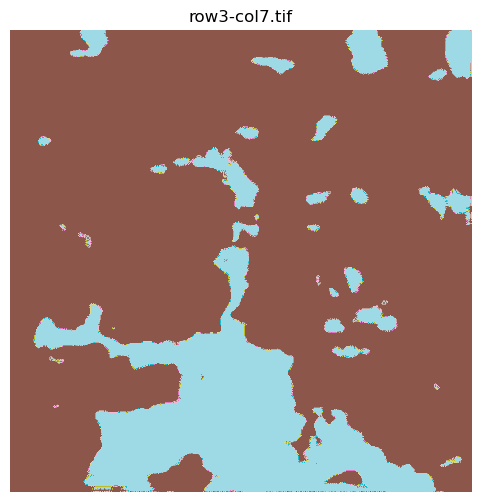

Saved: data\predict\2018\output\row3-col7_pred.tif


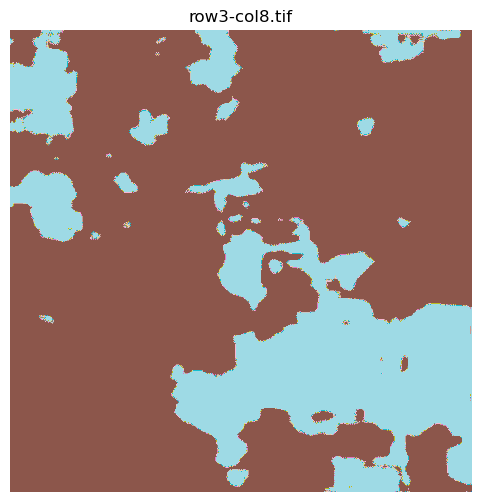

Saved: data\predict\2018\output\row3-col8_pred.tif


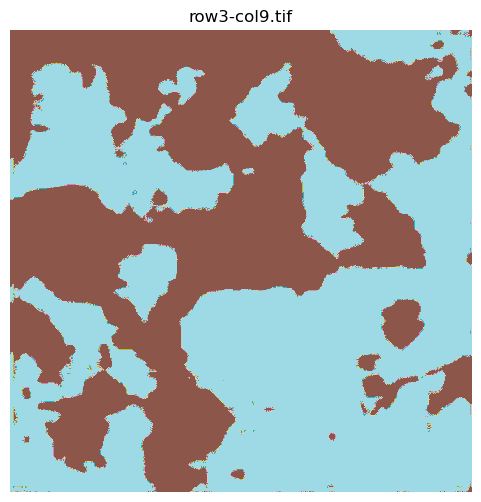

Saved: data\predict\2018\output\row3-col9_pred.tif


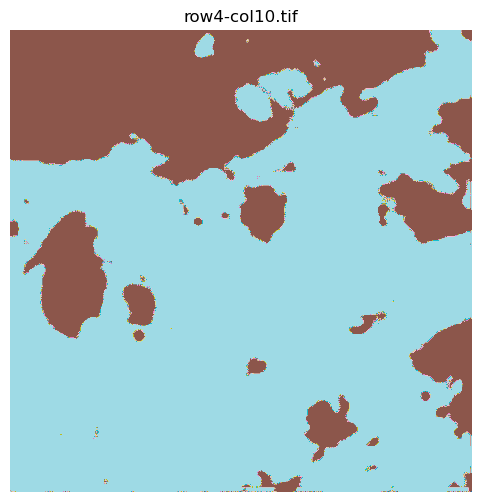

Saved: data\predict\2018\output\row4-col10_pred.tif


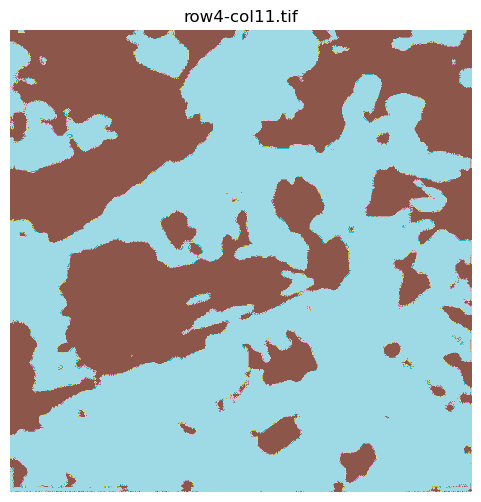

Saved: data\predict\2018\output\row4-col11_pred.tif


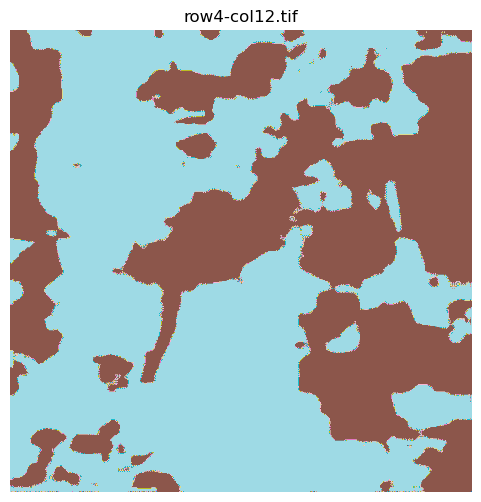

Saved: data\predict\2018\output\row4-col12_pred.tif


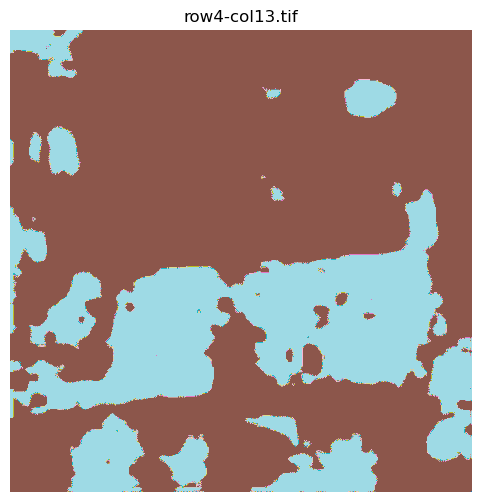

Saved: data\predict\2018\output\row4-col13_pred.tif


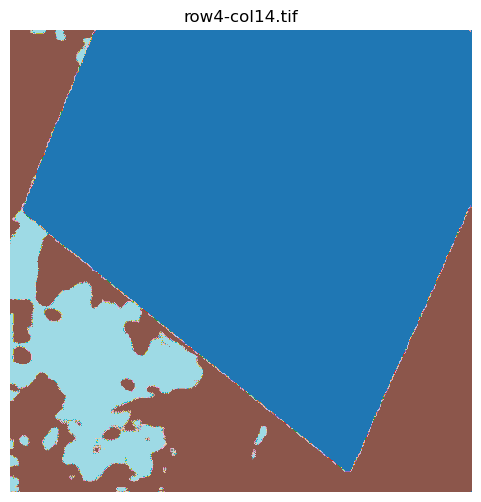

Saved: data\predict\2018\output\row4-col14_pred.tif


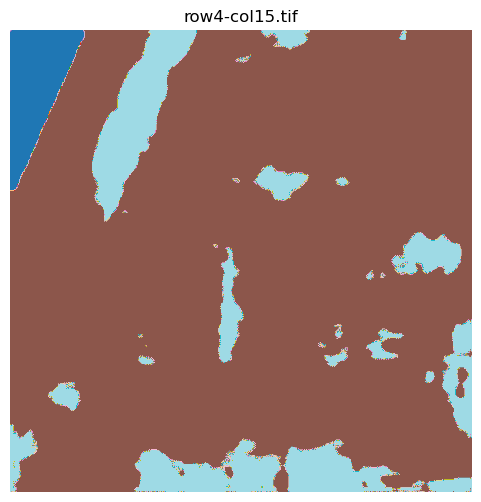

Saved: data\predict\2018\output\row4-col15_pred.tif


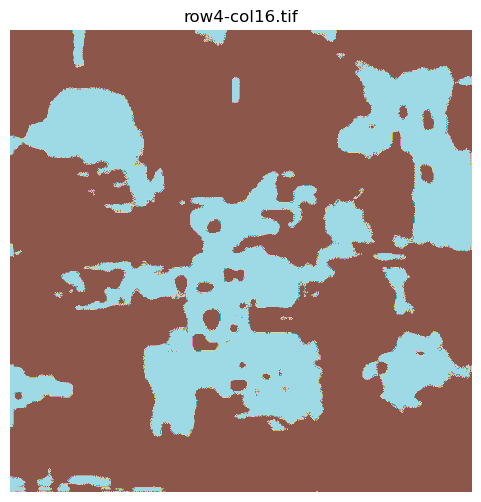

Saved: data\predict\2018\output\row4-col16_pred.tif


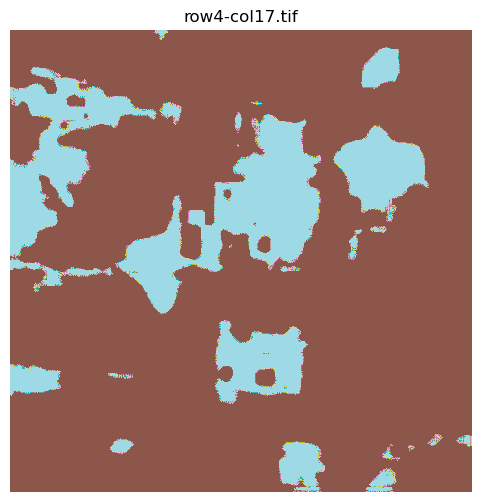

Saved: data\predict\2018\output\row4-col17_pred.tif


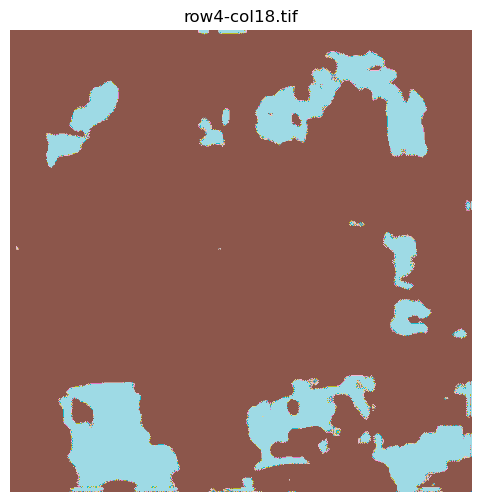

Saved: data\predict\2018\output\row4-col18_pred.tif


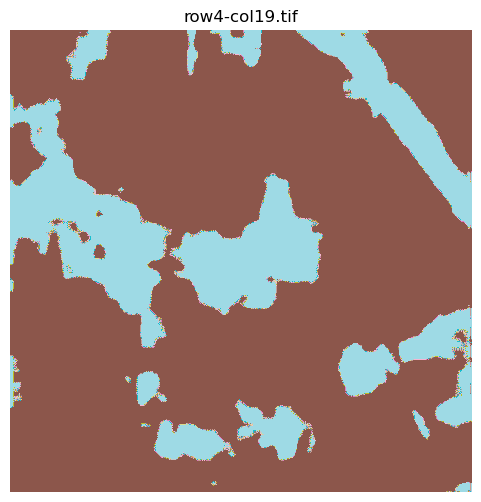

Saved: data\predict\2018\output\row4-col19_pred.tif


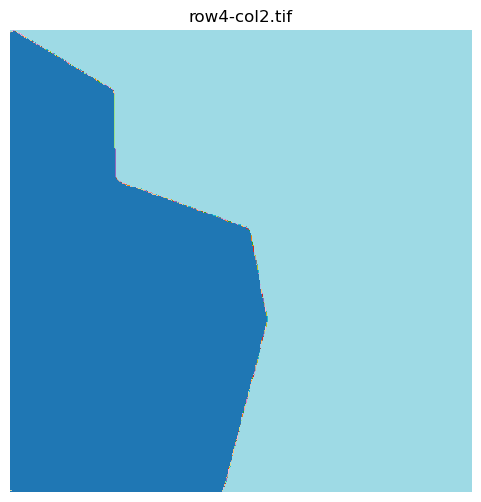

Saved: data\predict\2018\output\row4-col2_pred.tif


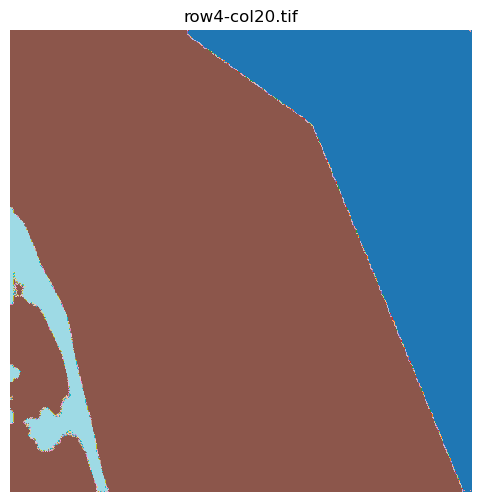

Saved: data\predict\2018\output\row4-col20_pred.tif


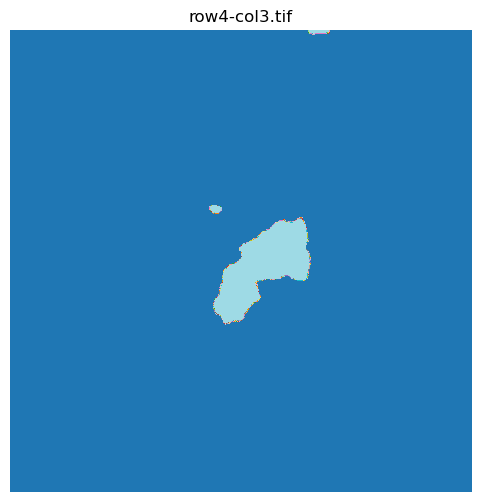

Saved: data\predict\2018\output\row4-col3_pred.tif


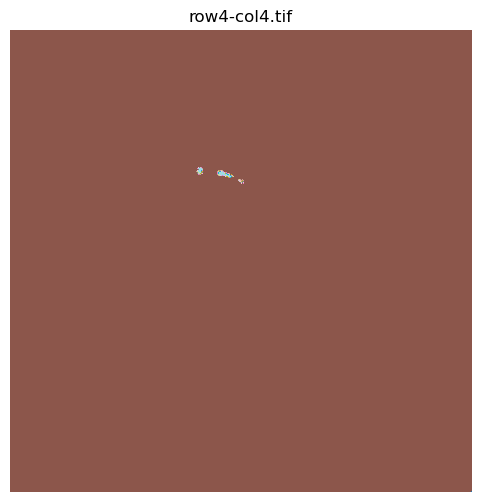

Saved: data\predict\2018\output\row4-col4_pred.tif


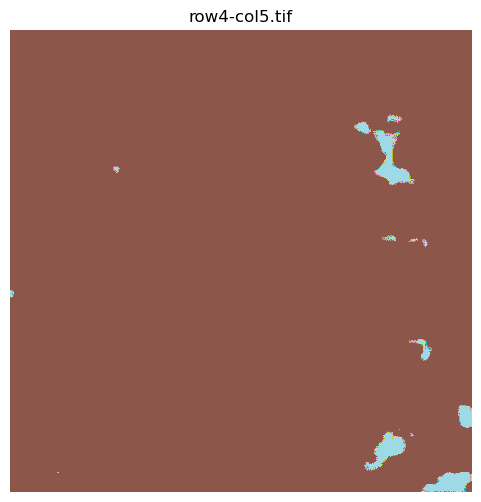

Saved: data\predict\2018\output\row4-col5_pred.tif


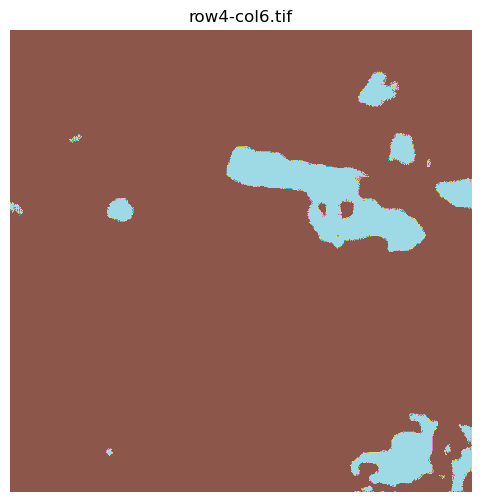

Saved: data\predict\2018\output\row4-col6_pred.tif


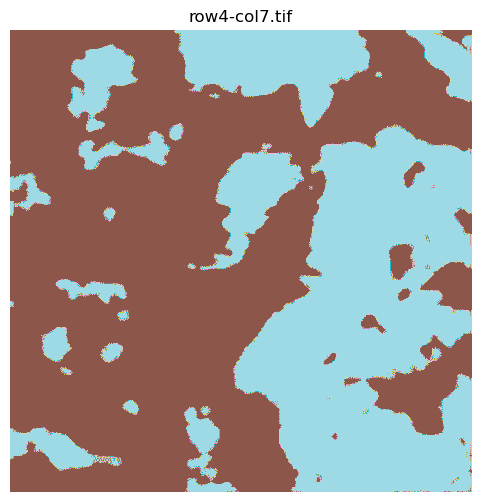

Saved: data\predict\2018\output\row4-col7_pred.tif


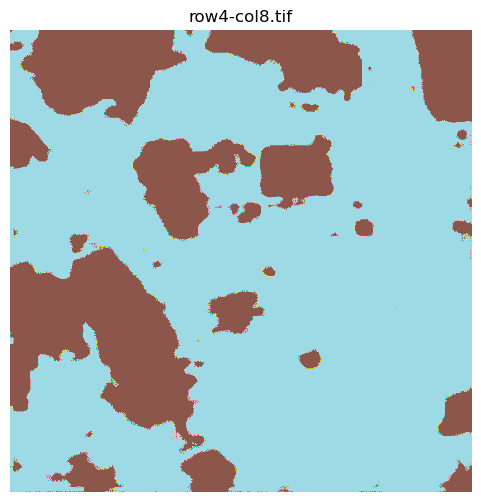

Saved: data\predict\2018\output\row4-col8_pred.tif


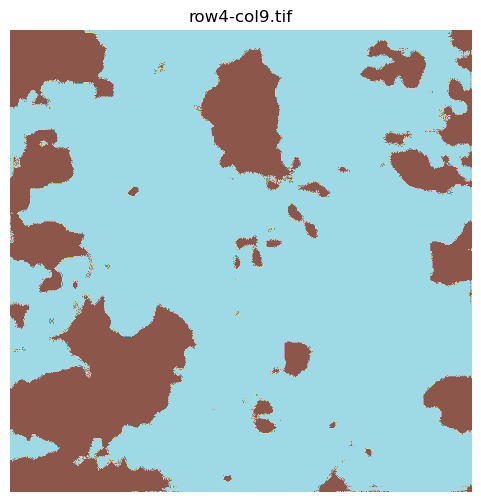

Saved: data\predict\2018\output\row4-col9_pred.tif


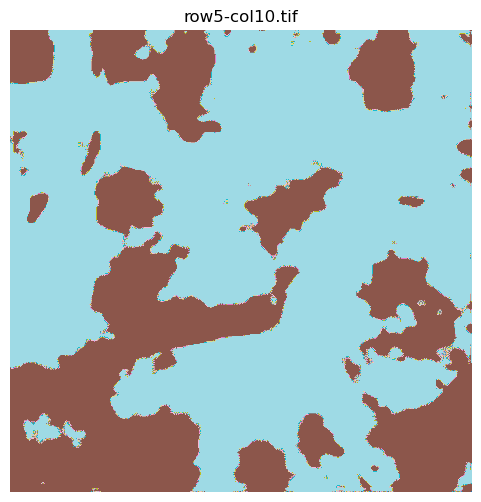

Saved: data\predict\2018\output\row5-col10_pred.tif


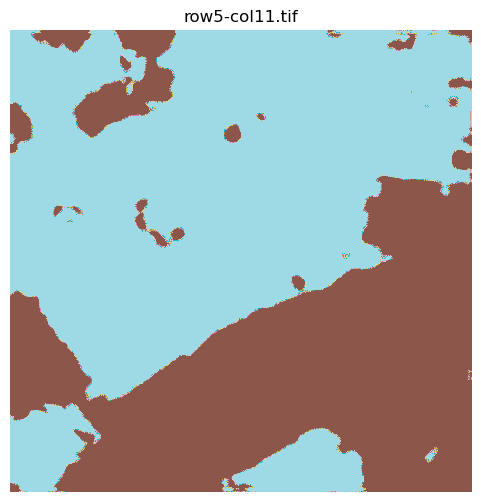

Saved: data\predict\2018\output\row5-col11_pred.tif


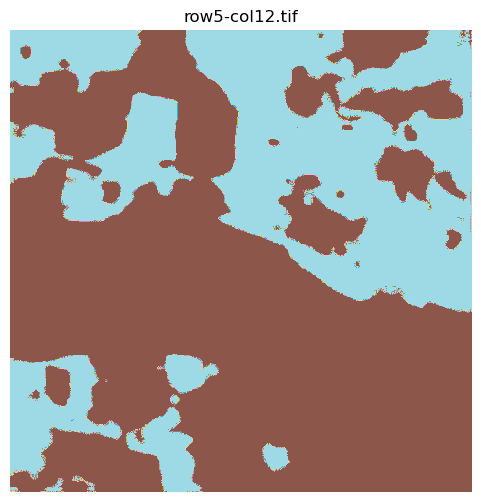

Saved: data\predict\2018\output\row5-col12_pred.tif


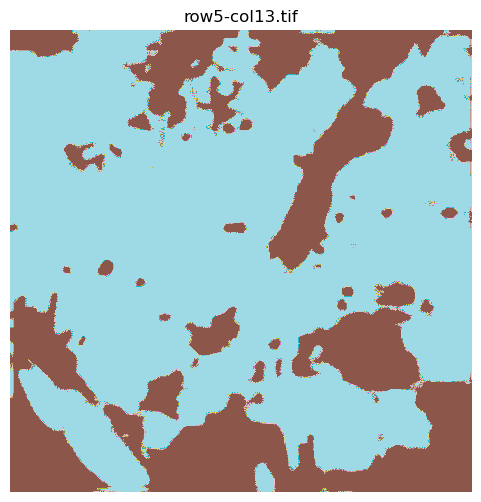

Saved: data\predict\2018\output\row5-col13_pred.tif


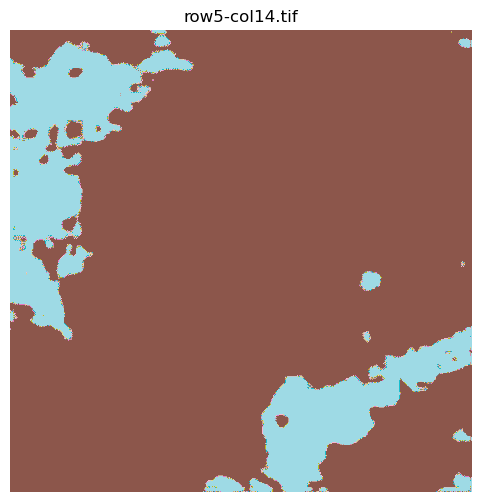

Saved: data\predict\2018\output\row5-col14_pred.tif


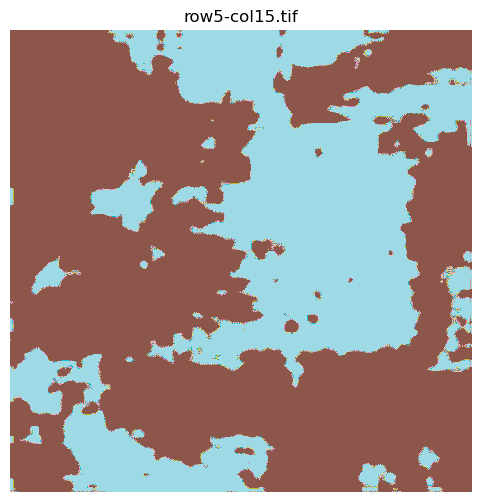

Saved: data\predict\2018\output\row5-col15_pred.tif


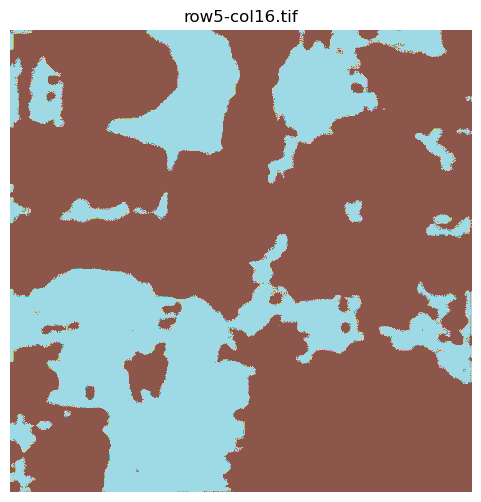

Saved: data\predict\2018\output\row5-col16_pred.tif


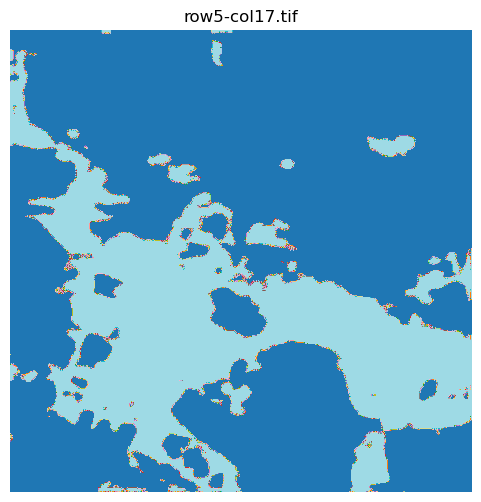

Saved: data\predict\2018\output\row5-col17_pred.tif


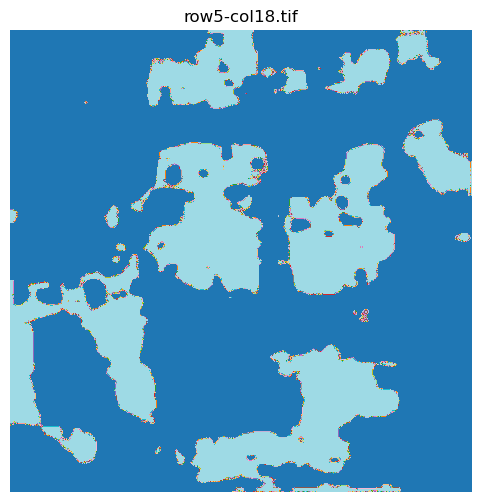

Saved: data\predict\2018\output\row5-col18_pred.tif


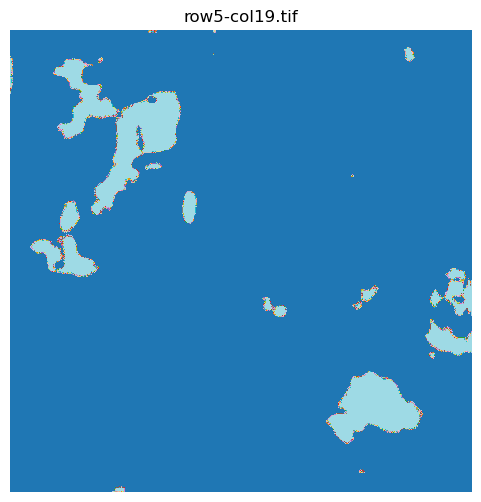

Saved: data\predict\2018\output\row5-col19_pred.tif


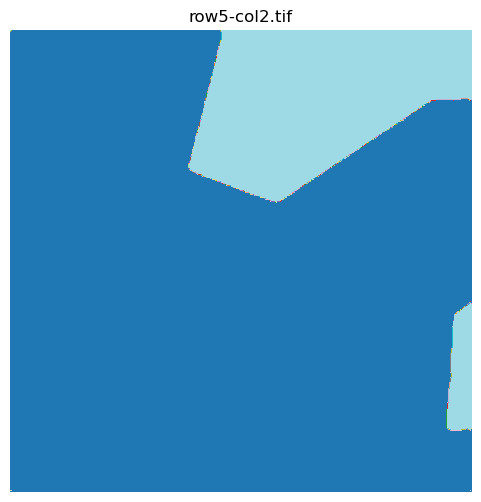

Saved: data\predict\2018\output\row5-col2_pred.tif


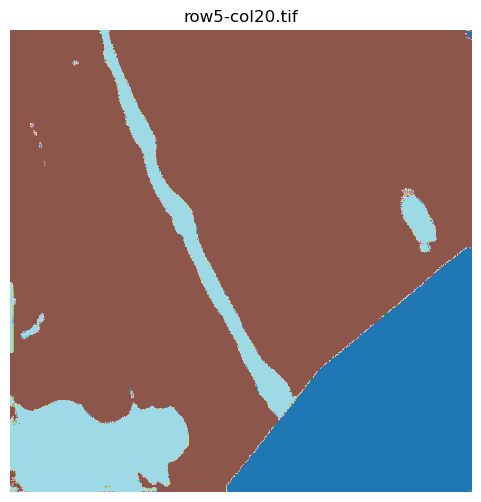

Saved: data\predict\2018\output\row5-col20_pred.tif


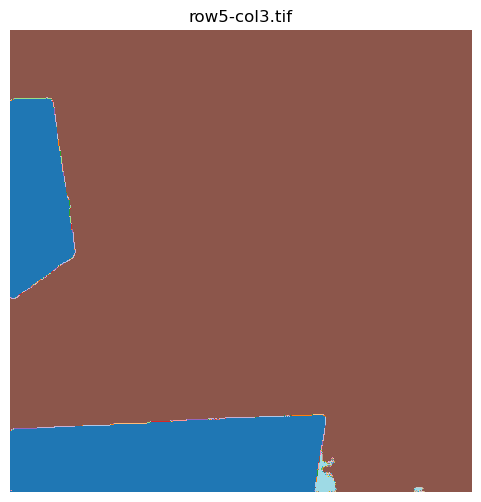

Saved: data\predict\2018\output\row5-col3_pred.tif


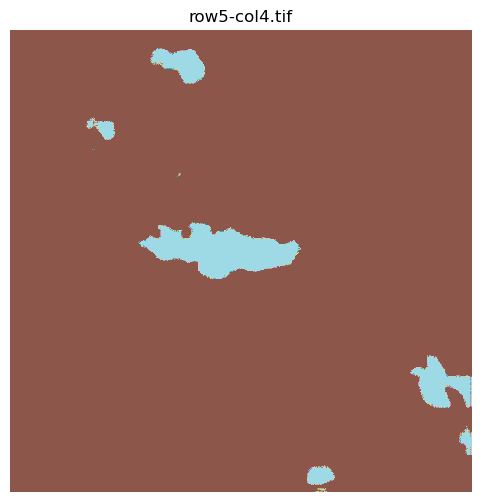

Saved: data\predict\2018\output\row5-col4_pred.tif


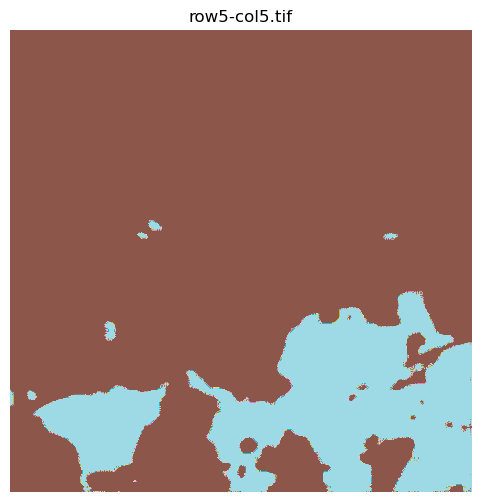

Saved: data\predict\2018\output\row5-col5_pred.tif


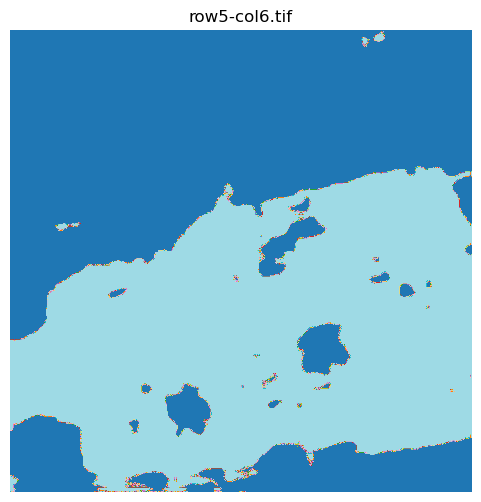

Saved: data\predict\2018\output\row5-col6_pred.tif


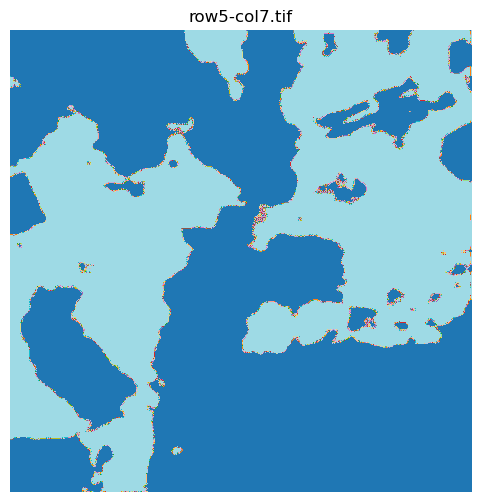

Saved: data\predict\2018\output\row5-col7_pred.tif


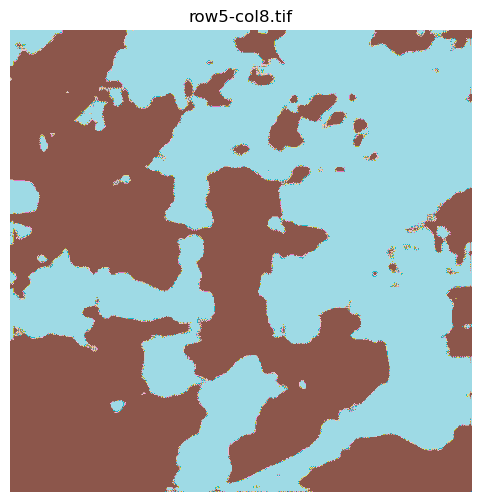

Saved: data\predict\2018\output\row5-col8_pred.tif


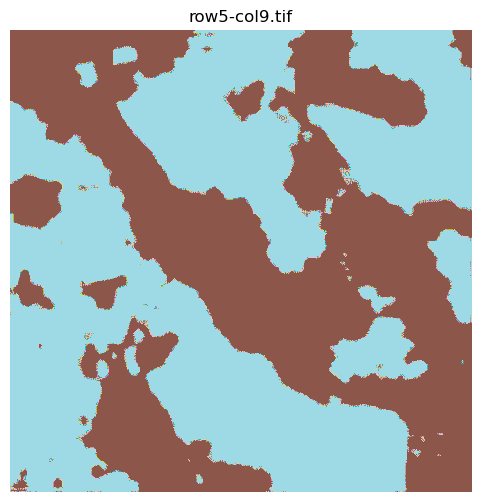

Saved: data\predict\2018\output\row5-col9_pred.tif


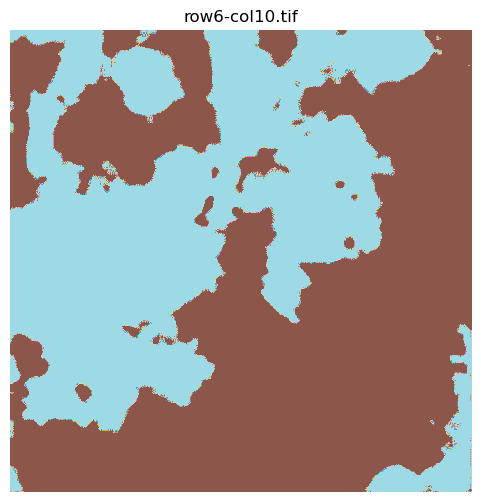

Saved: data\predict\2018\output\row6-col10_pred.tif


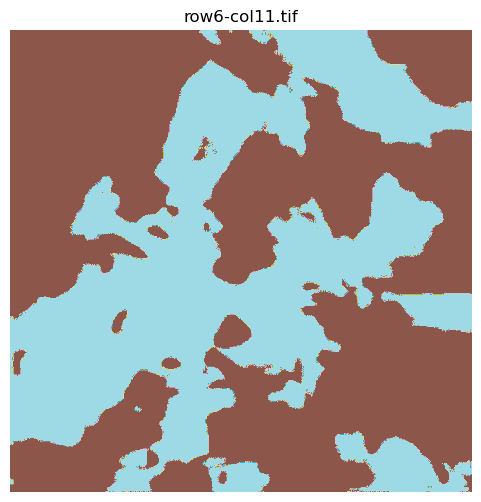

Saved: data\predict\2018\output\row6-col11_pred.tif


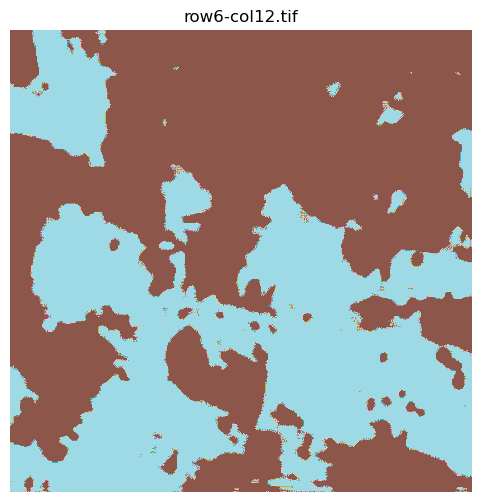

Saved: data\predict\2018\output\row6-col12_pred.tif


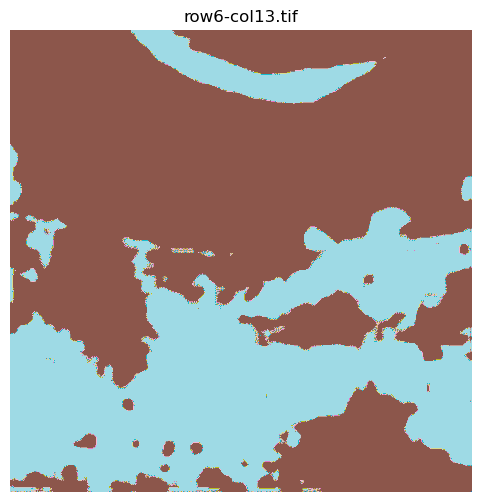

Saved: data\predict\2018\output\row6-col13_pred.tif


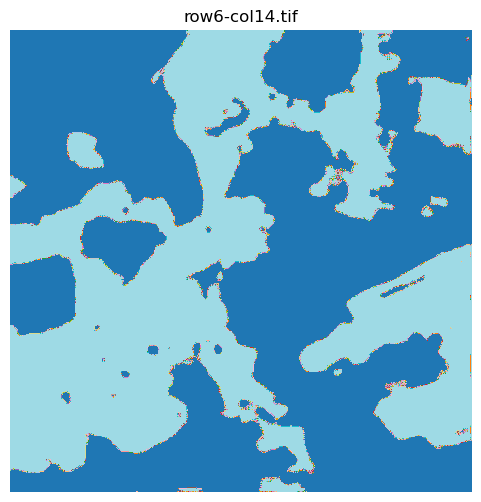

Saved: data\predict\2018\output\row6-col14_pred.tif


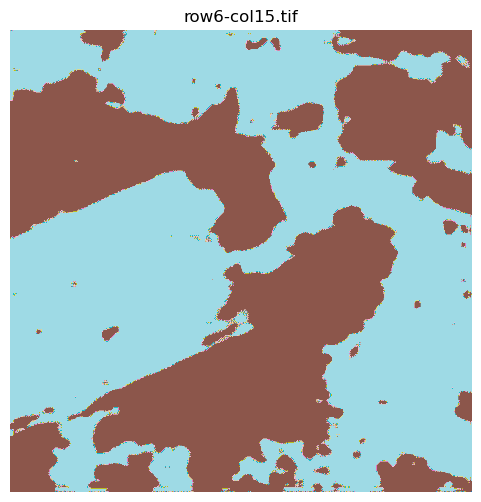

Saved: data\predict\2018\output\row6-col15_pred.tif


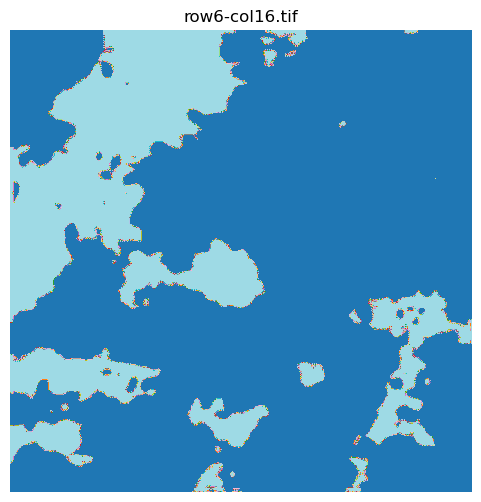

Saved: data\predict\2018\output\row6-col16_pred.tif


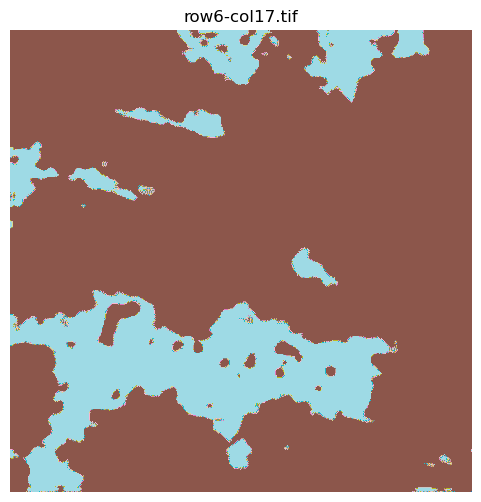

Saved: data\predict\2018\output\row6-col17_pred.tif


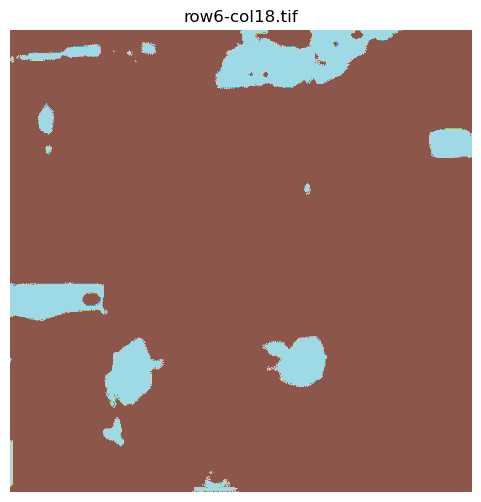

Saved: data\predict\2018\output\row6-col18_pred.tif


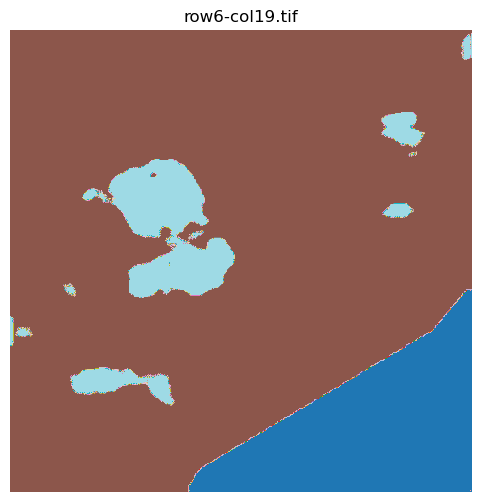

Saved: data\predict\2018\output\row6-col19_pred.tif


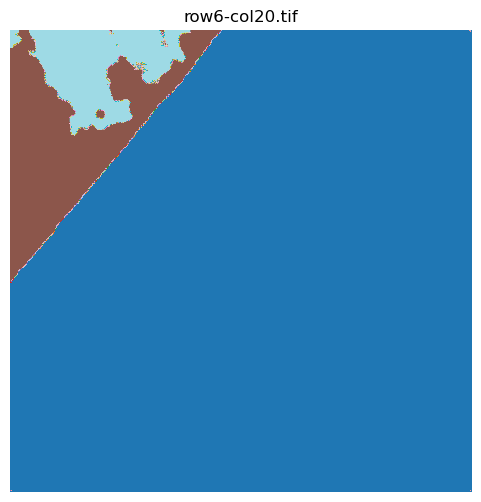

Saved: data\predict\2018\output\row6-col20_pred.tif


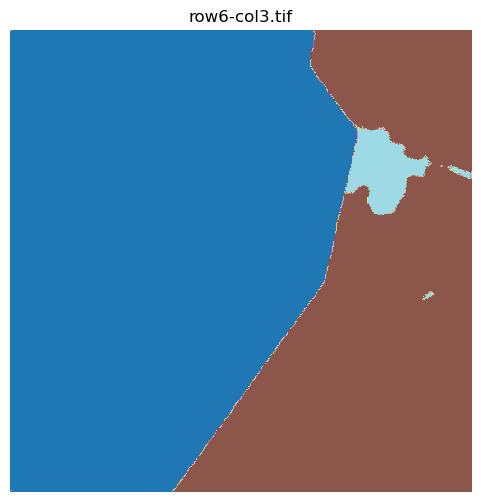

Saved: data\predict\2018\output\row6-col3_pred.tif


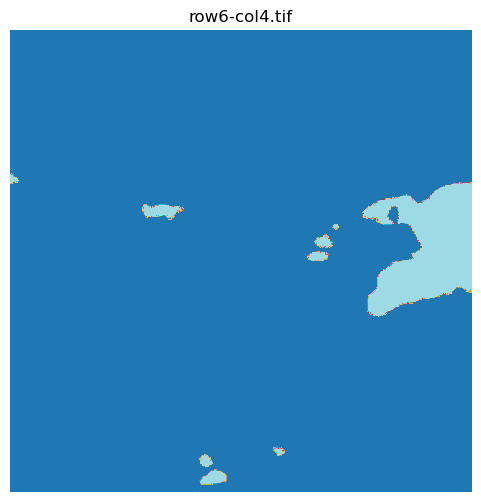

Saved: data\predict\2018\output\row6-col4_pred.tif


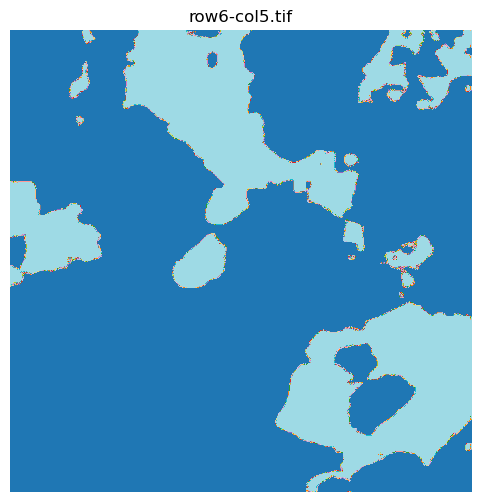

Saved: data\predict\2018\output\row6-col5_pred.tif


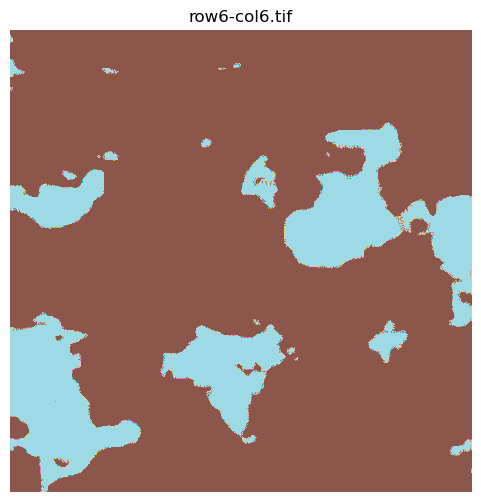

Saved: data\predict\2018\output\row6-col6_pred.tif


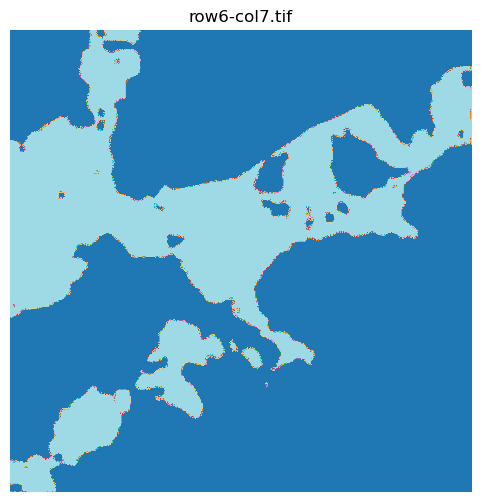

Saved: data\predict\2018\output\row6-col7_pred.tif


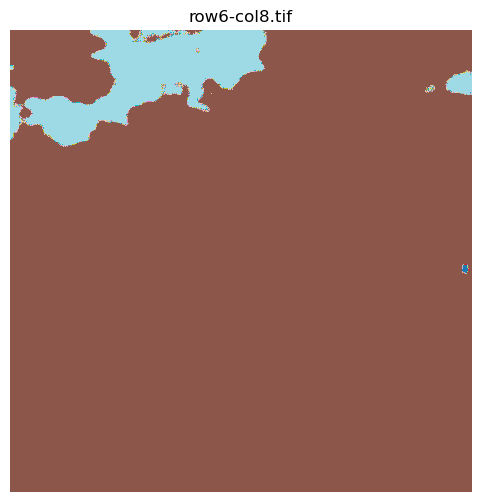

Saved: data\predict\2018\output\row6-col8_pred.tif


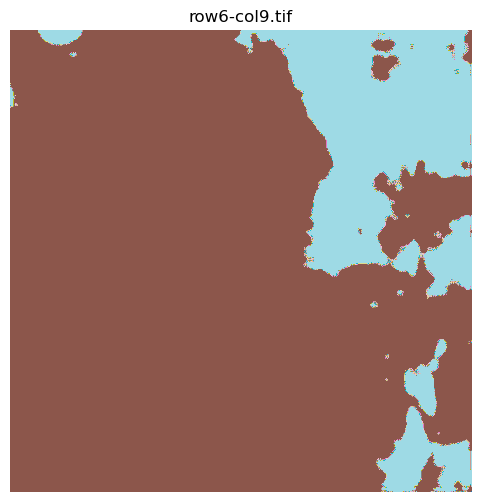

Saved: data\predict\2018\output\row6-col9_pred.tif


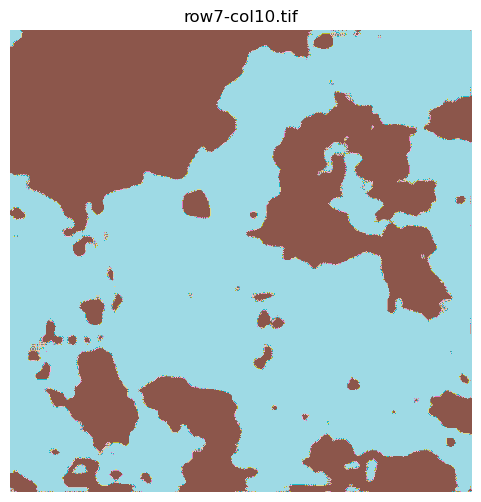

Saved: data\predict\2018\output\row7-col10_pred.tif


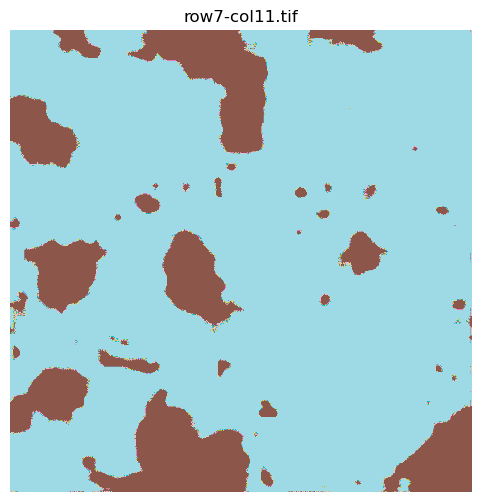

Saved: data\predict\2018\output\row7-col11_pred.tif


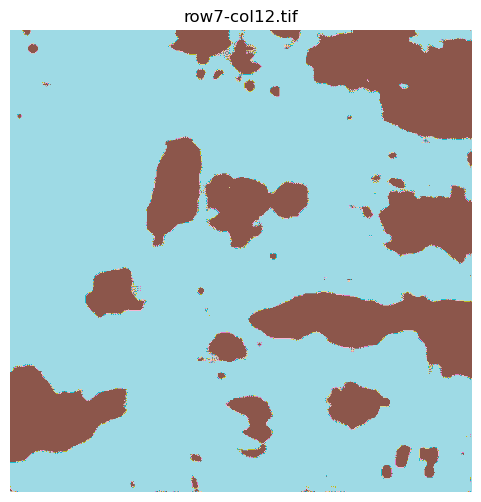

Saved: data\predict\2018\output\row7-col12_pred.tif


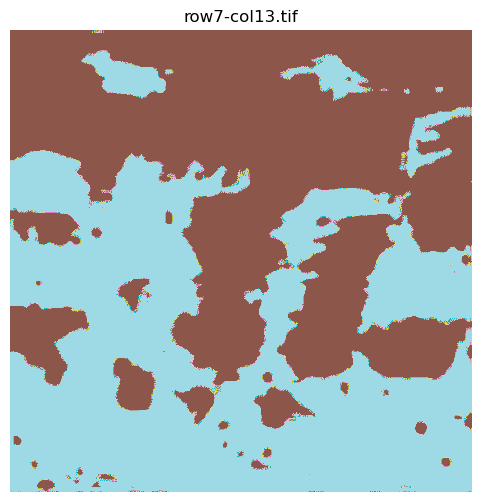

Saved: data\predict\2018\output\row7-col13_pred.tif


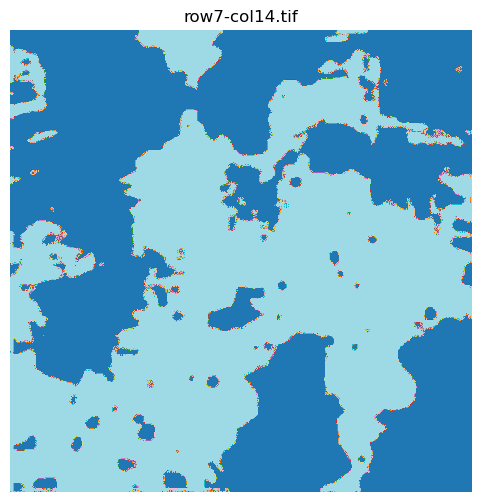

Saved: data\predict\2018\output\row7-col14_pred.tif


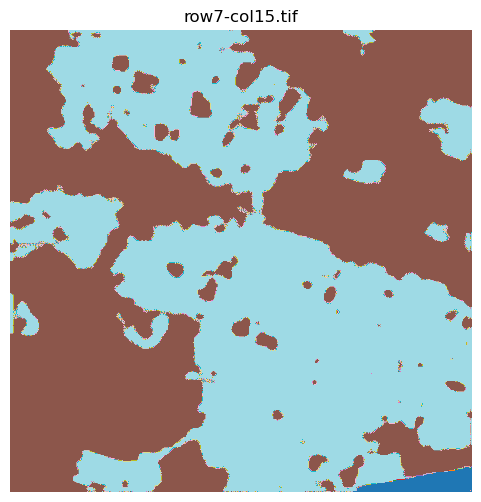

Saved: data\predict\2018\output\row7-col15_pred.tif


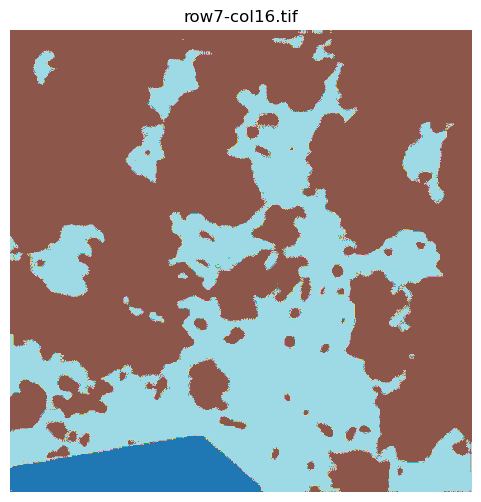

Saved: data\predict\2018\output\row7-col16_pred.tif


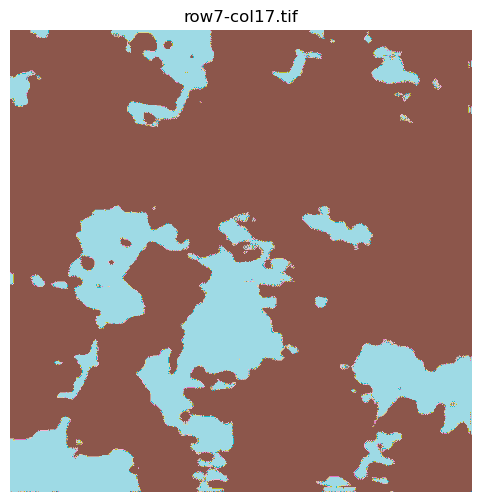

Saved: data\predict\2018\output\row7-col17_pred.tif


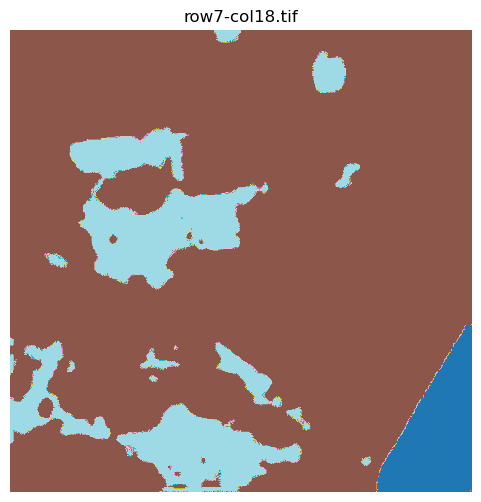

Saved: data\predict\2018\output\row7-col18_pred.tif


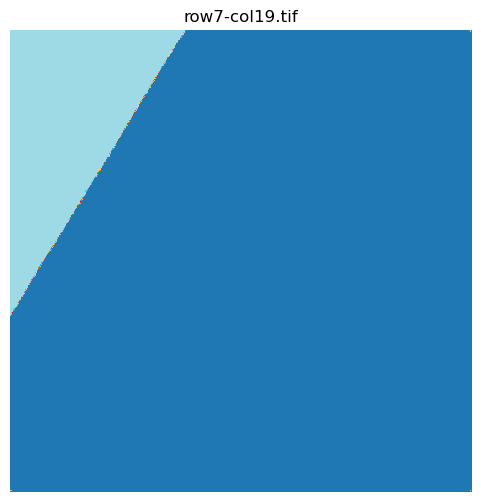

Saved: data\predict\2018\output\row7-col19_pred.tif


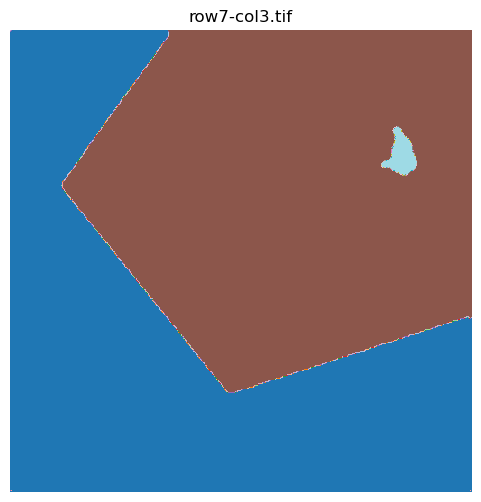

Saved: data\predict\2018\output\row7-col3_pred.tif


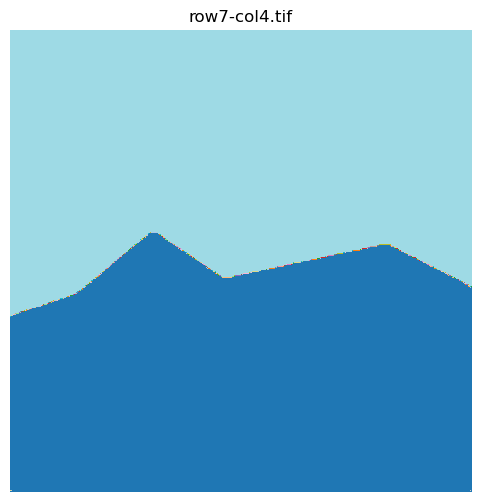

Saved: data\predict\2018\output\row7-col4_pred.tif


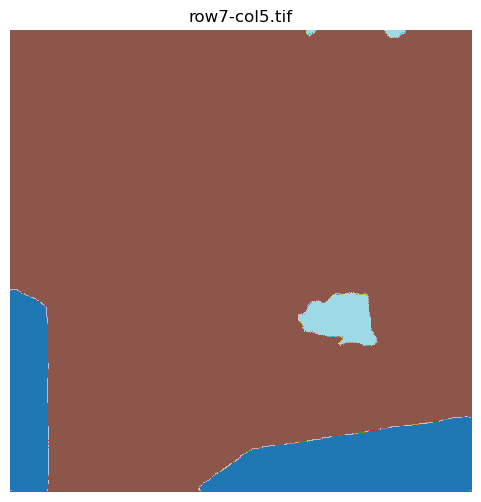

Saved: data\predict\2018\output\row7-col5_pred.tif


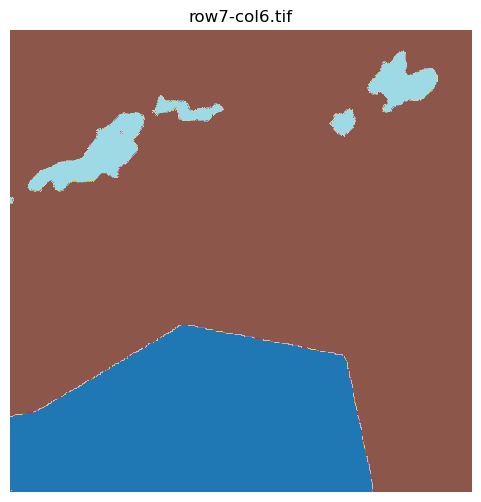

Saved: data\predict\2018\output\row7-col6_pred.tif


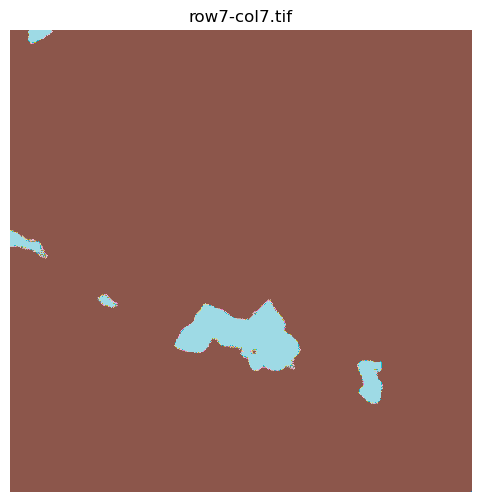

Saved: data\predict\2018\output\row7-col7_pred.tif


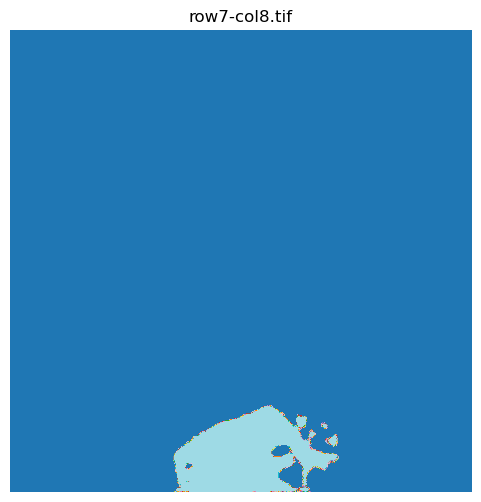

Saved: data\predict\2018\output\row7-col8_pred.tif


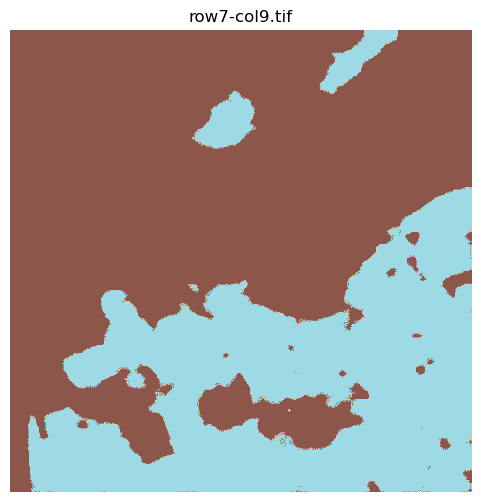

Saved: data\predict\2018\output\row7-col9_pred.tif


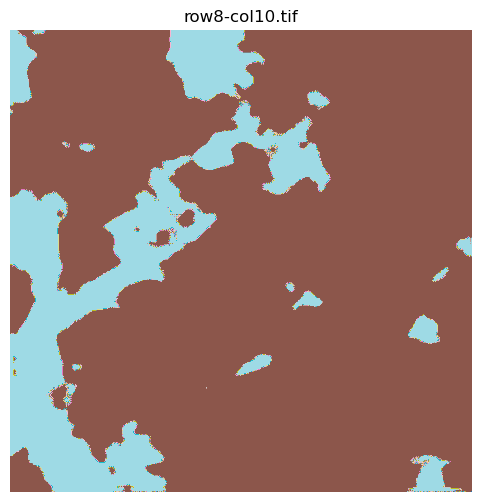

Saved: data\predict\2018\output\row8-col10_pred.tif


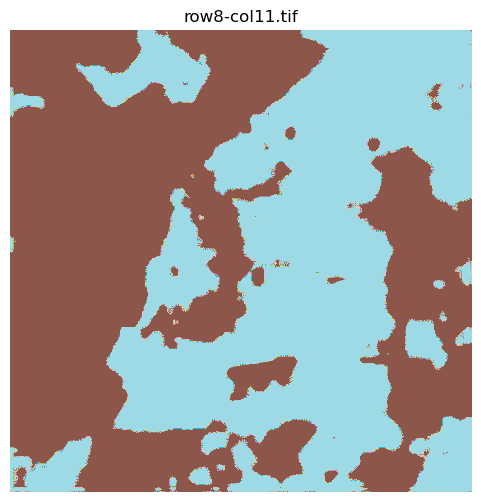

Saved: data\predict\2018\output\row8-col11_pred.tif


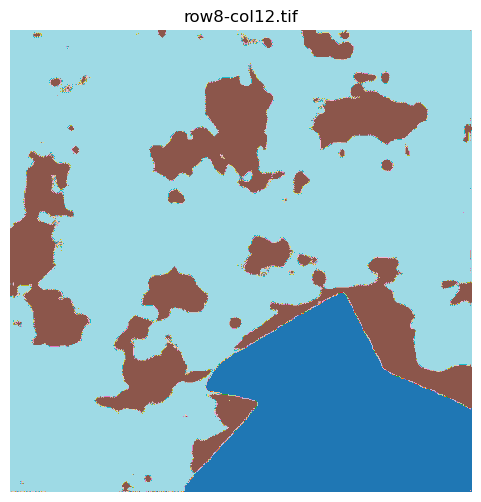

Saved: data\predict\2018\output\row8-col12_pred.tif


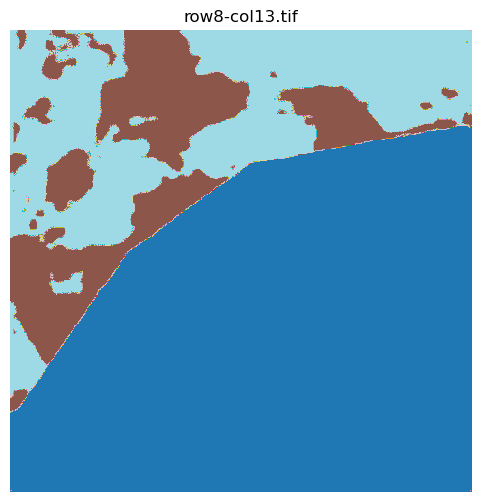

Saved: data\predict\2018\output\row8-col13_pred.tif


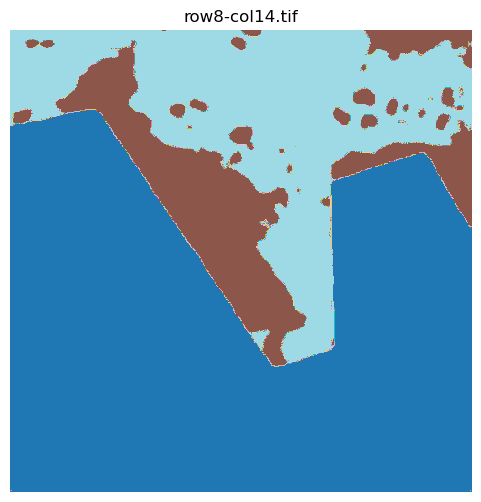

Saved: data\predict\2018\output\row8-col14_pred.tif


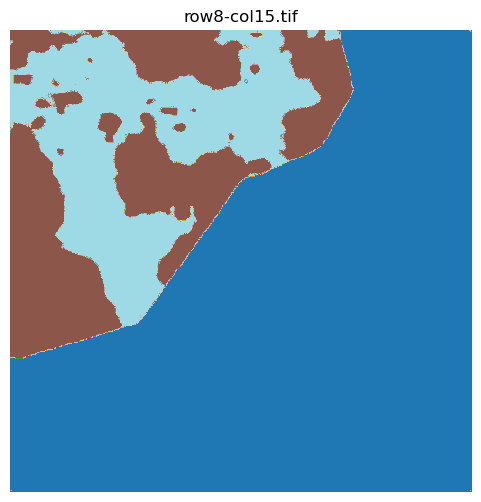

Saved: data\predict\2018\output\row8-col15_pred.tif


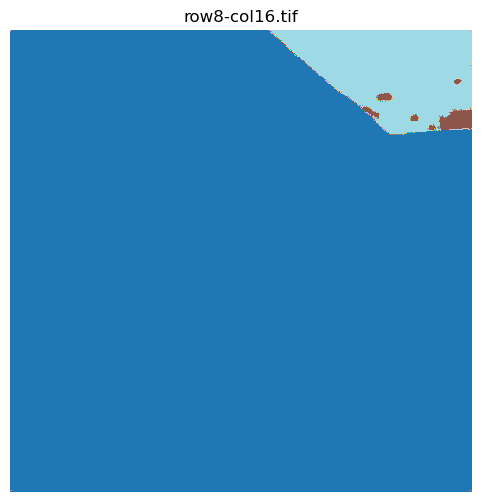

Saved: data\predict\2018\output\row8-col16_pred.tif


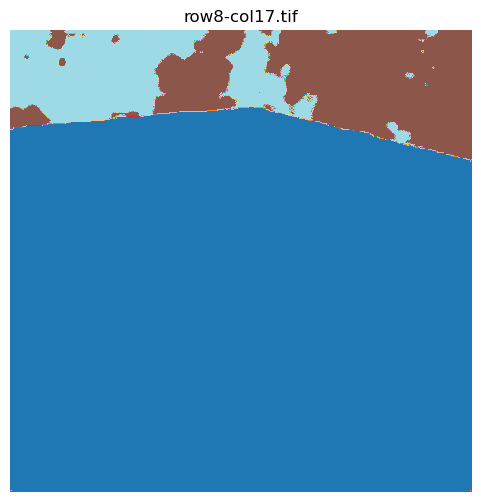

Saved: data\predict\2018\output\row8-col17_pred.tif


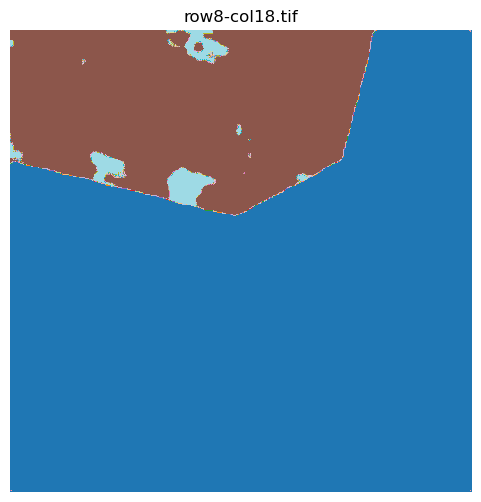

Saved: data\predict\2018\output\row8-col18_pred.tif


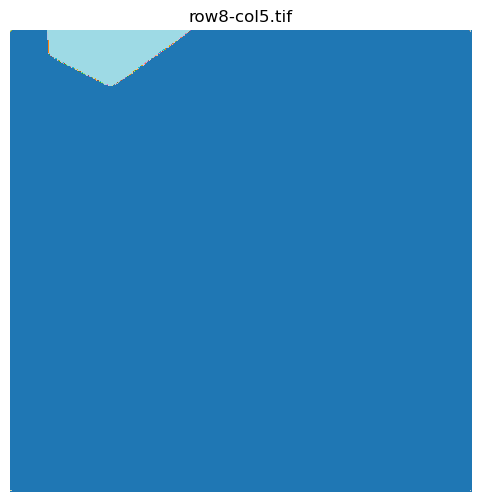

Saved: data\predict\2018\output\row8-col5_pred.tif


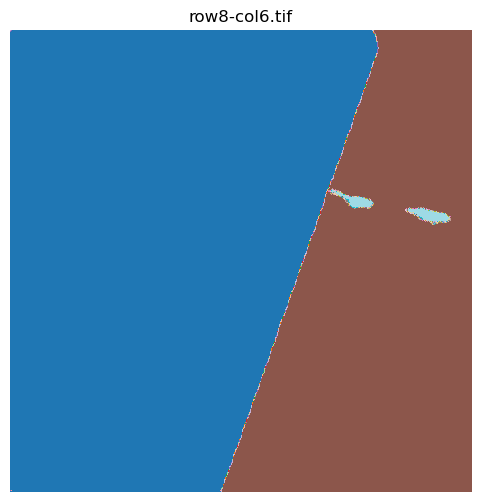

Saved: data\predict\2018\output\row8-col6_pred.tif


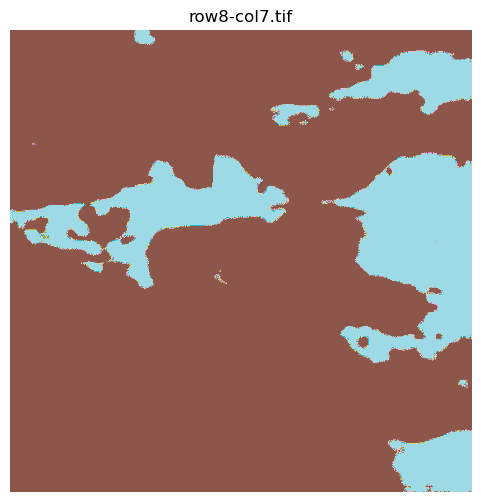

Saved: data\predict\2018\output\row8-col7_pred.tif


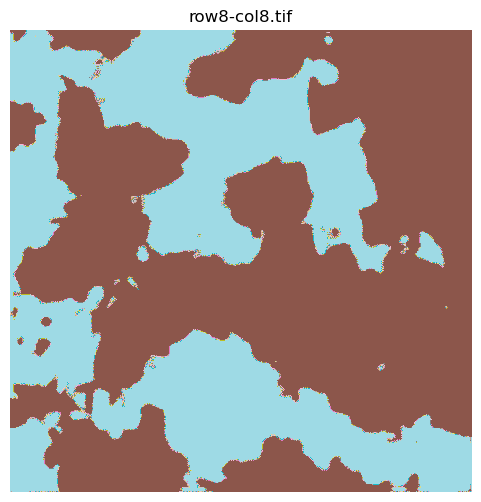

Saved: data\predict\2018\output\row8-col8_pred.tif


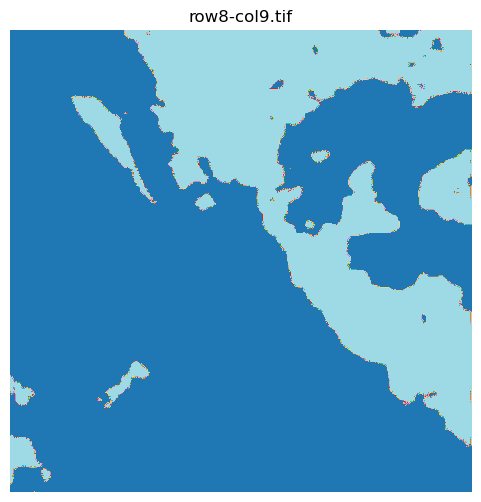

Saved: data\predict\2018\output\row8-col9_pred.tif


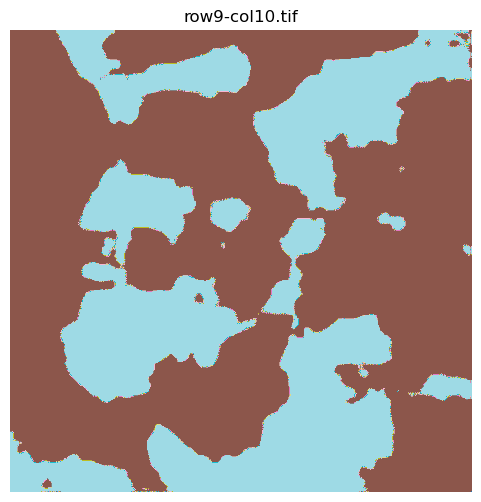

Saved: data\predict\2018\output\row9-col10_pred.tif


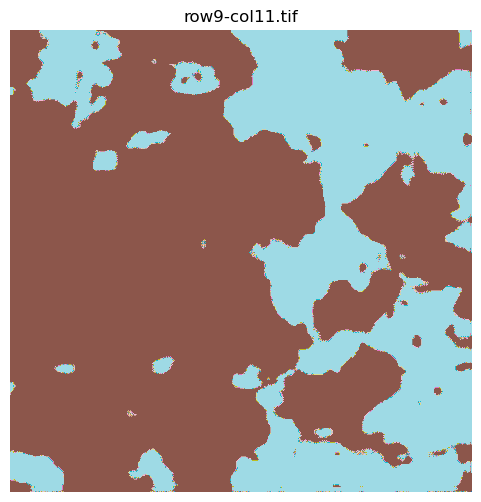

Saved: data\predict\2018\output\row9-col11_pred.tif


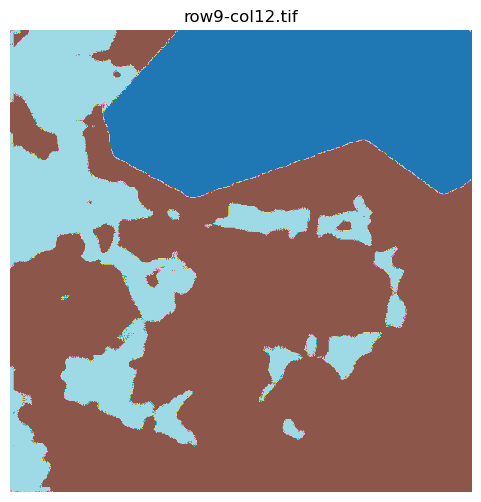

Saved: data\predict\2018\output\row9-col12_pred.tif


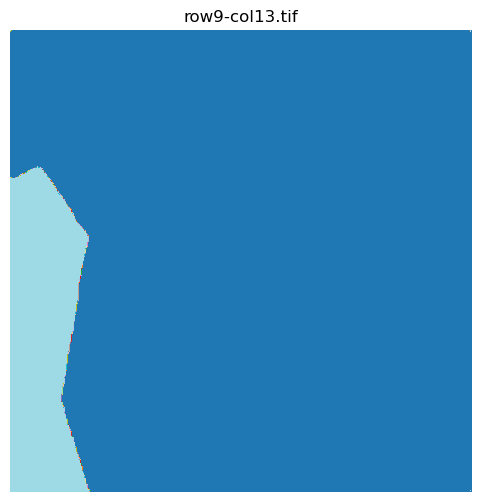

Saved: data\predict\2018\output\row9-col13_pred.tif


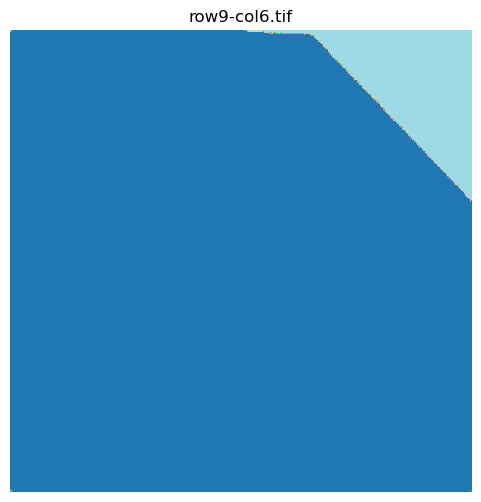

Saved: data\predict\2018\output\row9-col6_pred.tif


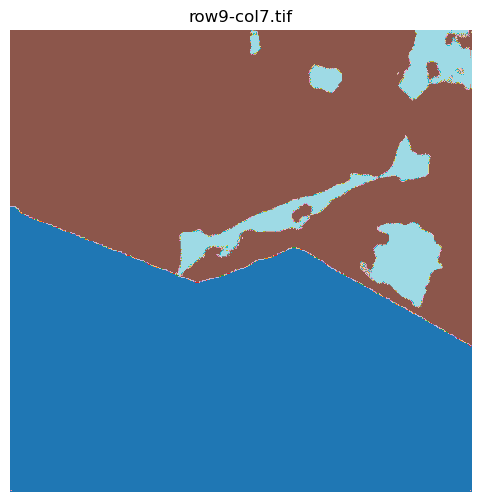

Saved: data\predict\2018\output\row9-col7_pred.tif


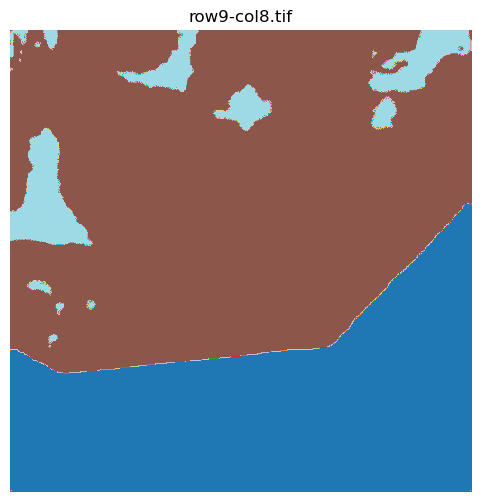

Saved: data\predict\2018\output\row9-col8_pred.tif


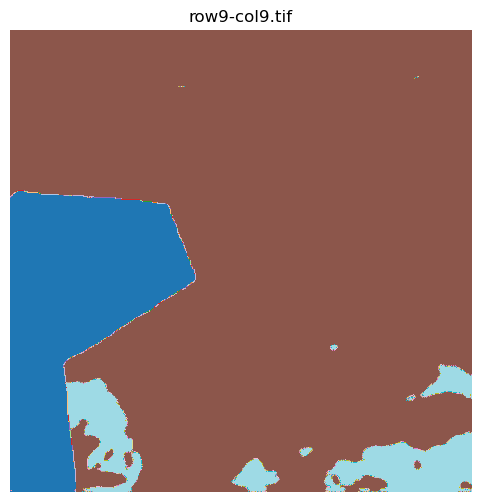

Saved: data\predict\2018\output\row9-col9_pred.tif


In [12]:
import os
from pathlib import Path
import torch
import numpy as np
import rasterio
from rasterio.transform import from_origin
from skimage import transform
import matplotlib.pyplot as plt
import torch.nn.functional as F  # 用于 softmax

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNET(4, 3).to(device)  # 输入4通道，输出3类（根据你的实际类别数修改）
model.load_state_dict(torch.load('unet_third_model.pth', map_location=device))
model.eval()

def preprocess(img):
    img = transform.resize(img, (4, 512, 512), preserve_range=True).astype(np.float32)
    img = img / 10000.0
    return torch.tensor(img, dtype=torch.float32).unsqueeze(0)

def visualize_prediction(pred_class, title="Prediction"):
    plt.figure(figsize=(6, 6))
    plt.imshow(pred_class, cmap='tab20')
    plt.title(title)
    plt.axis('off')
    plt.show()

def predict_folder(input_folder, output_folder, visualize=False):
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    for tif_path in input_folder.glob('*.tif'):
        with rasterio.open(tif_path) as src:
            img = src.read()  # (5, H, W)
            img = img[[1, 2, 3, 4], :, :]  # B3, B4, B8, B11
            transform_meta = src.transform
            crs_meta = src.crs

        img_tensor = preprocess(img).to(device)

        with torch.no_grad():
            pred = model(img_tensor)              # 输出形状: [1, C, H, W]
            pred_soft = F.softmax(pred[0], dim=0) # 取 batch[0]，然后对类别维做 softmax
            pred_class = torch.argmax(pred_soft, dim=0).cpu().numpy().astype(np.uint8)  # [H, W]

        if visualize:
            visualize_prediction(pred_class, title=tif_path.name)

        out_path = output_folder / tif_path.name.replace('.tif', '_pred.tif')
        with rasterio.open(
            out_path,
            'w',
            driver='GTiff',
            height=pred_class.shape[0],
            width=pred_class.shape[1],
            count=1,
            dtype=np.uint8,
            crs=crs_meta,
            transform=transform_meta
        ) as dst:
            dst.write(pred_class, 1)

        print(f"Saved: {out_path}")

# 用法示例（运行前请确认路径）
predict_folder('data/predict/2018/raw', 'data/predict/2018/output', visualize=True)

In [13]:
import os
import rasterio
from rasterio.merge import merge
from tqdm import tqdm

input_folder = 'data/predict/2018/output'
output_file = 'data/lu2018_pred3.tif'
target_crs = 'EPSG:4326'

tif_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.tif')]

src_files_to_mosaic = []
for tif_path in tqdm(tif_files, desc="Opening tiles"):
    with rasterio.open(tif_path) as src:
        if src.crs is None or src.transform is None:
            raise ValueError(f"❌ {tif_path} is missing CRS or transform!")
    src_files_to_mosaic.append(rasterio.open(tif_path))

mosaic, out_trans = merge(src_files_to_mosaic)

out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": target_crs,
    "compress": "lzw",
    "BIGTIFF": "YES"
})

with rasterio.open(output_file, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"\n✅ Mosaic complete! Output saved to: {output_file}")

Opening tiles: 100%|█████████████████████████████████████████████████████████████████| 164/164 [00:04<00:00, 33.75it/s]



✅ Mosaic complete! Output saved to: data/lu2018_pred3.tif
